In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import numpy as np
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
import glob
import os
from shapely.geometry import Point
from adjustText import adjust_text
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import re
import chardet
import scipy.stats as stats

# Exploratory Data Analysis

In [8]:
operating_budget = pd.read_csv('./data/FY25_Operating.csv')

# Read file with detected encoding
print('Columns of FY25_Operating.csv')
print(operating_budget.head())
print()

Columns of FY25_Operating.csv
   _id          Cabinet            Dept                 Program  \
0    1  Mayor's Cabinet  Mayor's Office  Mayor's Administration   
1    2  Mayor's Cabinet  Mayor's Office  Mayor's Administration   
2    3  Mayor's Cabinet  Mayor's Office  Mayor's Administration   
3    4  Mayor's Cabinet  Mayor's Office  Mayor's Administration   
4    5  Mayor's Cabinet  Mayor's Office  Mayor's Administration   

                Expense Category FY22 Actual Expense FY23 Actual Expense  \
0             Personnel Services          1624903.69          2374448.36   
1           Contractual Services            284597.9           383743.11   
2           Supplies & Materials            28541.55            74491.63   
3  Current Charges & Obligations             19410.3            25350.83   
4                      Equipment            16164.36            44132.61   

  FY24 Appropriation FY25 Budget  
0         1921403.81  2217748.39  
1          219633.42      234628  
2    

# Data Cleaning

In [12]:
empty=['#Missing']
print('Missing data by columns of csvs')
print(f'FY25_Operating={operating_budget.apply(lambda col: col.isin(empty).sum())}')
print()
print('Replacing Missing values')
operating_budget.replace({'#Missing':0},inplace=True)
operating_budget['FY22 Actual Expense'] = pd.to_numeric(operating_budget['FY22 Actual Expense'], errors='coerce')
operating_budget['FY23 Actual Expense'] = pd.to_numeric(operating_budget['FY23 Actual Expense'], errors='coerce')
operating_budget['FY24 Appropriation'] = pd.to_numeric(operating_budget['FY24 Appropriation'], errors='coerce')
operating_budget['FY25 Budget']=pd.to_numeric(operating_budget['FY25 Budget'], errors='coerce')

def standardize_column_names(df):
    """
    Standardize column names by removing special characters and converting to lowercase.
    """
    # Remove BOM character if present and convert to lowercase
    return df.rename(columns=lambda x: x.replace('ï»¿', '').strip().lower())

def merge_duplicate_columns(df, duplicate_cols):
    """
    Merge duplicate columns by taking the first non-null value across duplicates.
    """
    for col in duplicate_cols:
        # Find all columns that match the duplicate column name
        matching_cols = df.columns[df.columns == col]

        if len(matching_cols) > 1:
            # Combine columns by taking the first non-null value from left to right
            df[col] = df[list(matching_cols)].bfill(axis=1).iloc[:, 0]
            # Drop the duplicate columns, keeping only the first one
            df.drop(columns=list(matching_cols)[1:], inplace=True)
            print(f"Merged columns: {list(matching_cols)} into '{col}'")
    return df

def process_checkbook_files(data_directory):
    """
    Process and combine checkbook CSV files while handling column name inconsistencies.
    """
    # Define file pattern
    file_pattern = os.path.join(data_directory, 'checkbook-explorer-fy*.csv')
    csv_files = glob.glob(file_pattern)

    if not csv_files:
        raise FileNotFoundError(f"No CSV files found matching pattern: {file_pattern}")

    df_list = []

    # Read and standardize each CSV file
    for file in csv_files:
        try:
            # Read the CSV file with 'iso-8859-1' encoding
            temp_df = pd.read_csv(file, encoding='iso-8859-1')
            # Standardize column names immediately upon loading
            temp_df = standardize_column_names(temp_df)

            df_list.append(temp_df)
            print(f"Successfully loaded and standardized {file} with {temp_df.shape[0]} records.")
        except Exception as e:
            print(f"Error loading {file}: {e}")


Missing data by columns of csvs
FY25_Operating=_id                      0
Cabinet                  0
Dept                     0
Program                  0
Expense Category         0
FY22 Actual Expense    183
FY23 Actual Expense    138
FY24 Appropriation     129
FY25 Budget             94
dtype: int64

Replacing Missing values


# Exploratory Data Analysis Of The Operating Expenses

Total Spending FY22: $3,838,631,715.66
Total Spending FY23: $4,059,689,437.60
Total Spending FY24: $4,292,164,103.10
Total Budget FY25: $4,636,924,670.23
Percentage Growth from FY22 to FY23: 5.76%
Percentage Growth from FY23 to FY24: 5.73%
Percentage Growth from FY24 to FY25: 8.03%
Average Growth Across All Programs: 6.51%

                      Program  Total Spending FY22-FY24
171                  Pensions              1.096199e+09
30                BPS Finance              8.462572e+08
31             BPS Operations              8.401213e+08
54     Charter School Tuition              7.626922e+08
33    Boston Fire Suppression              6.684350e+08
109          Health Insurance              6.404936e+08
44   Bureau of Field Services              6.290296e+08
69               Debt Service              6.288747e+08
125                       K-8              6.111756e+08
81                 Elementary              5.092038e+08


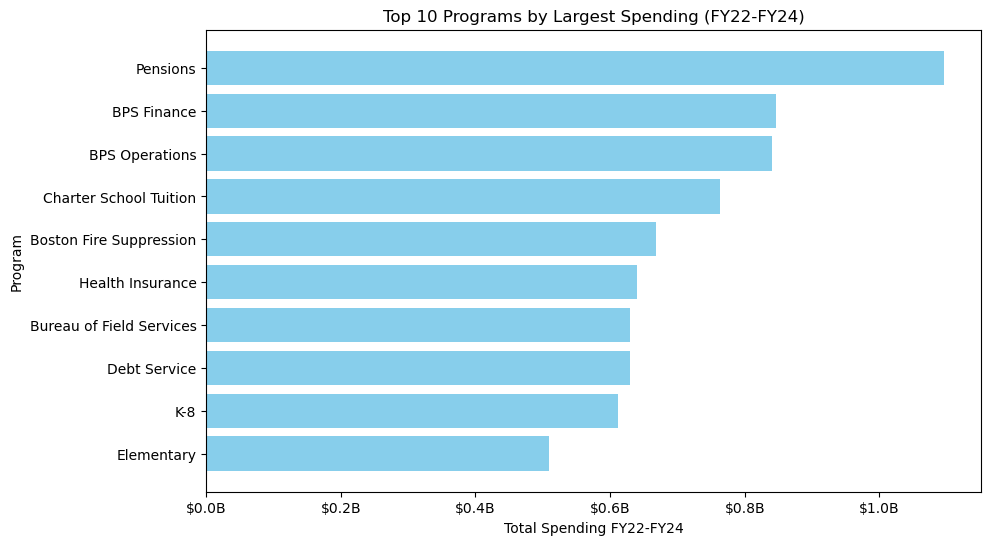

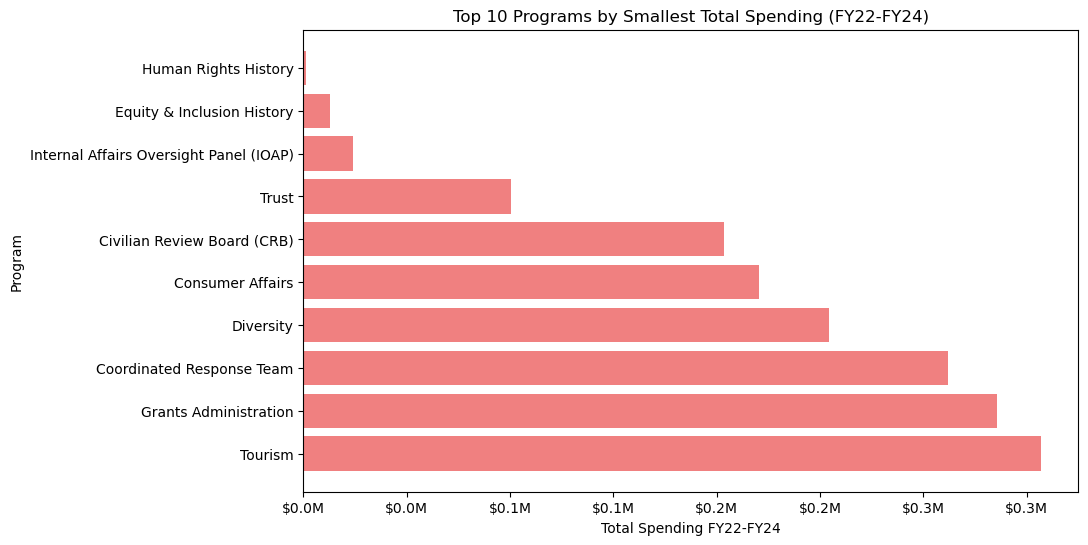

/var/folders/ff/22z5c2zx3x75979ph3jgq4400000gn/T/ipykernel_12702/92535360.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spending_per_year_nonzero['Percentage Growth (FY22-FY24)'] = (


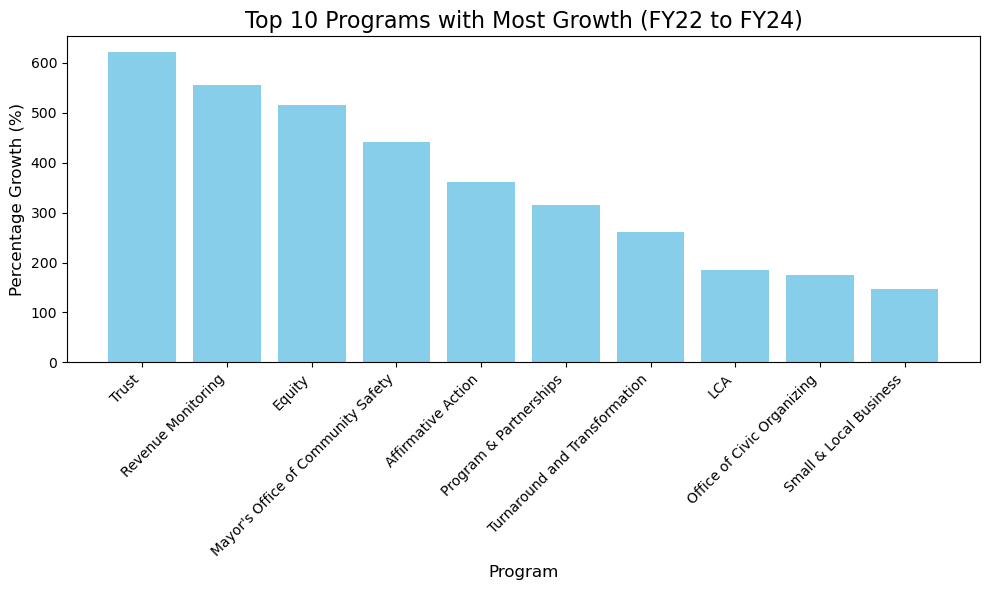

/var/folders/ff/22z5c2zx3x75979ph3jgq4400000gn/T/ipykernel_12702/92535360.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_aggregated['Spending'].replace(0, pd.NA, inplace=True)


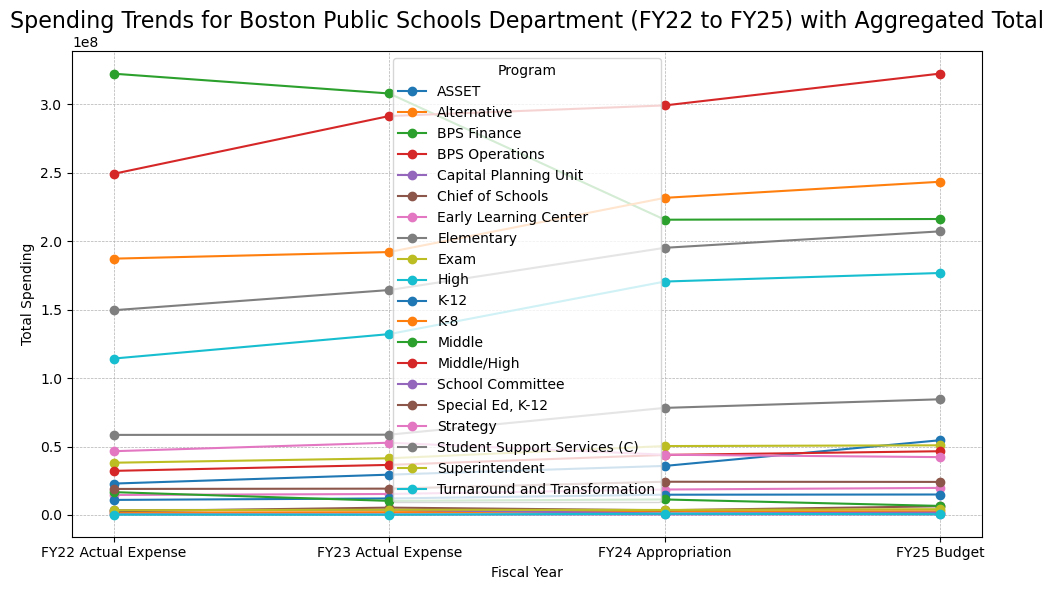

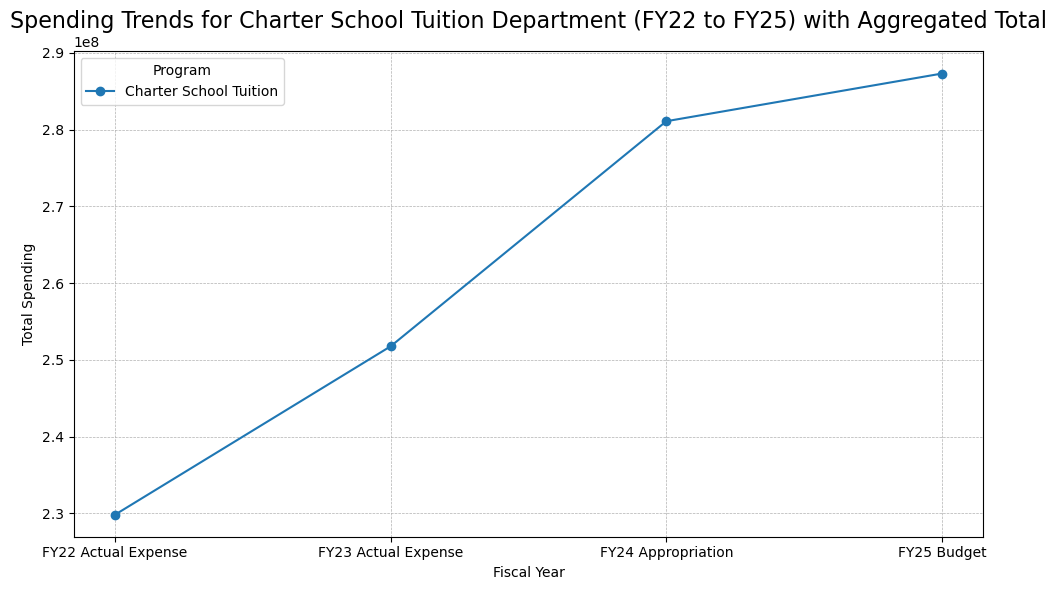

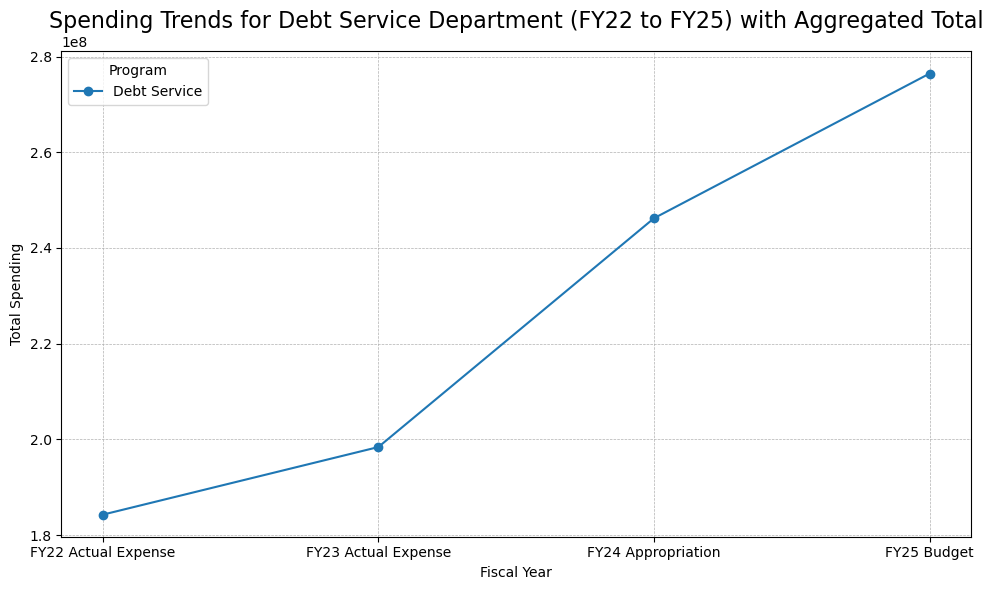

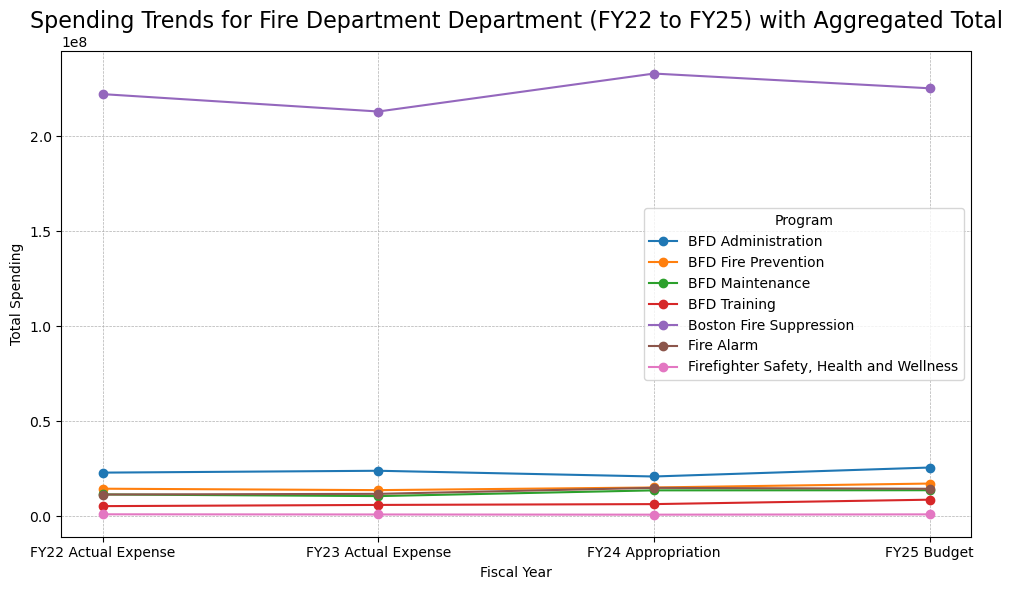

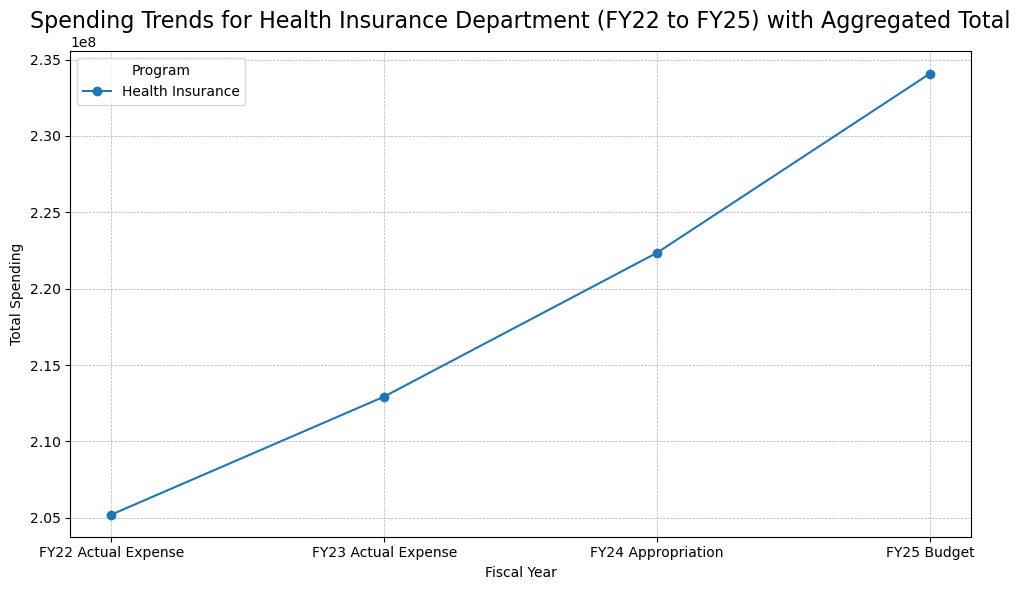

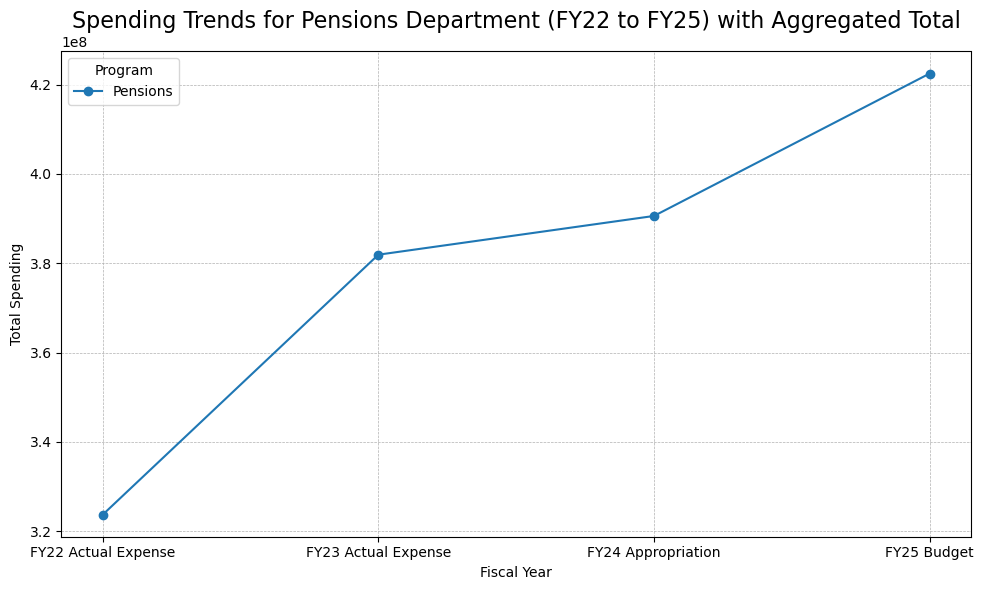

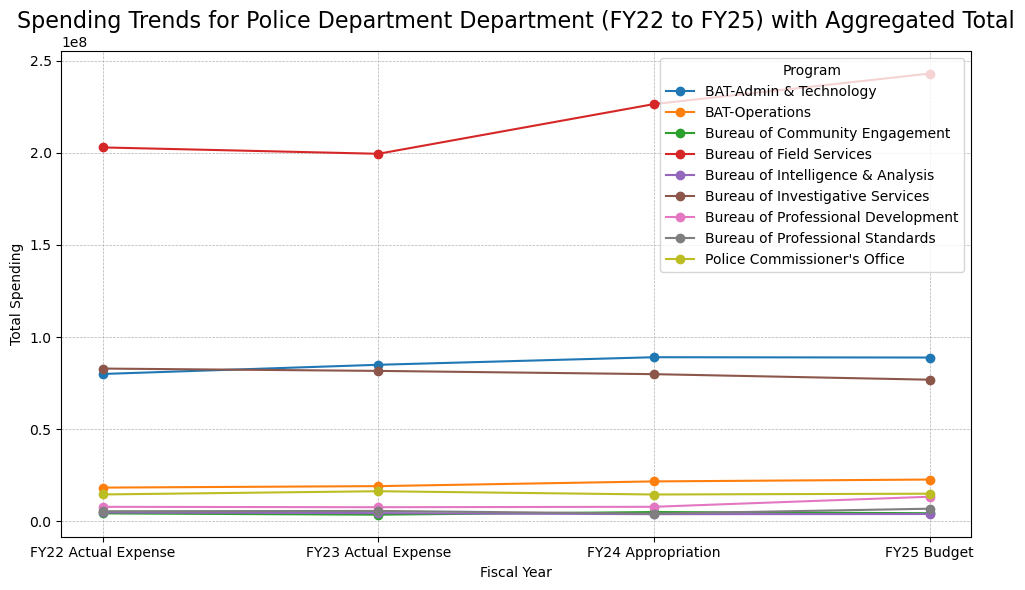

In [14]:
# Calculate total spending for each fiscal year
total_fy22 = operating_budget['FY22 Actual Expense'].sum()
total_fy23 = operating_budget['FY23 Actual Expense'].sum()
total_fy24 = operating_budget['FY24 Appropriation'].sum()
total_budget_25 = operating_budget['FY25 Budget'].sum()

# Calculate percentage growth between fiscal years
growth_fy22_fy23 = ((total_fy23 - total_fy22) / total_fy22) * 100
growth_fy23_fy24 = ((total_fy24 - total_fy23) / total_fy23) * 100
growth_fy24_fy25 = ((total_budget_25 - total_fy24) / total_fy24) * 100

# Calculate average growth across fiscal years
average_growth = (growth_fy22_fy23 + growth_fy23_fy24 + growth_fy24_fy25) / 3

# Display results
print(f"Total Spending FY22: ${total_fy22:,.2f}")
print(f"Total Spending FY23: ${total_fy23:,.2f}")
print(f"Total Spending FY24: ${total_fy24:,.2f}")
print(f"Total Budget FY25: ${total_budget_25:,.2f}")
print(f"Percentage Growth from FY22 to FY23: {growth_fy22_fy23:.2f}%")
print(f"Percentage Growth from FY23 to FY24: {growth_fy23_fy24:.2f}%")
print(f"Percentage Growth from FY24 to FY25: {growth_fy24_fy25:.2f}%")
print(f"Average Growth Across All Programs: {average_growth:.2f}%\n")

# Calculate total spending per program for FY22-FY24
operating_budget['Total Spending FY22-FY24'] = (
    operating_budget['FY22 Actual Expense'] +
    operating_budget['FY23 Actual Expense'] +
    operating_budget['FY24 Appropriation']
)
total_spending_per_program = operating_budget.groupby('Program')['Total Spending FY22-FY24'].sum().reset_index()

# Display top 10 programs by largest spending (FY22-FY24)
top_10_spenders = total_spending_per_program.nlargest(10, 'Total Spending FY22-FY24')
print(top_10_spenders)

# Plotting top 10 programs by spending
def billions(x, pos):
    return f'${x * 1e-9:.1f}B'

plt.figure(figsize=(10, 6))
plt.barh(top_10_spenders['Program'], top_10_spenders['Total Spending FY22-FY24'], color='skyblue')
plt.xlabel('Total Spending FY22-FY24')
plt.ylabel('Program')
plt.title('Top 10 Programs by Largest Spending (FY22-FY24)')
plt.gca().xaxis.set_major_formatter(FuncFormatter(billions))
plt.gca().invert_yaxis()
plt.show()

# Remove programs with zero total spending and find the 10 smallest spenders
total_spending_per_program = total_spending_per_program[total_spending_per_program['Total Spending FY22-FY24'] != 0]
smallest_10_spenders = total_spending_per_program.nsmallest(10, 'Total Spending FY22-FY24')

# Plotting smallest 10 programs by spending
def millions(x, pos):
    return f'${x * 1e-6:.1f}M'

plt.figure(figsize=(10, 6))
plt.barh(smallest_10_spenders['Program'], smallest_10_spenders['Total Spending FY22-FY24'], color='lightcoral')
plt.xlabel('Total Spending FY22-FY24')
plt.ylabel('Program')
plt.title('Top 10 Programs by Smallest Total Spending (FY22-FY24)')
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().invert_yaxis()
plt.show()

# Calculate and display programs with highest percentage growth from FY22 to FY24
spending_per_year = operating_budget.groupby('Program')[['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation']].sum().reset_index()
spending_per_year['Absolute Growth (FY22-FY24)'] = spending_per_year['FY24 Appropriation'] - spending_per_year['FY22 Actual Expense']
spending_per_year_nonzero = spending_per_year[spending_per_year['FY22 Actual Expense'] > 0]
spending_per_year_nonzero['Percentage Growth (FY22-FY24)'] = (
    (spending_per_year_nonzero['Absolute Growth (FY22-FY24)'] / spending_per_year_nonzero['FY22 Actual Expense']) * 100
)
most_growth_programs = spending_per_year_nonzero.nlargest(10, 'Percentage Growth (FY22-FY24)')

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    most_growth_programs['Program'],
    most_growth_programs['Percentage Growth (FY22-FY24)'],
    color='skyblue'
)

# Set titles and labels
plt.title('Top 10 Programs with Most Growth (FY22 to FY24)', fontsize=16)
plt.xlabel('Program', fontsize=12)
plt.ylabel('Percentage Growth (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate program names for readability
plt.tight_layout()
plt.show()

# List of specified departments, particularly department with top 10 spending
selected_departments = [
    'Boston Public Schools', 'Charter School Tuition', 'Pensions', 'Debt Service',
    'Fire Department', 'Health Insurance',
    'Boston Fire Department', 'Police Department'
]

df_spending = operating_budget[['Dept', 'Program', 'FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation', 'FY25 Budget']]
df_spending_long = df_spending.melt(
    id_vars=['Dept', 'Program'],
    value_vars=['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation', 'FY25 Budget'],
    var_name='Fiscal Year',
    value_name='Spending'
)
df_aggregated = df_spending_long.groupby(['Dept', 'Program', 'Fiscal Year'], as_index=False).agg({'Spending': 'sum'})
df_aggregated['Spending'].replace(0, pd.NA, inplace=True)
df_aggregated.dropna(subset=['Spending'], inplace=True)

# Filter the DataFrame for the selected departments
df_selected = df_aggregated[df_aggregated['Dept'].isin(selected_departments)]

# Loop through each selected department and create a line plot
for department in df_selected['Dept'].unique():
    df_department = df_selected[df_selected['Dept'] == department]
    # Initialize the plot
    plt.figure(figsize=(10, 6))
    plt.title(f'Spending Trends for {department} Department (FY22 to FY25) with Aggregated Total', fontsize=16)
    plt.xlabel('Fiscal Year')
    plt.ylabel('Total Spending')

    # Plot each program within the department
    for program in df_department['Program'].unique():
        df_program = df_department[df_department['Program'] == program]
        plt.plot(
            df_program['Fiscal Year'],
            df_program['Spending'],
            marker='o',
            label=program
        )

    # Customize and display the plot
    plt.legend(title='Program')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

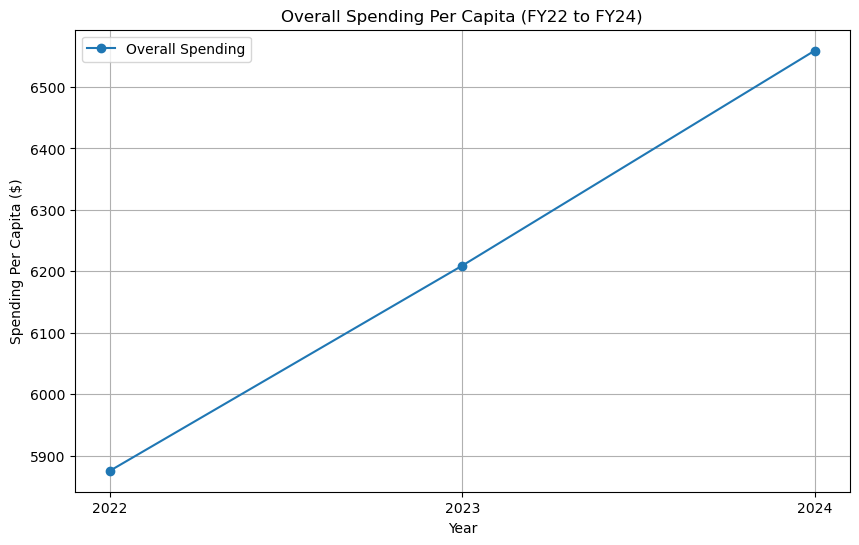

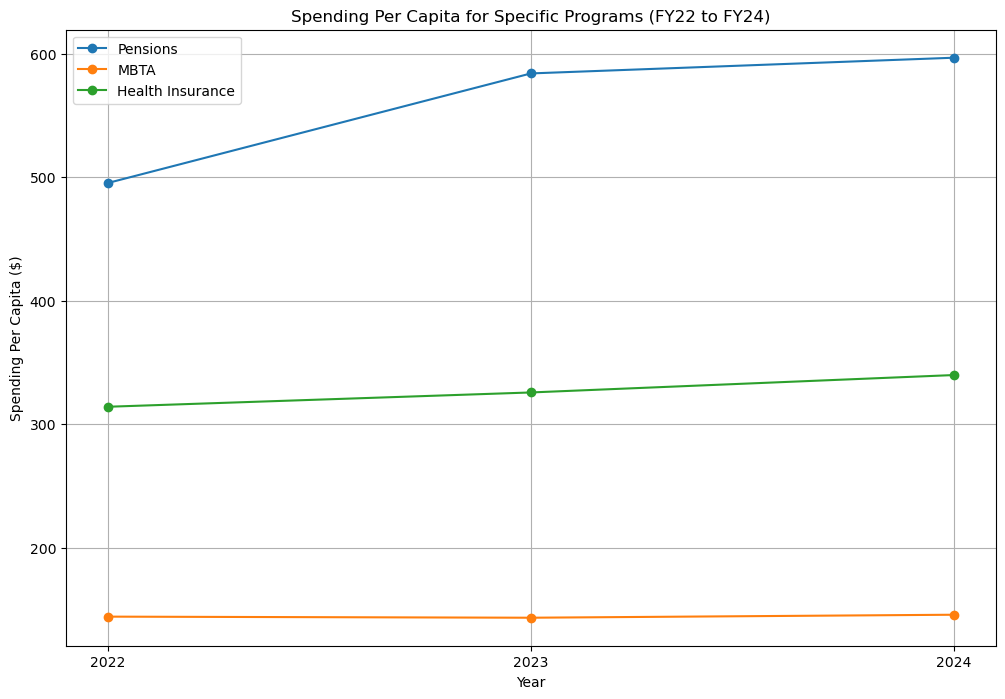

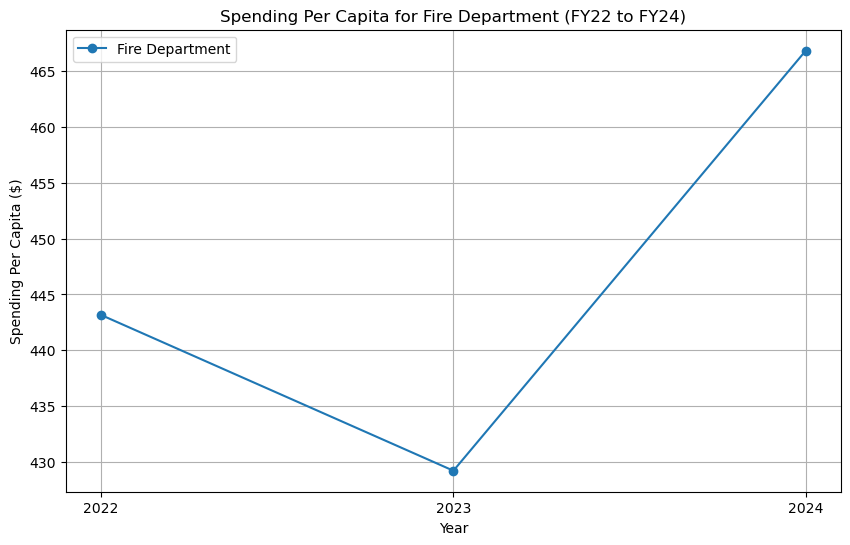

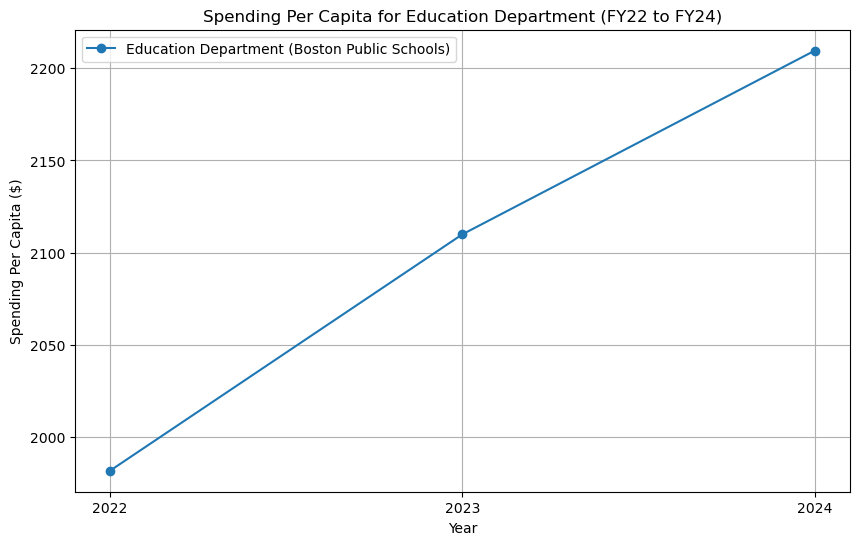

In [16]:
# Define years and population
years = ['2022', '2023', '2024']
population = [653300, 653800, 654400]

# Calculate total spending per capita for each year across all programs
total_spending = [operating_budget['FY22 Actual Expense'].sum(),
                  operating_budget['FY23 Actual Expense'].sum(),
                  operating_budget['FY24 Appropriation'].sum()]
per_capita_spending = [total_spending[i] / population[i] for i in range(3)]

# Plot overall per capita spending for all programs
plt.figure(figsize=(10, 6))
plt.plot(years, per_capita_spending, marker='o', label="Overall Spending")
plt.title("Overall Spending Per Capita (FY22 to FY24)")
plt.xlabel("Year")
plt.ylabel("Spending Per Capita ($)")
plt.grid()
plt.legend()
plt.show()

# Function to calculate and plot per capita spending for a specific program
def plot_per_capita(program_name, population_data):
    program_data = operating_budget[operating_budget['Program'] == program_name]
    program_summary = program_data[['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation']].sum()
    per_capita_spending = [program_summary[year] / population_data[i] for i, year in enumerate(['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation'])]

    plt.plot(years, per_capita_spending, marker='o', label=program_name)

# Plot per capita spending for specific programs
plt.figure(figsize=(12, 8))
plot_per_capita("Pensions", population)
plot_per_capita("MBTA", population)
plot_per_capita("Health Insurance", population)
plt.title("Spending Per Capita for Specific Programs (FY22 to FY24)")
plt.xlabel("Year")
plt.ylabel("Spending Per Capita ($)")
plt.legend()
plt.grid()
plt.show()

# Plot per capita spending for Fire Department
fire_department_data = operating_budget[operating_budget['Dept'] == 'Fire Department']
fire_department_summary = fire_department_data[['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation']].sum()
fire_per_capita_spending = [fire_department_summary[year] / population[i] for i, year in enumerate(['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation'])]

plt.figure(figsize=(10, 6))
plt.plot(years, fire_per_capita_spending, marker='o', label="Fire Department")
plt.title("Spending Per Capita for Fire Department (FY22 to FY24)")
plt.xlabel("Year")
plt.ylabel("Spending Per Capita ($)")
plt.legend()
plt.grid()
plt.show()


# Plot per capita spending for Education Department (Boston Public Schools)
school_data = operating_budget[operating_budget['Dept'] == 'Boston Public Schools']
school_summary = school_data[['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation']].sum()
school_per_capita_spending = [school_summary[year] / population[i] for i, year in enumerate(['FY22 Actual Expense', 'FY23 Actual Expense', 'FY24 Appropriation'])]

plt.figure(figsize=(10, 6))
plt.plot(years, school_per_capita_spending, marker='o', label="Education Department (Boston Public Schools)")
plt.title("Spending Per Capita for Education Department (FY22 to FY24)")
plt.xlabel("Year")
plt.ylabel("Spending Per Capita ($)")
plt.legend()
plt.grid()
plt.show()


# Capital Budget

In [22]:
capital_budget = pd.read_csv('./data/FY25_Capital.csv')
capital_budget.head()

_id                             Department  \
0    1  Boston Centers for Youth and Families   
1    2  Boston Centers for Youth and Families   
2    3  Boston Centers for Youth and Families   
3    4  Boston Centers for Youth and Families   
4    5  Boston Centers for Youth and Families   

                                 Project_Name  \
0       BCYF Security and Technology Upgrades   
1  BCYF Tobin Community Center Retaining Wall   
2             BCYF North End Community Center   
3                                Pool Repairs   
4                        Youth Budget Round 4   

                                       Scope_Of_Work  \
0  Improvements to technology infrastructure and ...   
1  Repair or replace the retaining wall adjacent ...   
2  Design and construct a new North End Community...   
3  Renovate and upgrade locker rooms and pools in...   
4  Engage youth across the City using participato...   

                           PM_Department           Project_Status  \
0  Boston Centers for Youth and Families          To Be Scheduled   
1           Public Facilities Department                In Design   
2           Public Facilities Department                In Design   
3  Boston Centers for Youth and Families           Annual Program   
4       Youth Engagement and Advancement  Implementation Underway   

   Neighborhood  Authorization_Existing  Authorization_FY  \
0      Citywide                 2000000                 0   
1  Mission Hill                 1800000                 0   
2     North End                68000000                 0   
3      Citywide                 2300000           2700000   
4      Citywide                 1000000                 0   

   Authorization_Future  ...  GO_Expended  Capital_Year_0  CapitalYear_1  \
0                     0  ...          0.0               0              0   
1                     0  ...      84629.0          139188         400000   
2                     0  ...       9500.0         1000000        2000000   
3                     0  ...     886590.0          500000        1000000   
4                     0  ...      28500.0           13815              0   

   Capital_Year_25  Grant_Expended  Grant_Year_0  Grant_Year_1  GrantYear_25  \
0        2000000.0             0.0             0             0           0.0   
1        1176183.0             0.0             0             0           0.0   
2       64990500.0             0.0             0             0           0.0   
3        2613410.0             0.0             0             0           0.0   
4         957685.0             0.0             0             0           0.0   

   External_Funds  Total_Project_Budget  
0               0               2000000  
1               0               1800000  
2        20000000              88000000  
3               0               5000000  
4               0               1000000  

[5 rows x 23 columns]

In [24]:
# Define the population data as per your specifications, combining Allston and Brighton, and Fenway and Longwood
population_data = {
    "Neighborhood": [
        "Citywide", "Allston/Brighton", "Back Bay", "Beacon Hill", "Charlestown",
        "Chinatown", "Dorchester", "Downtown/Government Center", "East Boston", "Fenway-Kenmore",
        "Hyde Park", "Jamaica Plain", "Mattapan", "Mission Hill",
        "North End", "Roslindale", "Roxbury", "South Boston",
        "South Boston Waterfront", "South End", "West End", "West Roxbury"
    ],
    "Population": [
        675647, 76951, 18190, 9336, 19120, 6211, 122191, 13768, 43066,
        42679,  # Combined Fenway (37493) + Longwood (5186)
        34172, 40015, 23840, 17518, 10805, 29586, 54533, 37917,
        5579, 30904, 7705, 31561
    ]
}

# Convert the dictionary to a DataFrame
population_df = pd.DataFrame(population_data)

# Display the updated DataFrame
population_df.sort_values(by="Population", ascending = False)

Neighborhood  Population
0                     Citywide      675647
6                   Dorchester      122191
1             Allston/Brighton       76951
16                     Roxbury       54533
8                  East Boston       43066
9               Fenway-Kenmore       42679
11               Jamaica Plain       40015
17                South Boston       37917
10                   Hyde Park       34172
21                West Roxbury       31561
19                   South End       30904
15                  Roslindale       29586
12                    Mattapan       23840
4                  Charlestown       19120
2                     Back Bay       18190
13                Mission Hill       17518
7   Downtown/Government Center       13768
14                   North End       10805
3                  Beacon Hill        9336
20                    West End        7705
5                    Chinatown        6211
18     South Boston Waterfront        5579

In [26]:
# Aggregating the total project budget by neighborhood in the capital budget dataset
neighborhood_budget = capital_budget.groupby("Neighborhood")["Total_Project_Budget"].sum().reset_index()

# Merging the capital budget allocation with the updated population data
merged_df = pd.merge(neighborhood_budget, population_df, on="Neighborhood", how="left")

# Calculating budget per capita (project allocation divided by population) for comparison
merged_df["Budget_Per_Capita"] = merged_df["Total_Project_Budget"] / merged_df["Population"]

# Sorting by Budget_Per_Capita for analysis and displaying the result
merged_df_sorted = merged_df.sort_values(by="Budget_Per_Capita", ascending=False)

# Display the merged DataFrame with Total Project Budget, Population, and Budget Per Capita for each neighborhood
merged_df_sorted

Neighborhood  Total_Project_Budget  Population  \
5                    Chinatown             273772172      6211.0   
4                  Charlestown             599378839     19120.0   
8   Downtown/Government Center             328205000     13768.0   
17                   North End              95509959     10805.0   
21                   South End             181715235     30904.0   
19                     Roxbury             312782325     54533.0   
20                South Boston             203499965     37917.0   
14                    Mattapan             115606311     23840.0   
1                     Back Bay              81305000     18190.0   
3                  Beacon Hill              34410000      9336.0   
18                  Roslindale             102320000     29586.0   
22                    West End              24000000      7705.0   
13               Jamaica Plain              83940000     40015.0   
7                   Dorchester             249679178    122191.0   
6                     Citywide            1334651759    675647.0   
23                West Roxbury              38435000     31561.0   
9                  East Boston              51819000     43066.0   
0             Allston/Brighton              46692900     76951.0   
10              Fenway-Kenmore              24916351     42679.0   
15                Mission Hill               5292212     17518.0   
12                   Hyde Park               7545000     34172.0   
2                  Bay Village               1525000         NaN   
11              Harbor Islands             171778144         NaN   
16      Multiple Neighborhoods             324892449         NaN   

    Budget_Per_Capita  
5        44078.597971  
4        31348.265638  
8        23838.248112  
17        8839.422397  
21        5879.990778  
19        5735.652266  
20        5366.984862  
14        4849.258012  
1         4469.763606  
3         3685.732648  
18        3458.392483  
22        3114.860480  
13        2097.713357  
7         2043.351622  
6         1975.368438  
23        1217.800450  
9         1203.246180  
0          606.787436  
10         583.808219  
15         302.101381  
12         220.794803  
2                 NaN  
11                NaN  
16                NaN

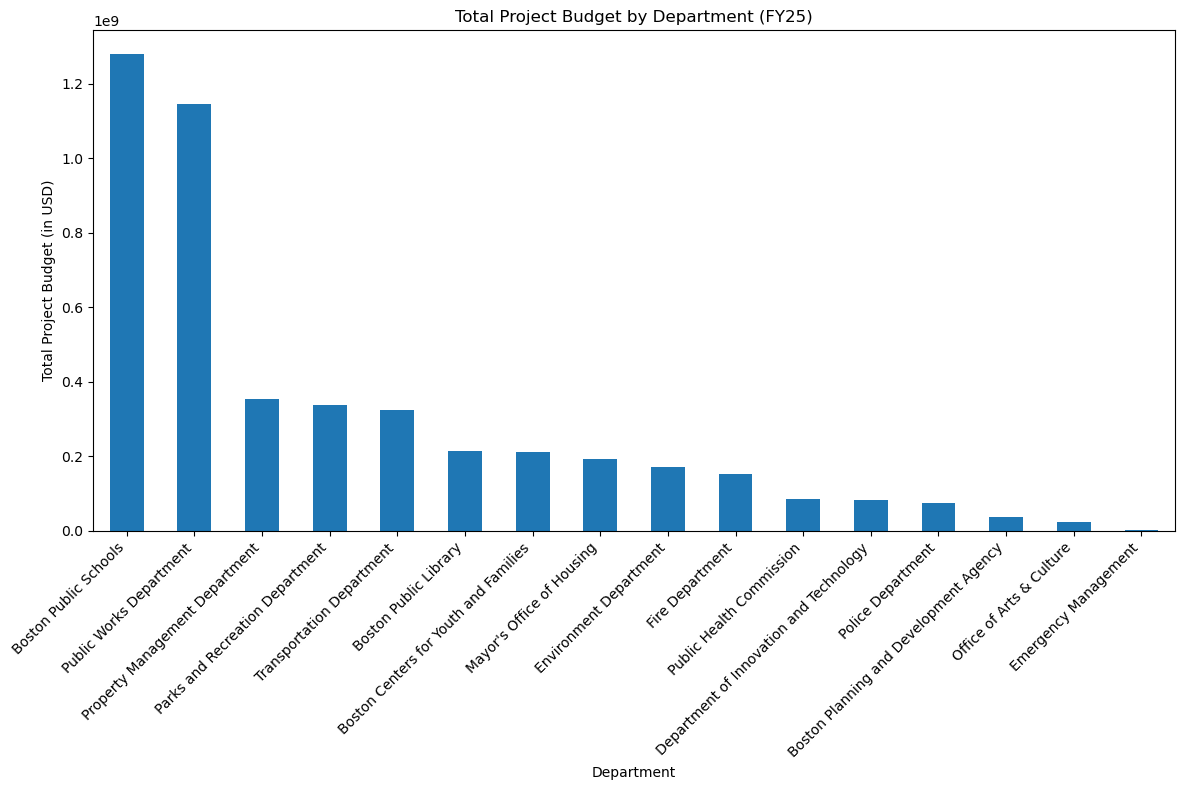

In [28]:
# Visualization 1: Total Project Budget by Department
dept_total_budget = capital_budget.groupby("Department")["Total_Project_Budget"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
dept_total_budget.plot(kind='bar')
plt.title("Total Project Budget by Department (FY25)")
plt.xlabel("Department")
plt.ylabel("Total Project Budget (in USD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

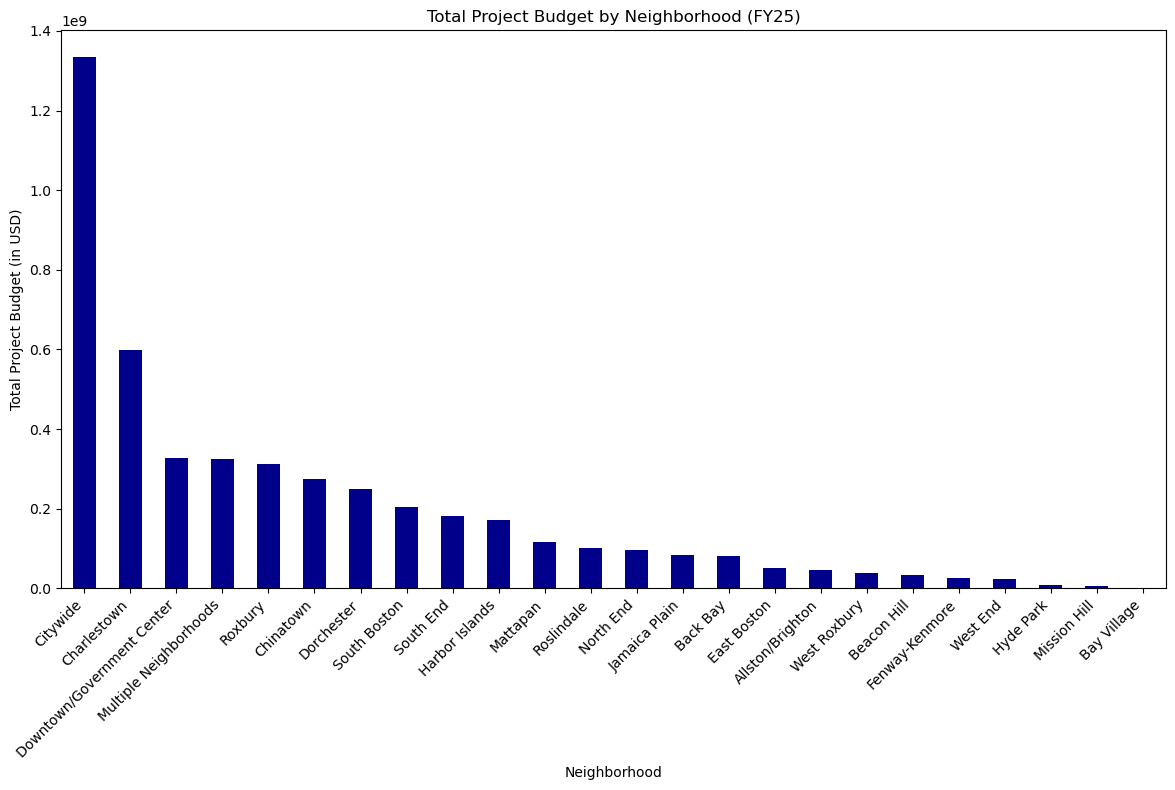

In [30]:
# Visualization 2: Neighborhood-Specific Spending
neighborhood_budget = capital_budget.groupby("Neighborhood")["Total_Project_Budget"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
neighborhood_budget.plot(kind='bar', color="darkblue")
plt.title("Total Project Budget by Neighborhood (FY25)")
plt.xlabel("Neighborhood")
plt.ylabel("Total Project Budget (in USD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [32]:
unique_neighborhoods = capital_budget['Neighborhood'].unique()
unique_neighborhoods

array(['Citywide', 'Mission Hill', 'North End', 'Hyde Park', 'Roslindale',
       'Allston/Brighton', 'Dorchester', 'Charlestown', 'South Boston',
       'Downtown/Government Center', 'Harbor Islands', 'Roxbury',
       'Mattapan', 'Back Bay', 'Chinatown', 'South End', 'West End',
       'Jamaica Plain', 'Multiple Neighborhoods', 'Bay Village',
       'Fenway-Kenmore', 'West Roxbury', 'Beacon Hill', 'East Boston'],
      dtype=object)

In [34]:
# Aggregating the total project budget by neighborhood
neighborhood_budget = capital_budget.groupby("Neighborhood")["Total_Project_Budget"].sum().reset_index()

# Merging the capital budget allocation with population data
merged_df = pd.merge(neighborhood_budget, population_df, on="Neighborhood", how="left")

# Calculating budget per capita (project allocation divided by population) for comparison
merged_df["Budget_Per_Capita"] = merged_df["Total_Project_Budget"] / merged_df["Population"]

# Sorting by Budget_Per_Capita for analysis
merged_df_sorted = merged_df.sort_values(by="Budget_Per_Capita", ascending=False)

# Display the merged DataFrame with Total Project Budget, Population, and Budget Per Capita for each neighborhood
print(merged_df_sorted)


                  Neighborhood  Total_Project_Budget  Population  \
5                    Chinatown             273772172      6211.0   
4                  Charlestown             599378839     19120.0   
8   Downtown/Government Center             328205000     13768.0   
17                   North End              95509959     10805.0   
21                   South End             181715235     30904.0   
19                     Roxbury             312782325     54533.0   
20                South Boston             203499965     37917.0   
14                    Mattapan             115606311     23840.0   
1                     Back Bay              81305000     18190.0   
3                  Beacon Hill              34410000      9336.0   
18                  Roslindale             102320000     29586.0   
22                    West End              24000000      7705.0   
13               Jamaica Plain              83940000     40015.0   
7                   Dorchester             24967

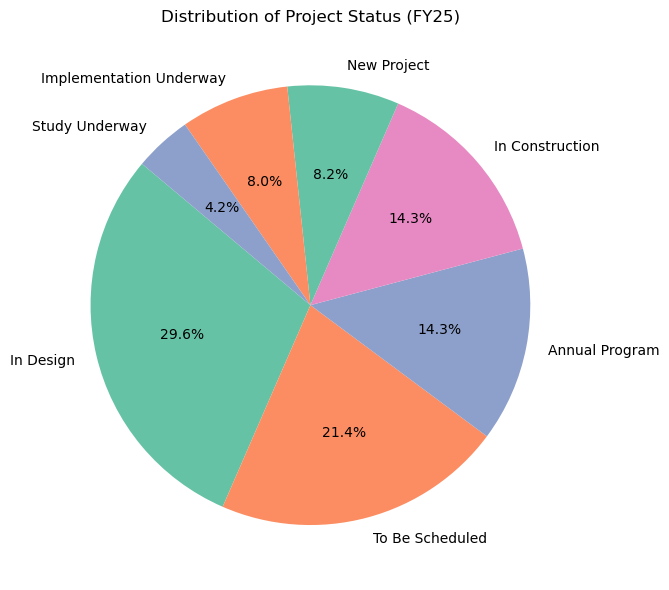

In [36]:
# Visualization 3: Project Status Distribution
project_status_counts = capital_budget["Project_Status"].value_counts()

plt.figure(figsize=(10, 6))
project_status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])
plt.title("Distribution of Project Status (FY25)")
plt.ylabel("")
plt.tight_layout()
plt.show()

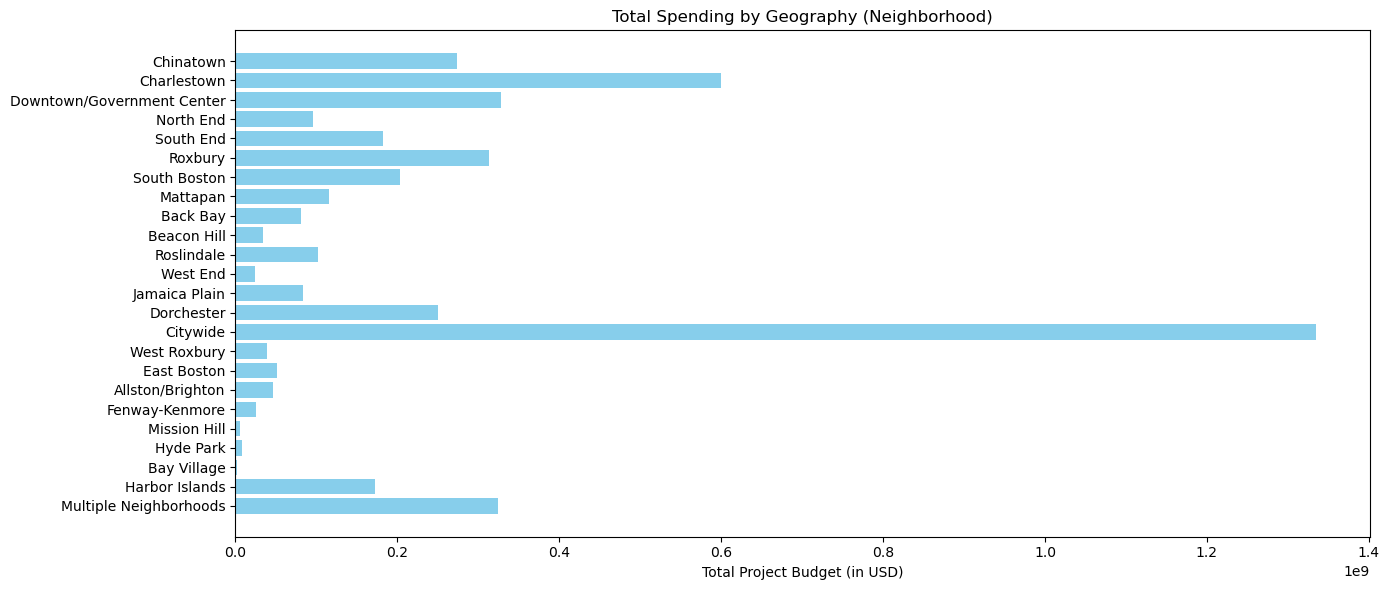

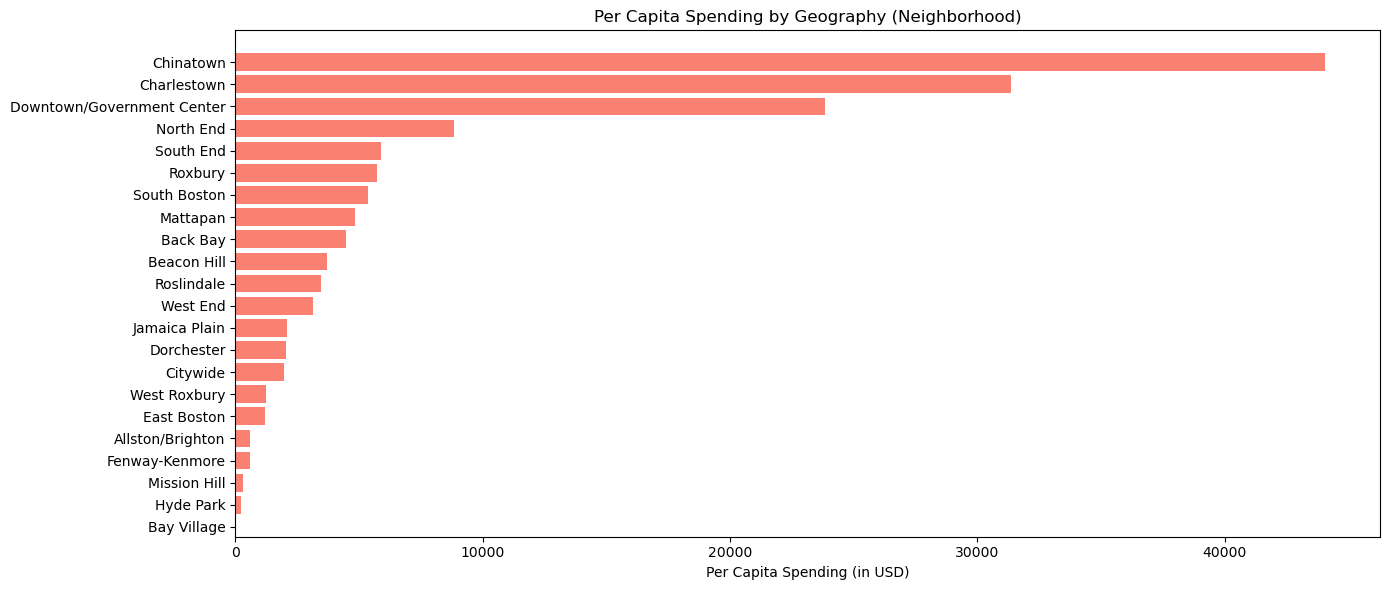

In [38]:
# Visualization 1: Total Spending by Geography
plt.figure(figsize=(14, 6))
plt.barh(merged_df_sorted["Neighborhood"], merged_df_sorted["Total_Project_Budget"], color="skyblue")
plt.xlabel("Total Project Budget (in USD)")
plt.title("Total Spending by Geography (Neighborhood)")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.tight_layout()
plt.show()

# Visualization 2: Per Capita Spending by Geography (Spending per resident in each area)
plt.figure(figsize=(14, 6))
plt.barh(merged_df_sorted["Neighborhood"], merged_df_sorted["Budget_Per_Capita"], color="salmon")
plt.xlabel("Per Capita Spending (in USD)")
plt.title("Per Capita Spending by Geography (Neighborhood)")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.tight_layout()
plt.show()

In [40]:
# Create Immigrant Data
immigrant_data = {
    "Neighborhood": [
        "East Boston", "Chinatown", "Allston", "Fenway", "West End", "Back Bay", "Mission Hill",
        "Downtown", "Dorchester", "Mattapan", "Brighton", "South Boston Waterfront", "Roxbury",
        "Longwood", "South End", "Hyde Park", "Roslindale", "Jamaica Plain", "Beacon Hill",
        "West Roxbury", "Charlestown", "North End", "South Boston"
    ],
    "Immigrant_Percentage": [
        34, 29, 25, 21, 18, 16, 16, 15, 15, 14, 14, 12, 12, 10, 10, 10, 10, 9, 8, 8, 7, 6, 5
    ],
    "Count": [
        16136, 1247, 5858, 7085, 1211, 2957, 2577,
        1908, 18855, 3750, 6913, 502, 6130,
        573, 3179, 3848, 3193, 4031, 752,
        2561, 1429, 647, 1842
    ]
}

# Convert the immigrant data to a DataFrame
immigrant_df = pd.DataFrame(immigrant_data)
immigrant_df

Neighborhood  Immigrant_Percentage  Count
0               East Boston                    34  16136
1                 Chinatown                    29   1247
2                   Allston                    25   5858
3                    Fenway                    21   7085
4                  West End                    18   1211
5                  Back Bay                    16   2957
6              Mission Hill                    16   2577
7                  Downtown                    15   1908
8                Dorchester                    15  18855
9                  Mattapan                    14   3750
10                 Brighton                    14   6913
11  South Boston Waterfront                    12    502
12                  Roxbury                    12   6130
13                 Longwood                    10    573
14                South End                    10   3179
15                Hyde Park                    10   3848
16               Roslindale                    10   3193
17            Jamaica Plain                     9   4031
18              Beacon Hill                     8    752
19             West Roxbury                     8   2561
20              Charlestown                     7   1429
21                North End                     6    647
22             South Boston                     5   1842

In [42]:
# Step 1: Adjust Neighborhood Names in Immigrant Data
name_mapping = {
    "Downtown": "Downtown/Government Center",
    "Fenway": "Fenway-Kenmore",
}

# Rename neighborhoods in the immigrant dataset
immigrant_df["Neighborhood"] = immigrant_df["Neighborhood"].replace(name_mapping)

# Step 2: Combine Allston and Brighton into Allston/Brighton
# Filter rows for Allston and Brighton in the immigrant dataset
allston_brighton_data = immigrant_df[immigrant_df["Neighborhood"].isin(["Allston", "Brighton"])]

# Retrieve the combined population for Allston/Brighton from the merged population and budget dataset
allston_brighton_population = merged_df_sorted.loc[
    merged_df_sorted["Neighborhood"] == "Allston/Brighton", "Population"
].values[0]

# Calculate combined immigrant count
combined_count = allston_brighton_data["Count"].sum()

# Calculate weighted average for immigrant percentage
weighted_avg_percentage = (
    (allston_brighton_data["Immigrant_Percentage"] * allston_brighton_data["Count"]).sum()
    / combined_count
)

# Create a new row for Allston/Brighton
combined_row = pd.DataFrame({
    "Neighborhood": ["Allston/Brighton"],
    "Count": [combined_count],
    "Immigrant_Percentage": [weighted_avg_percentage]
})

# Drop the original Allston and Brighton rows from the immigrant dataset
immigrant_df = immigrant_df[~immigrant_df["Neighborhood"].isin(["Allston", "Brighton"])]

# Append the new Allston/Brighton row to the immigrant dataset
immigrant_df = pd.concat([immigrant_df, combined_row], ignore_index=True)

# Remove rows with NaN values in Count or Immigrant_Percentage
immigrant_df = immigrant_df.dropna(subset=["Count", "Immigrant_Percentage"])

# Step 3: Align with Merged Population and Budget Data
# Filter the immigrant dataset for neighborhoods present in the merged population and budget dataset
matching_neighborhoods = set(merged_df_sorted["Neighborhood"]).intersection(immigrant_df["Neighborhood"])

# Filter both datasets to include only matching neighborhoods
filtered_merged_df = merged_df_sorted[merged_df_sorted["Neighborhood"].isin(matching_neighborhoods)]
filtered_immigrant_df = immigrant_df[immigrant_df["Neighborhood"].isin(matching_neighborhoods)]

# Step 4: Merge Datasets
# Merge the filtered population, budget, and immigrant datasets
final_merged_df = pd.merge(filtered_merged_df, filtered_immigrant_df, on="Neighborhood", how="inner")

# Step 5: Select Relevant Columns
# Keep only the necessary columns for analysis
final_merged_df = final_merged_df[[
    "Neighborhood", "Population", "Immigrant_Percentage", "Total_Project_Budget", "Budget_Per_Capita"
]]

# Display the final merged DataFrame
print(final_merged_df)


                  Neighborhood  Population  Immigrant_Percentage  \
0                    Chinatown      6211.0              29.00000   
1                  Charlestown     19120.0               7.00000   
2   Downtown/Government Center     13768.0              15.00000   
3                    North End     10805.0               6.00000   
4                    South End     30904.0              10.00000   
5                      Roxbury     54533.0              12.00000   
6                 South Boston     37917.0               5.00000   
7                     Mattapan     23840.0              14.00000   
8                     Back Bay     18190.0              16.00000   
9                  Beacon Hill      9336.0               8.00000   
10                  Roslindale     29586.0              10.00000   
11                    West End      7705.0              18.00000   
12               Jamaica Plain     40015.0               9.00000   
13                  Dorchester    122191.0      

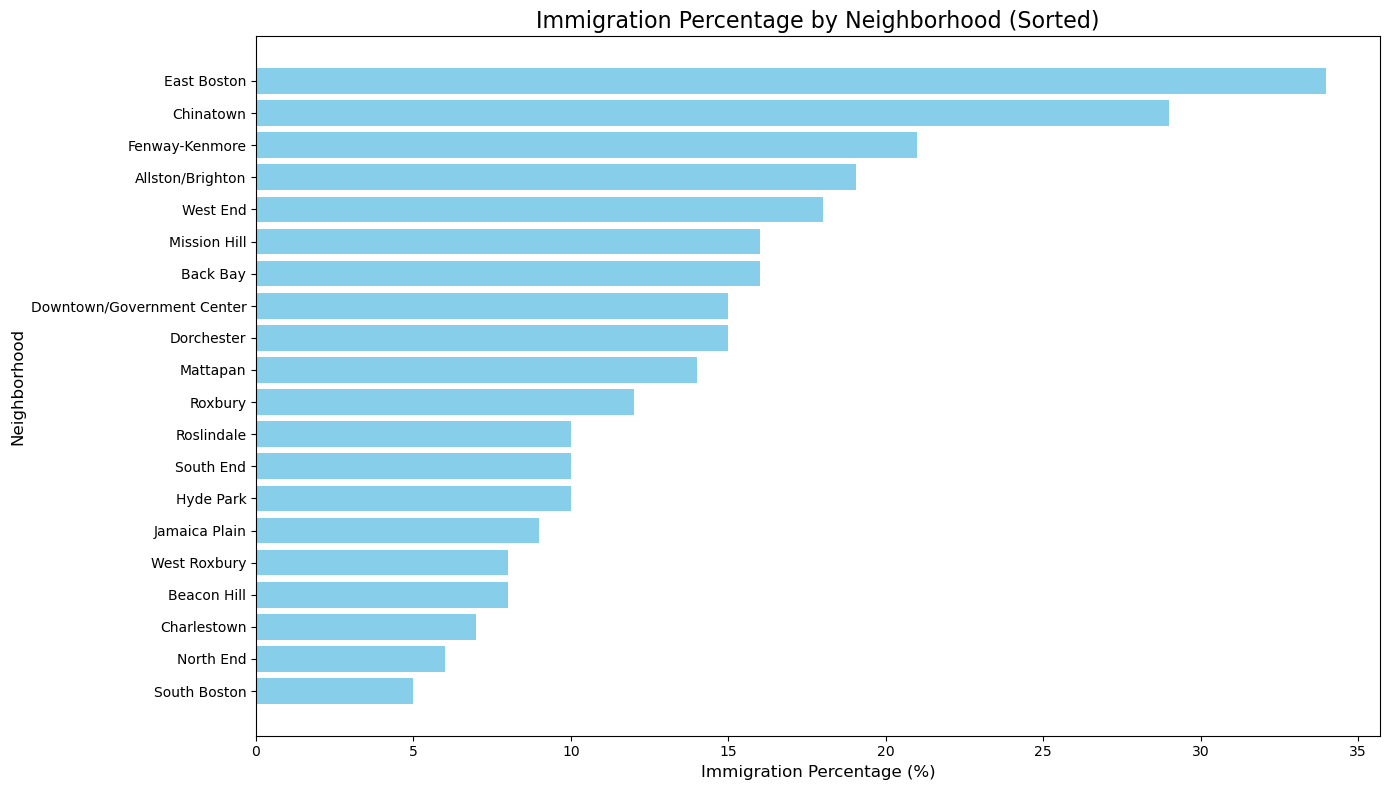

In [44]:
# Visualization 1: Bar Plot - Sorted Immigration Percentage by Neighborhood
sorted_final_merged_df = final_merged_df.sort_values(by="Immigrant_Percentage", ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(sorted_final_merged_df["Neighborhood"], sorted_final_merged_df["Immigrant_Percentage"], color="skyblue")
plt.xlabel("Immigration Percentage (%)", fontsize=12)
plt.ylabel("Neighborhood", fontsize=12)
plt.title("Immigration Percentage by Neighborhood (Sorted)", fontsize=16)
plt.gca().invert_yaxis()  # Ensure neighborhoods are ordered top-down
plt.tight_layout()
plt.show()

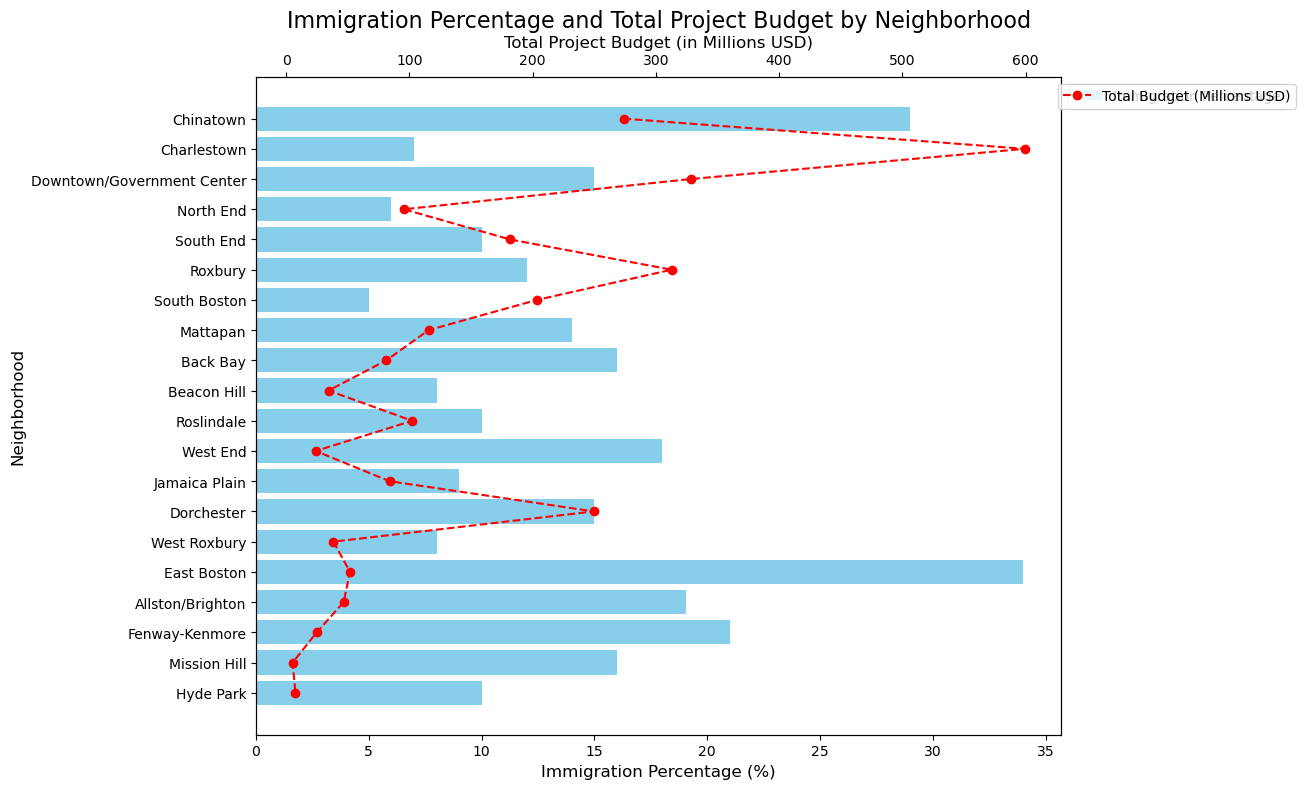

In [46]:
# Visualization 2
# Bar plot: Immigration Percentage and Total Project Budget by Neighborhood
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Immigration Percentage
ax1.barh(final_merged_df["Neighborhood"], final_merged_df["Immigrant_Percentage"], color="skyblue", label="Immigration Percentage")
ax1.set_xlabel("Immigration Percentage (%)", fontsize=12)
ax1.set_ylabel("Neighborhood", fontsize=12)
ax1.set_title("Immigration Percentage and Total Project Budget by Neighborhood", fontsize=16)
ax1.invert_yaxis()  # Ensure the y-axis is readable

# Create a twin axis for Total Project Budget
ax2 = ax1.twiny()
ax2.plot(final_merged_df["Total_Project_Budget"] / 1e6, final_merged_df["Neighborhood"], 'r--o', label="Total Budget (Millions USD)")
ax2.set_xlabel("Total Project Budget (in Millions USD)", fontsize=12)

# Add legends
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
ax2.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=10)

plt.tight_layout()
plt.show()


# 2025 - 2029 Budget Plan by Department

In [48]:
data_directory = './data'
df = pd.read_csv(os.path.join(data_directory, 'FY25_Capital.csv')).fillna(0)

In [50]:
print(df.head())

   _id                             Department  \
0    1  Boston Centers for Youth and Families   
1    2  Boston Centers for Youth and Families   
2    3  Boston Centers for Youth and Families   
3    4  Boston Centers for Youth and Families   
4    5  Boston Centers for Youth and Families   

                                 Project_Name  \
0       BCYF Security and Technology Upgrades   
1  BCYF Tobin Community Center Retaining Wall   
2             BCYF North End Community Center   
3                                Pool Repairs   
4                        Youth Budget Round 4   

                                       Scope_Of_Work  \
0  Improvements to technology infrastructure and ...   
1  Repair or replace the retaining wall adjacent ...   
2  Design and construct a new North End Community...   
3  Renovate and upgrade locker rooms and pools in...   
4  Engage youth across the City using participato...   

                           PM_Department           Project_Status  \
0  B

In [52]:
print(df['Total_Project_Budget'].describe())

count    4.260000e+02
mean     1.101801e+07
std      2.533627e+07
min      5.000000e+04
25%      1.000000e+06
50%      2.387500e+06
75%      9.000000e+06
max      2.235915e+08
Name: Total_Project_Budget, dtype: float64


In [54]:
project_count_per_department = df['Department'].value_counts().reset_index()
project_count_per_department.columns = ['Department', 'Project_Count']
print(project_count_per_department)

                                 Department  Project_Count
0           Parks and Recreation Department             98
1                     Boston Public Schools             72
2                   Public Works Department             64
3                 Transportation Department             50
4                           Fire Department             23
5     Boston Centers for Youth and Families             17
6                     Boston Public Library             15
7                         Police Department             15
8            Property Management Department             14
9                    Environment Department             12
10                 Public Health Commission             11
11   Boston Planning and Development Agency             10
12  Department of Innovation and Technology              9
13                 Office of Arts & Culture              8
14                Mayor's Office of Housing              7
15                     Emergency Management             

In [56]:
budget_range_per_department = df.groupby('Department')['Total_Project_Budget'].agg(['min', 'max']).reset_index()
print(budget_range_per_department)

                                 Department      min        max
0     Boston Centers for Youth and Families  1000000   88000000
1    Boston Planning and Development Agency   500000    7900000
2                     Boston Public Library   250000   50000000
3                     Boston Public Schools    50000  223591467
4   Department of Innovation and Technology   650000   27000000
5                      Emergency Management  1500000    1500000
6                    Environment Department   350000   75000000
7                           Fire Department   360000   46000000
8                 Mayor's Office of Housing  4000000   52000000
9                  Office of Arts & Culture   100000   22350000
10          Parks and Recreation Department    50000   50346965
11                        Police Department    60000   53794000
12           Property Management Department   500000  165000000
13                 Public Health Commission   200000   38220000
14                  Public Works Departm

In [58]:
total_budget_fy25 = df['Total_Project_Budget'].sum()
print(f"Total FY25 Capital Budget: ${total_budget_fy25 / 1e9:.2f} billion")

Total FY25 Capital Budget: $4.69 billion


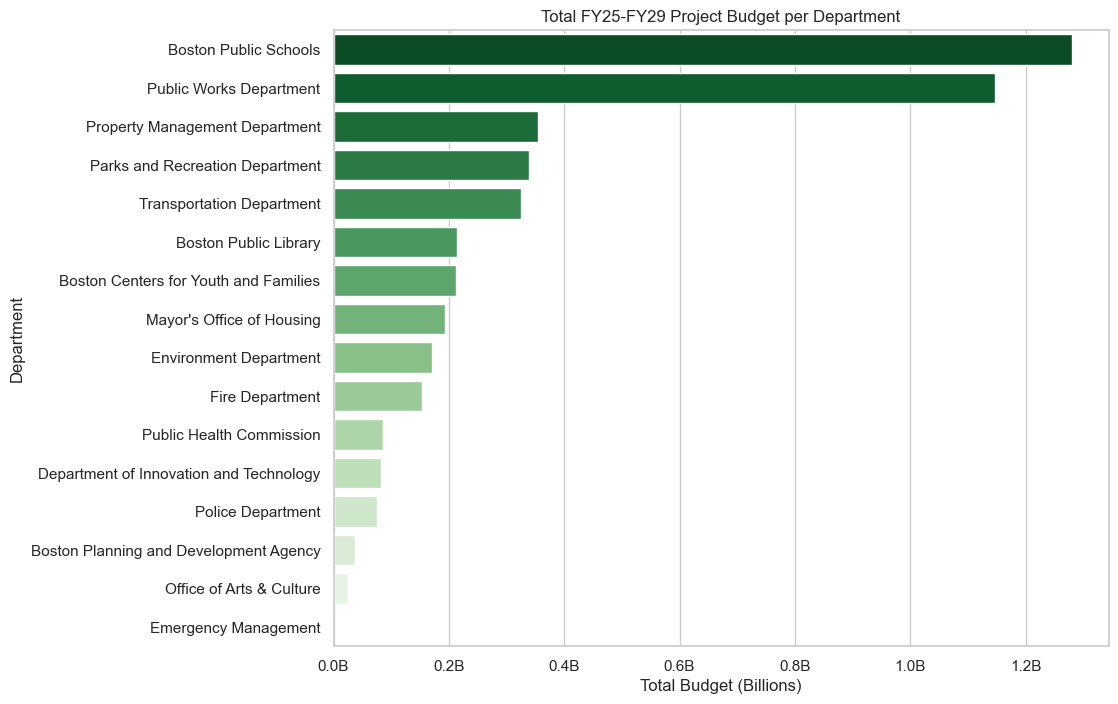

In [60]:
# Aggregate the total project budget by department
budget_per_department = df.groupby('Department')['Total_Project_Budget'].sum().reset_index()

# Sort values for a cleaner plot
budget_per_department = budget_per_department.sort_values(by='Total_Project_Budget', ascending=False)

# Set the plot style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create the barplot with 'hue' assigned and 'legend=False' to avoid the legend display
sns.barplot(
    data=budget_per_department,
    x='Total_Project_Budget',
    y='Department',
    hue='Department',
    palette='Greens_r',
    dodge=False,
    legend=False
)

# Format the x-axis to display in billions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e9:.1f}B'))

# Add labels and title
plt.xlabel('Total Budget (Billions)')
plt.ylabel('Department')
plt.title('Total FY25-FY29 Project Budget per Department')

# Display the plot
plt.show()

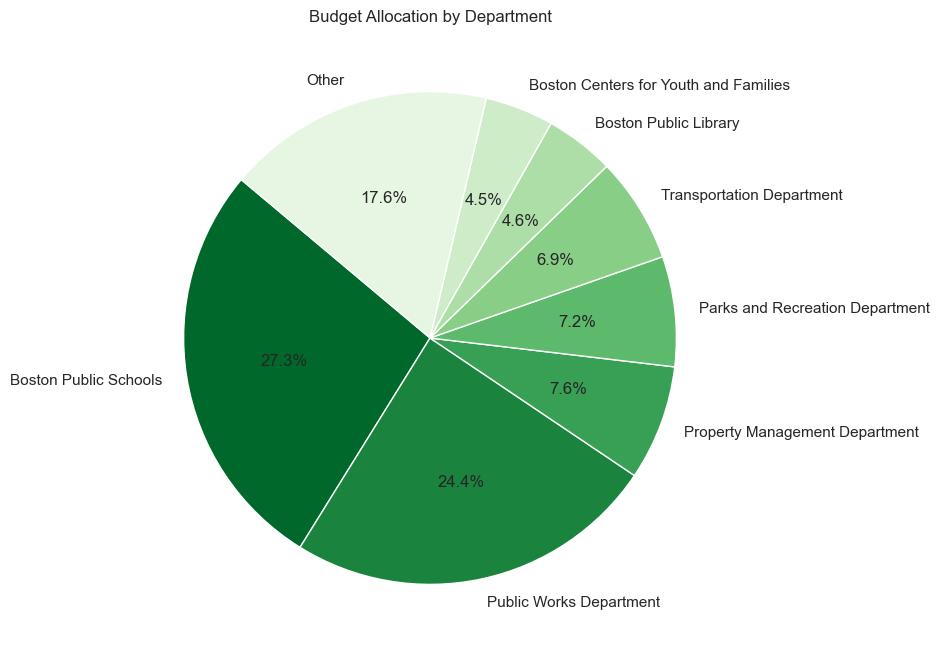

In [62]:
# Calculate the total budget for percentage calculation
total_budget = budget_per_department['Total_Project_Budget'].sum()

# Define a threshold percentage
threshold_percentage = 4.5

# Filter departments with a contribution less than the threshold and group them under "Other"
budget_per_department['Percentage'] = (budget_per_department['Total_Project_Budget'] / total_budget) * 100
filtered_data = budget_per_department[budget_per_department['Percentage'] >= threshold_percentage]
other_budget = budget_per_department[budget_per_department['Percentage'] < threshold_percentage]['Total_Project_Budget'].sum()

# Create an "Other" row as a DataFrame
if other_budget > 0:
    other_row = pd.DataFrame({
        'Department': ['Other'],
        'Total_Project_Budget': [other_budget],
        'Percentage': [(other_budget / total_budget) * 100]
    })
    
    # Concatenate the "Other" row with the filtered data
    filtered_data = pd.concat([filtered_data, other_row], ignore_index=True)

# Set up the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_data['Total_Project_Budget'],
    labels=filtered_data['Department'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Greens_r', n_colors=len(filtered_data))
)
plt.title('Budget Allocation by Department')

# Display the plot
plt.show()


# Public Schools Budget Analysis

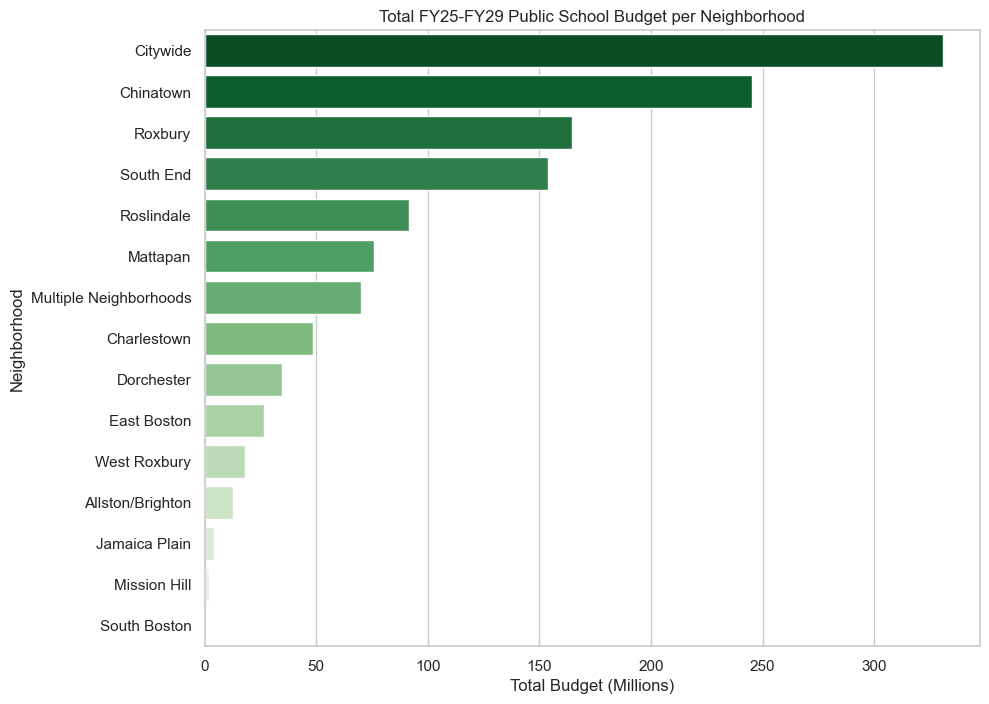

In [64]:
bps_data = df[df["Department"] == "Boston Public Schools"]

# Filter for "Boston Public Schools"
bps_data = df[df["Department"] == "Boston Public Schools"]

# Aggregate total spending by neighborhood
spending_by_neighborhood = bps_data.groupby("Neighborhood")["Total_Project_Budget"].sum().reset_index()
spending_by_neighborhood = spending_by_neighborhood.sort_values(by='Total_Project_Budget', ascending=False)

# Set the plot style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create the barplot with 'hue' assigned and 'legend=False' to avoid the legend display
sns.barplot(
    data=spending_by_neighborhood,
    x='Total_Project_Budget',
    y='Neighborhood',
    hue='Neighborhood',
    palette='Greens_r',
    dodge=False,
    legend=False
)

# Format the x-axis to display in billions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}'))

# Add labels and title
plt.xlabel('Total Budget (Millions)')
plt.ylabel('Neighborhood')
plt.title('Total FY25-FY29 Public School Budget per Neighborhood')

# Display the plot
plt.show()

# bps_data[bps_data["Neighborhood"] == "Chinatown"].head()

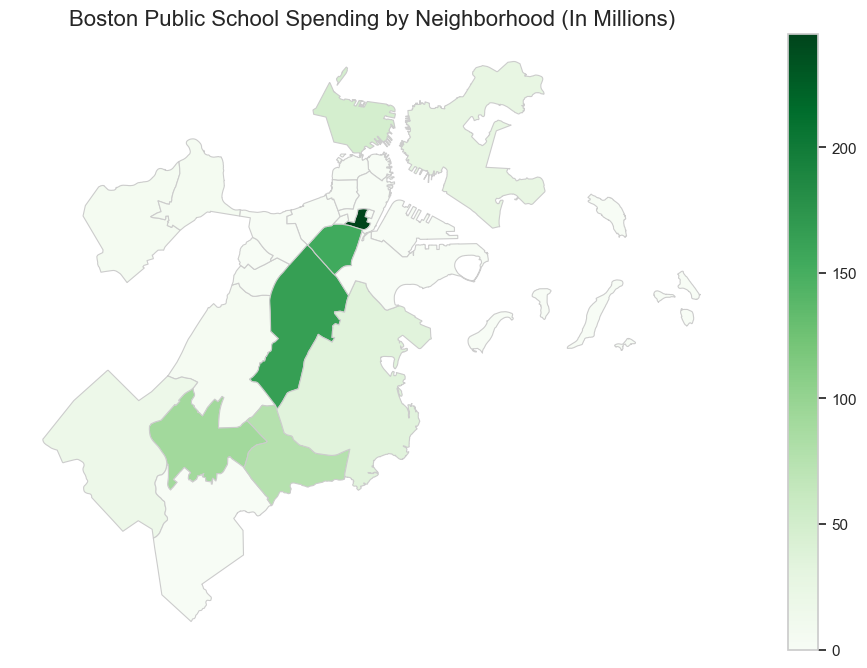

              Neighborhood  Total_Project_Budget
0                 Citywide           330566389.0
1                Chinatown           245372172.0
2                  Roxbury           164508325.0
3                South End           153637185.0
4               Roslindale            91770000.0
5                 Mattapan            76000000.0
6   Multiple Neighborhoods            70076721.0
7              Charlestown            48595000.0
8               Dorchester            34798000.0
9              East Boston            26815000.0
10            West Roxbury            18150000.0
14                 Allston             6468950.0
15                Brighton             6468950.0
11           Jamaica Plain             4275000.0
12            Mission Hill             1892212.0
13            South Boston              500000.0


In [66]:
# Load GeoJSON for Boston neighborhoods
geojson_path = "data/boston_neighborhoods.geojson"
gdf = gpd.read_file(geojson_path)

split_row = spending_by_neighborhood[spending_by_neighborhood["Neighborhood"] == "Allston/Brighton"]

allston_row = split_row.copy()
allston_row["Neighborhood"] = "Allston"
allston_row["Total_Project_Budget"] /= 2

brighton_row = split_row.copy()
brighton_row["Neighborhood"] = "Brighton"
brighton_row["Total_Project_Budget"] /= 2

spending_by_neighborhood = spending_by_neighborhood[
    spending_by_neighborhood["Neighborhood"] != "Allston/Brighton"
]
spending_by_neighborhood = pd.concat([spending_by_neighborhood, allston_row, brighton_row], ignore_index=True)
spending_by_neighborhood = spending_by_neighborhood.sort_values(by='Total_Project_Budget', ascending=False)

gdf = gdf.merge(
    spending_by_neighborhood,
    how="left",
    left_on="Name",
    right_on="Neighborhood"
)

# Fill missing values for neighborhoods without spending data
gdf["Total_Project_Budget"] = gdf["Total_Project_Budget"].fillna(0)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
plot = gdf.plot(
    column="Total_Project_Budget",
    cmap="Greens",
    legend=False,
    legend_kwds={"label": "Total Budget (in USD)", "shrink": 0.8},
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8"
)

colorbar = plot.get_figure().colorbar(plot.get_children()[0], ax=ax)
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x / 1e6:.0f}"))

# Add title and remove axes
plt.title("Boston Public School Spending by Neighborhood (In Millions)", fontsize=16)
plt.axis("off")
plt.show()
print(spending_by_neighborhood)

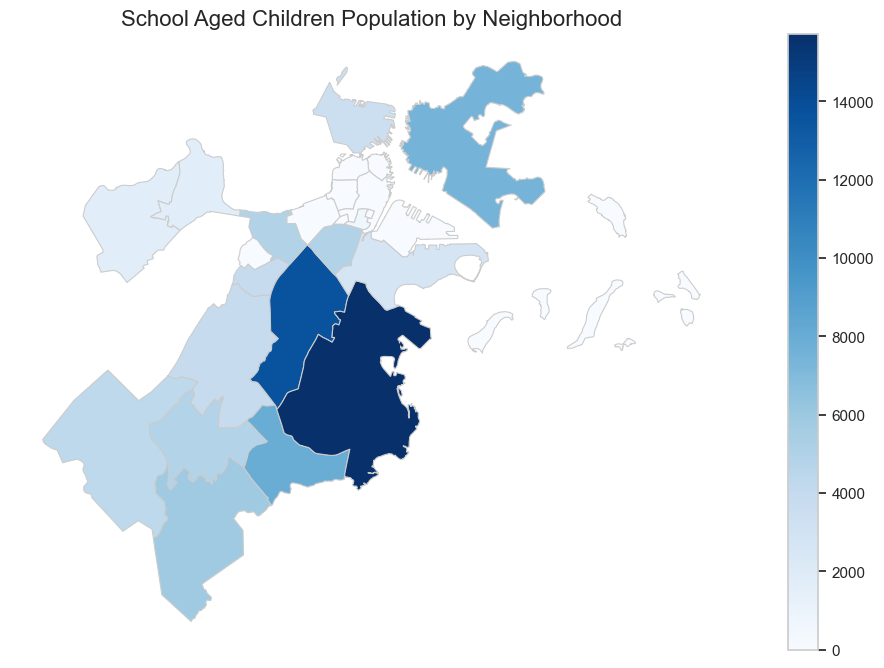

In [68]:
# Population of school aged children by neighborhood
# https://www.bostonpublicschools.org/Page/7433
population_data = {
    "Neighborhood": [
        "Citywide", "Allston", "Brighton", "Charlestown",
        "Chinatown", "Dorchester", "East Boston", "Fenway",
        "Hyde Park", "Jamaica Plain", "Mattapan", "Mission Hill",
        "Roslindale", "Roxbury", "South Boston",
        "South End", "West Roxbury"
    ],
    "Population": [
        87964, 1770, 1769, 3476,
        660, 15728, 7453, 4929,
        5885, 3900, 7936, 3900,
        4909, 13645, 2732,
        4929, 4343
    ]
}

population_df = pd.DataFrame(population_data)

gdf = gdf.merge(population_df, how="left", left_on="Name", right_on="Neighborhood")

# Fill missing values for neighborhoods without population data
gdf["Population"] = gdf["Population"].fillna(0)

# Plotting population intensity
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Create a choropleth plot for Population
plot = gdf.plot(
    column="Population",
    cmap="Blues",
    legend=False,  # We will add a custom colorbar below
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8"
)

# Add title
plt.title("School Aged Children Population by Neighborhood", fontsize=16)

colorbar = plot.get_figure().colorbar(plot.get_children()[0], ax=ax)
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x / 1e0:.0f}"))

# Hide axes for better visualization
plt.axis("off")

# Display the plot
plt.show()

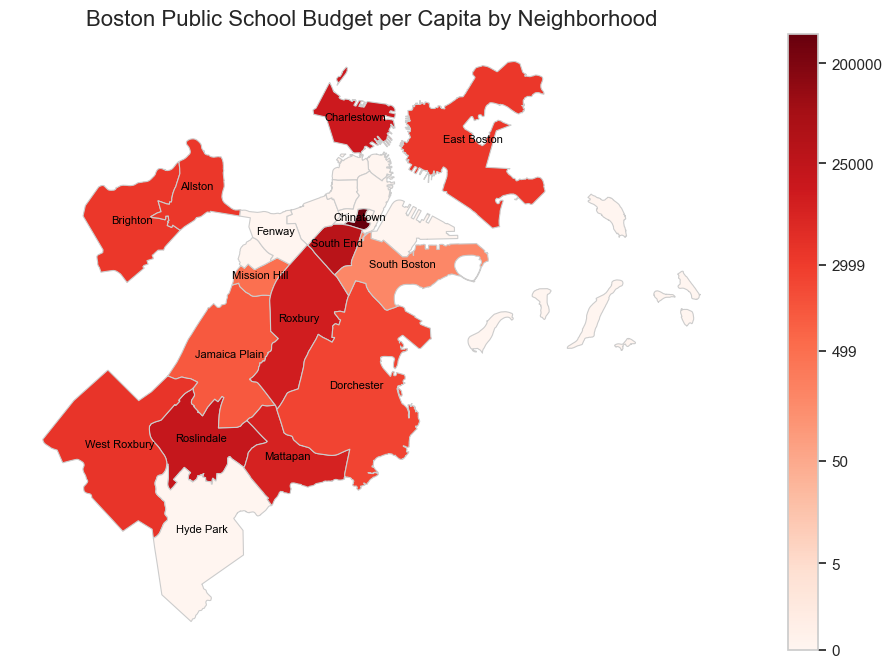

In [70]:
gdf["Spending_Per_Capita"] = gdf["Total_Project_Budget"] / gdf["Population"]
gdf["Spending_Per_Capita"] = gdf["Spending_Per_Capita"].fillna(0)

# Apply a log transformation to avoid large disparities
gdf["Spending_Per_Capita_Log"] = np.log1p(gdf["Spending_Per_Capita"])
gdf["Spending_Per_Capita"] = gdf["Spending_Per_Capita"].fillna(0)

# Plot using the transformed Spending_Per_Capita_Log
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

plot = gdf.plot(
    column="Spending_Per_Capita_Log",  # Use the log-transformed Spending per Capita
    cmap="Reds",
    legend=False,
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
)

for _, row in gdf.iterrows():
    if row["Spending_Per_Capita"] > 0 or row["Spending_Per_Capita"] == 0 and row["Population"] != 0:
        ax.annotate(
            text=row["Name"],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha="center",
            fontsize=8,
            color="black"
        )

tick_positions = np.log1p([0, 5, 50, 500, 3000, 25000, 200000.1])  # Log-transformed values
tick_labels = [f"{int(np.expm1(tick))}" for tick in tick_positions]  # Reverse the log scale for labels
colorbar = plot.get_figure().colorbar(plot.get_children()[0], ax=ax)
colorbar.set_ticks(tick_positions)  # Set tick positions
colorbar.set_ticklabels(tick_labels)  # Set custom tick labels
# Set plot title and remove axes
plt.title("Boston Public School Budget per Capita by Neighborhood", fontsize=16)
plt.axis("off")

# Show the plot
plt.show()

In [72]:
sorted_spending = gdf[["Name", "Spending_Per_Capita"]].sort_values(by="Spending_Per_Capita", ascending=False)

# Display the sorted table
sorted_spending = sorted_spending[(sorted_spending["Spending_Per_Capita"] > 0) | (sorted_spending["Name"] == "Hyde Park")
    | (sorted_spending["Name"] == "Fenway")]
print(sorted_spending.to_string(index=False))

         Name  Spending_Per_Capita
    Chinatown        371776.018182
    South End         31170.051735
   Roslindale         18694.235078
  Charlestown         13980.149597
      Roxbury         12056.308171
     Mattapan          9576.612903
 West Roxbury          4179.138844
     Brighton          3656.840023
      Allston          3654.774011
  East Boston          3597.880048
   Dorchester          2212.487284
Jamaica Plain          1096.153846
 Mission Hill           485.182564
 South Boston           183.016105
    Hyde Park             0.000000
       Fenway             0.000000


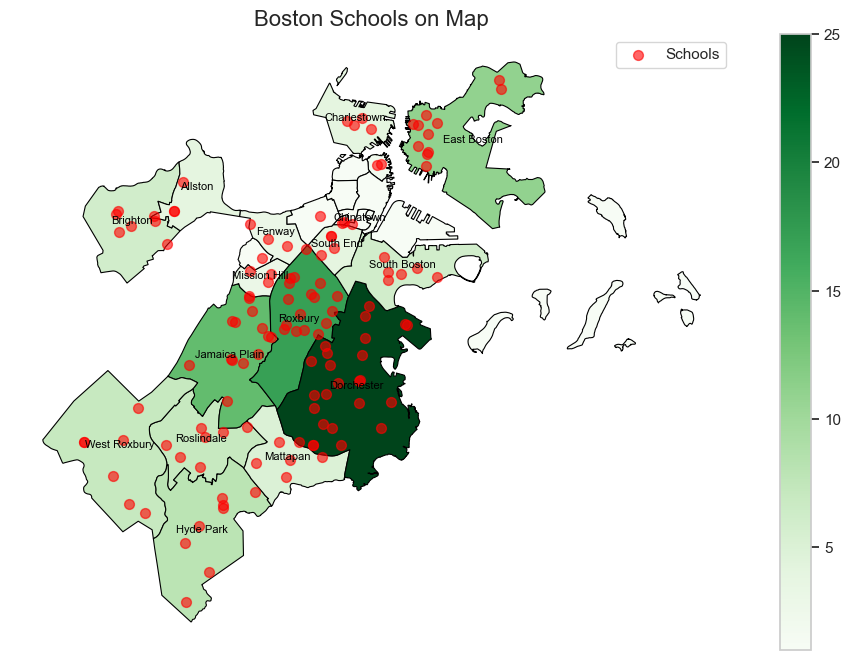

In [74]:
boston_map = gpd.read_file("data/boston_neighborhoods.geojson")
school_data = pd.read_csv("data/Public_Schools.csv") 
school_data = school_data.dropna(subset=["X", "Y"])  # Remove rows with missing coordinates

school_data["geometry"] = school_data.apply(lambda row: Point(row["X"], row["Y"]), axis=1)
schools_gdf = gpd.GeoDataFrame(school_data, geometry="geometry", crs="EPSG:4326") 

schools_in_neighborhoods = gpd.sjoin(boston_map, schools_gdf, how="left", predicate="contains")
school_counts = schools_in_neighborhoods.groupby("Name").size().reset_index(name="School_Count")

boston_map = boston_map.merge(school_counts, how="left", left_on="Name", right_on="Name")
boston_map["School_Count"] = boston_map["School_Count"].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

plot = boston_map.plot(
    column="School_Count",
    cmap="Greens",
    legend=True,
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
)

schools_gdf.plot(
    ax=ax,
    color="red", 
    markersize=50,   
    alpha=0.6,           
    label="Schools",    
    zorder=3,         
)

for _, row in gdf.iterrows():
    if row["Spending_Per_Capita"] > 0 or row["Spending_Per_Capita"] == 0 and row["Population"] != 0:
        ax.annotate(
            text=row["Name"],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha="center",
            fontsize=8,
            color="black"
        )

ax.axis("off")
plt.title("Boston Schools on Map", fontsize=16)
plt.legend()
plt.show()

In [76]:
boston_map = boston_map.merge(spending_by_neighborhood[['Neighborhood', 'Total_Project_Budget']], 
                               left_on="Name", right_on="Neighborhood", how="left")

# Calculate spending per school (avoid division by zero)
boston_map["Spending_Per_School"] = boston_map["Total_Project_Budget"] / boston_map["School_Count"]
boston_map["Spending_Per_School"] = boston_map["Spending_Per_School"].fillna(0)

spending_table = boston_map[["Name", "School_Count", "Spending_Per_School"]]
spending_table = spending_table[spending_table["School_Count"] > 0].reset_index(drop=True)

spending_table = spending_table.sort_values(by="Spending_Per_School", ascending=False)
spending_table["Spending_Per_School"] = spending_table["Spending_Per_School"].apply(lambda x: f"${x:,.2f}")
print(spending_table.to_string(index=False))

                   Name  School_Count Spending_Per_School
              Chinatown             1     $245,372,172.00
              South End             4      $38,409,296.25
               Mattapan             5      $15,200,000.00
             Roslindale             7      $13,110,000.00
            Charlestown             4      $12,148,750.00
                Roxbury            17       $9,676,960.29
           West Roxbury             7       $2,592,857.14
            East Boston            11       $2,437,727.27
                Allston             4       $1,617,237.50
             Dorchester            25       $1,391,920.00
               Brighton             6       $1,078,158.33
           Mission Hill             3         $630,737.33
          Jamaica Plain            14         $305,357.14
           South Boston             6          $83,333.33
South Boston Waterfront             1               $0.00
              Hyde Park             8               $0.00
              

# Comparing Average Household Income to BPS Budget by Neighborhood

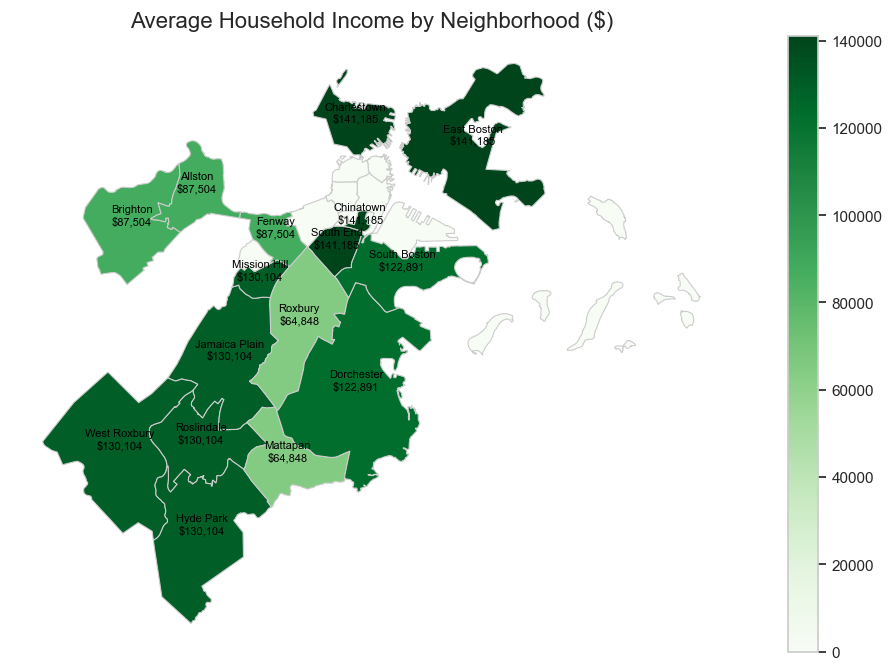

 Neighborhood   Income
  Charlestown $141,185
    Chinatown $141,185
  East Boston $141,185
    South End $141,185
    Hyde Park $130,104
Jamaica Plain $130,104
 Mission Hill $130,104
   Roslindale $130,104
 West Roxbury $130,104
   Dorchester $122,891
 South Boston $122,891
      Allston  $87,504
     Brighton  $87,504
       Fenway  $87,504
     Mattapan  $64,848
      Roxbury  $64,848


In [78]:
# Data from the most recent American Community Survey on average income in Boston neighborhoods
# https://data.census.gov/mdat/#/search?ds=ACSPUMS1Y2022&vv=%2aHINCP&rv=ucgid&wt=WGTP&g=795P200US2500801,2500802,2500803,2500804,2500805

income_data = {
    "Neighborhood": [
        "Allston", "Brighton", "Charlestown",
        "Chinatown", "Dorchester", "East Boston", "Fenway",
        "Hyde Park", "Jamaica Plain", "Mattapan", "Mission Hill",
        "Roslindale", "Roxbury", "South Boston",
        "South End", "West Roxbury"
    ],
    "Income": [
        87504, 87504, 141185,
        141185, 122891, 141185, 87504,
        130104, 130104, 64848, 130104,
        130104, 64848, 122891,
        141185, 130104
    ]
}

income_df = pd.DataFrame(income_data)

gdf = gdf.merge(income_df, how="left", left_on="Name", right_on="Neighborhood")

# Fill missing values for neighborhoods without population data
gdf["Income"] = gdf["Income"].fillna(0)

# Plotting population intensity
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

plot = gdf.plot(
    column="Income",
    cmap="Greens",
    legend=False, 
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8"
)

for _, row in gdf.iterrows():
    if row["Spending_Per_Capita"] > 0 or row["Spending_Per_Capita"] == 0 and row["Population"] != 0:
        ax.annotate(
            text=row["Name"] + "\n$" + str(int(row["Income"]) // 1000) + "," + str(int(row["Income"]) % 1000),
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha="center",
            fontsize=8,
            color="black"
        )

plt.title("Average Household Income by Neighborhood ($)", fontsize=16)

colorbar = plot.get_figure().colorbar(plot.get_children()[0], ax=ax)
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x / 1e0:.0f}"))

plt.axis("off")

# Display the plot
plt.show()

income_df = income_df.sort_values(by="Income", ascending=False)
income_df["Income"] = income_df["Income"].apply(lambda x: f"${x:,.0f}")
print(income_df.to_string(index=False))

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


                             OLS Regression Results                            
Dep. Variable:     Spending_Per_Capita   R-squared:                       0.066
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.9965
Date:                 Mon, 09 Dec 2024   Prob (F-statistic):              0.335
Time:                         22:00:52   Log-Likelihood:                -204.44
No. Observations:                   16   AIC:                             412.9
Df Residuals:                       14   BIC:                             414.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -6.99e+04   1.02e+05     -0.68

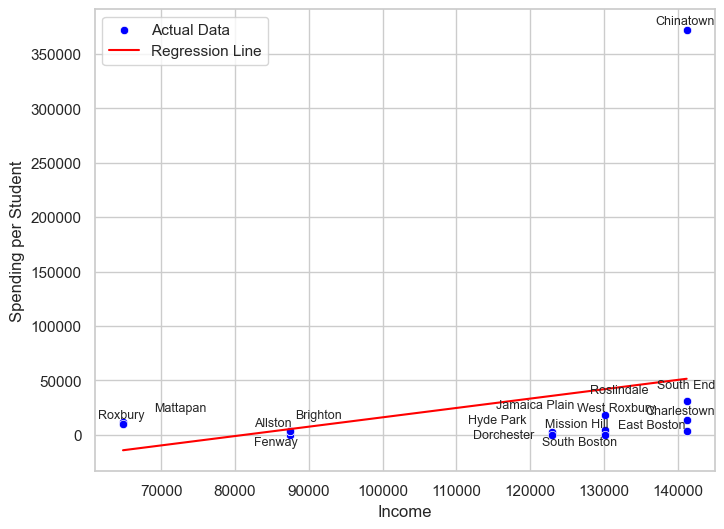

Slope: 0.8604644355640699
Intercept: -69896.05417602816
P-value for the slope: 0.3350950268039291


In [80]:
gdf_copy = gdf[(gdf["Income"] != 0) ]

X = gdf_copy[['Income']]
y = gdf_copy['Spending_Per_Capita'] 

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Print the model summary, which includes the p-value
print(model.summary())

# Generate predictions
x_range = np.linspace(gdf_copy['Income'].min(), gdf_copy['Income'].max(), 100)
x_range_const = sm.add_constant(x_range.reshape(-1, 1))
y_range = model.predict(x_range_const)

# Plot the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income', y='Spending_Per_Capita', data=gdf_copy, label='Actual Data', color='blue')

texts = []

# Add labels
for i in range(len(gdf_copy)):
    text = plt.text(gdf_copy['Income'].iloc[i], gdf_copy['Spending_Per_Capita'].iloc[i], 
                    gdf_copy['Neighborhood'].iloc[i], fontsize=9, ha='right', va='bottom')
    texts.append(text)

# Adjust the text labels to avoid overlap
adjust_text(texts)

plt.plot(x_range, y_range, color='red', label='Regression Line')
plt.xlabel('Income')
plt.ylabel('Spending per Student')
plt.legend()
plt.show()

# Get the slope (coefficient) and intercept
slope = model.params['Income']
intercept = model.params['const']

# Display the values
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

# Display p-value for the slope
p_value = model.pvalues['Income']
print(f"P-value for the slope: {p_value}")

# Combine and Standardize Checkbook Data

This has already been done! 

In [83]:
'''
def standardize_column_names(df):
    """
    Standardize column names by:
    1. Converting to lowercase
    2. Replacing spaces with underscores
    3. Removing special characters
    4. Handling common variations in column names
    """
    # Create a mapping dictionary for common variations
    column_mapping = {
        'month(number)': 'month_number',
        'fiscal month': 'fiscal_month',
        'fiscal year': 'fiscal_year',
        'vendor name': 'vendor_name',
        'account descr': 'account_descr',
        'dept name': 'dept_name',
        '6 digit org name': 'c6_digit_org_name',
        'monetary amount': 'monetary_amount',
        'voucher line': 'voucher_line',
        'distribution line': 'distribution_line'
    }
    
    # Step 1: Convert all column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Step 2: Replace spaces with underscores
    df.columns = df.columns.str.replace(' ', '_')
    
    # Step 3: Apply specific mappings
    renamed_columns = {}
    for col in df.columns:
        space_version = col.replace('_', ' ')
        if space_version in column_mapping:
            renamed_columns[col] = column_mapping[space_version]
            
    # Apply the rename
    df = df.rename(columns=renamed_columns)
    
    return df

def process_data_types(df):
    """
    Process data types for specific columns:
    - Convert 'entered' to datetime
    - Ensure 'dept_name' is string
    - Ensure 'monetary_amount' is float
    """
    # Convert 'entered' to datetime
    df['entered'] = pd.to_datetime(df['entered'], format='%m/%d/%Y')
    
    # Ensure dept_name is string type
    df['dept_name'] = df['dept_name'].fillna('Unknown').astype(str)
    
    # Ensure monetary_amount is float
    # First remove any currency symbols and commas, then convert to float
    df['monetary_amount'] = df['monetary_amount'].astype(str).str.replace('$', '', regex=False)
    df['monetary_amount'] = df['monetary_amount'].str.replace(',', '', regex=False)
    df['monetary_amount'] = pd.to_numeric(df['monetary_amount'])
    
    return df

def save_dataframe(df, output_path):
    """
    Save DataFrame with dates in MM/DD/YYYY format
    """
    df_to_save = df.copy()
    if 'entered' in df_to_save.columns and pd.api.types.is_datetime64_any_dtype(df_to_save['entered']):
        df_to_save['entered'] = df_to_save['entered'].dt.strftime('%m/%d/%Y')
    df_to_save.to_csv(output_path, index=False, encoding='utf-8-sig')

def process_checkbook_files(data_directory):
    """
    Process and combine checkbook CSV files while handling column name inconsistencies
    and data types.
    """
    # Define file pattern
    file_pattern = os.path.join(data_directory, 'checkbook-explorer-fy*.csv')
    csv_files = glob.glob(file_pattern)
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found matching pattern: {file_pattern}")
    
    df_list = []
    
    # Define dtypes for reading CSV
    dtype_dict = {
        'dept_name': str,
        'monetary_amount': float
    }
    
    # Read and standardize each CSV file
    for file in csv_files:
        try:
            # Read the CSV file with specified dtypes but without parse_dates
            temp_df = pd.read_csv(
                file,
                encoding='iso-8859-1',
                low_memory=False,
                dtype=dtype_dict
            )
            
            # Standardize column names immediately upon loading
            temp_df = standardize_column_names(temp_df)
            
            # Process data types after standardizing column names
            temp_df = process_data_types(temp_df)
            
            df_list.append(temp_df)
            print(f"Successfully loaded and standardized {file} with {temp_df.shape[0]} records.")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)
    print("\nConcatenation successful.")
    
    # Final data type processing on combined DataFrame
    combined_df = process_data_types(combined_df)
    
    # Save the combined DataFrame using the new save function
    output_path = os.path.join(data_directory, 'combined_checkbook_2012_2024_cleaned.csv')
    save_dataframe(combined_df, output_path)
    print(f"\nSaved combined and cleaned data to: {output_path}")
    
    return combined_df

if __name__ == "__main__":
    # Replace with your actual directory path
    DATA_DIR = 'data/'
    
    # Process the files
    combined_df = process_checkbook_files(DATA_DIR)
    
    # Display information about the final DataFrame
    print("\nFinal DataFrame Info:")
    print(combined_df.info())
    print("\nSample of combined data:")
    print(combined_df.head())
    
    # Check for any remaining NaN values
    print("\nNaN value counts:")
    print(combined_df.isna().sum())
'''

'\ndef standardize_column_names(df):\n    """\n    Standardize column names by:\n    1. Converting to lowercase\n    2. Replacing spaces with underscores\n    3. Removing special characters\n    4. Handling common variations in column names\n    """\n    # Create a mapping dictionary for common variations\n    column_mapping = {\n        \'month(number)\': \'month_number\',\n        \'fiscal month\': \'fiscal_month\',\n        \'fiscal year\': \'fiscal_year\',\n        \'vendor name\': \'vendor_name\',\n        \'account descr\': \'account_descr\',\n        \'dept name\': \'dept_name\',\n        \'6 digit org name\': \'c6_digit_org_name\',\n        \'monetary amount\': \'monetary_amount\',\n        \'voucher line\': \'voucher_line\',\n        \'distribution line\': \'distribution_line\'\n    }\n    \n    # Step 1: Convert all column names to lowercase\n    df.columns = df.columns.str.lower()\n    \n    # Step 2: Replace spaces with underscores\n    df.columns = df.columns.str.replace(\

# Read CSV

In [85]:
combined_df = pd.read_csv('data/combined_checkbook_2012_2024_cleaned.csv', low_memory=False, parse_dates=['entered'])
combined_df.head()

ï»¿_id   voucher  voucher_line  distribution_line    entered  month_number  \
0     1.0  10112669             1                  1 2012-02-21           2.0   
1     2.0  10112692             1                  1 2012-03-02           3.0   
2     3.0  11312001             1                  1 2011-11-17          11.0   
3     4.0  13112001             1                  1 2011-07-29           7.0   
4     5.0  13112002             1                  1 2011-07-29           7.0   

   fiscal_month     month  fiscal_year  year  \
0           8.0  Febraury         2012  2012   
1           9.0     March         2012  2012   
2           5.0  November         2012  2011   
3           1.0      July         2012  2011   
4           1.0      July         2012  2011   

                         vendor_name  account                account_descr  \
0                         Office Max  53909.0                MiscSup Other   
1                Positive Promotions  52907.0              Cont Serv Other   
2              P.J. Systems,Inc. DBA  53905.0  MiscSup Major Computer Syst   
3                    Shepard,Barbara  52907.0              Cont Serv Other   
4  The Commonwealth of Massachusetts  54901.0      Current Dues/Membership   

     dept                  dept_name             c6_digit_org_name  \
0  101068  Boston Public School Dept       Chief Operating Officer   
1  101097  Boston Public School Dept          Food & Nutrition Svc   
2  113100   Office of New Bostonians                New Bostonians   
3  101630  Boston Public School Dept       Charlestown High School   
4  19096B   Boston Community Centers  Community Child Care Voucher   

   monetary_amount  
0           488.02  
1          1450.31  
2           908.00  
3          1818.40  
4            75.00

In [87]:
combined_df.drop(columns=['ï»¿_id', 'voucher', 'voucher_line', 'distribution_line', 
                          'month_number', 'fiscal_month', 'month', 'fiscal_year', 
                          'year', 'vendor_name', 'account', 'account_descr',
                         'c6_digit_org_name'], inplace=True)
combined_df.shape

(1702307, 4)

In [89]:
combined_df.head()

entered    dept                  dept_name  monetary_amount
0 2012-02-21  101068  Boston Public School Dept           488.02
1 2012-03-02  101097  Boston Public School Dept          1450.31
2 2011-11-17  113100   Office of New Bostonians           908.00
3 2011-07-29  101630  Boston Public School Dept          1818.40
4 2011-07-29  19096B   Boston Community Centers            75.00

# Mapping Departments to Cabinet

In [91]:
cabinet_mapping = {
    # Finance Cabinet

    'Purchasing Division': 'Finance Cabinet',
    'Collecting Division': 'Finance Cabinet',
    'Auditing Department': 'Finance Cabinet',
    'Off Of Administration & Financ': 'Finance Cabinet',
    'Assessing Department': 'Finance Cabinet',
    'Office of Finance & Budget': 'Finance Cabinet',
    'Budget Management': 'Finance Cabinet',
    'Treas Dept - Treasury Division': 'Finance Cabinet',
    'Execution of Courts': 'Finance Cabinet',
    'Administration & Finance': 'Finance Cabinet',
    'Procurement': 'Finance Cabinet',
    'Office of Finance': 'Finance Cabinet',
    'Office of Participatory Budget': 'Finance Cabinet',
    'Lease Contracts Clearing Accou': 'Finance Cabinet',
    'Major Vendor Clearing Account': 'Finance Cabinet',
    'Risk Retention Reserve': 'Finance Cabinet',
    
    # Education Cabinet
    'Boston Public School Dept': 'Education Cabinet',

    # Streets Cabinet
    'Central Fleet Management': 'Streets Cabinet',
    'Off. of Chief of PWD - Transp': 'Streets Cabinet',
    'Snow Removal': 'Streets Cabinet',
    'Public Works Department': 'Streets Cabinet',
    'Transportation Department': 'Streets Cabinet',
    'Parking Clerk': 'Streets Cabinet',
    'Traffic Department': 'Streets Cabinet',
    'Ofc. of Strts., Trnsp. & Sanit': 'Streets Cabinet',
    'Snow & Winter management': 'Streets Cabinet',
    'Office of Streets': 'Streets Cabinet',
    'Snow & Winter Management': 'Streets Cabinet',

    # Mayor's Cabinet
    "Mayor's Office": "Mayor's Cabinet",
    "Mayor's Office of Housing": "Mayor's Cabinet",
    'Office of New Bostonians': "Mayor's Cabinet",
    'Law Department': "Mayor's Cabinet",
    'Department of Voter Mobilizati': "Mayor's Cabinet",
    'Intergovernmental Relations': "Mayor's Cabinet",
    'Election Department': "Mayor's Cabinet",
    'Listing Board': "Mayor's Cabinet",
     'Boston Housing Authority': "Mayor’s Cabinet",
     'Housing Trust Fund': "Mayor’s Cabinet",
     'Leading the Way': "Mayor’s Cabinet",

    # People Operations Cabinet
    'Labor Relations': 'People Operations Cabinet',
    'Human Resources': 'People Operations Cabinet',
    'Workers Compensation Fund': 'People Operations Cabinet',
    'Health Insurance': 'People Operations Cabinet',
    'Registry Division': 'People Operations Cabinet',
    'Office of People Operations': 'People Operations Cabinet',

    # Public Safety Cabinet
    'Fire Department': 'Public Safety Cabinet',
    'Police Department': 'Public Safety Cabinet',
    'Emergency Management': 'Public Safety Cabinet',
    'Emergency Shelter Commission': 'Public Safety Cabinet',
    'Emergency Preparedness': 'Public Safety Cabinet',

    # Public Health Cabinet
    'Dept of Health and Hospitals': 'Public Health Cabinet',

    # Information & Technology Cabinet
    'Dpt of Innovation & Technology': 'Information & Technology Cabinet',
    'SPO Intelepath Centrex': 'Information & Technology Cabinet',
    
    # Planning Cabinet
    'Neighborhood Development': 'Planning Cabinet',
    'Planning': 'Planning Cabinet',
    'Boston Redevelopment Authority': 'Planning Cabinet',

    # Operations Cabinet
    'Inspectional Services Dept': 'Operations Cabinet',
    'Property & Construction Mgmnt': 'Operations Cabinet',
    'Property Management': 'Operations Cabinet',
    'Public Facilities Dept': 'Operations Cabinet',

    # Arts & Culture Cabinet
    'Office of Arts & Culture': 'Arts & Culture Cabinet',
    'Library Department': 'Arts & Culture Cabinet',

    # Economic Opportunity & Inclusion Cabinet
    'Licensing Board': 'Economic Opportunity & Inclusion Cabinet',
    'Arts, Tourism & Special Events': 'Economic Opportunity & Inclusion Cabinet',
    'Office of Economic Development': 'Economic Opportunity & Inclusion Cabinet',
    'Boston Residents Jobs Policy': 'Economic Opportunity & Inclusion Cabinet',
    'Small and  Local Business': 'Economic Opportunity & Inclusion Cabinet',
    'Consumer Affairs & Licensing': 'Economic Opportunity & Inclusion Cabinet',
    'Office of Tourism': 'Economic Opportunity & Inclusion Cabinet',
    'Special Events And Tourism': 'Economic Opportunity & Inclusion Cabinet',
    'Office of Eco Opp & Inclusion': 'Economic Opportunity & Inclusion Cabinet',
    'Supplier and Workforce Diversi': 'Economic Opportunity & Inclusion Cabinet',
    'Supplier Diversity': 'Economic Opportunity & Inclusion Cabinet',

    # Worker Empowerment Cabinet
    'Youth Engagement & Employment': 'Worker Empowerment Cabinet',
    'Youth Employment & Opportunity': 'Worker Empowerment Cabinet',
    'Labor Compliance & Worker Prot': 'Worker Empowerment Cabinet',

    # Equity & Inclusion Cabinet
    "Women's Commission": 'Equity & Inclusion Cabinet',
    'Civil Rights': 'Equity and Inclusion',
    'Com. for Persons With Disabili': 'Equity & Inclusion Cabinet',
    'Fair Housing & Equity': 'Equity & Inclusion Cabinet',
    "Women's Advancement": 'Equity & Inclusion Cabinet',
    'Ofc of Immigrant  Advancement': 'Equity & Inclusion Cabinet',
    'Immigrarant Advancement': 'Equity & Inclusion Cabinet',
    'Office of Equity': 'Equity & Inclusion Cabinet',
    'Lang. & Communication Access': 'Equity & Inclusion Cabinet',
    'Resiliency & Racial Equity': 'Equity & Inclusion Cabinet',
    'LGBTQ+ Advancement': 'Equity & Inclusion Cabinet',
    'Human Right Commission': 'Equity & Inclusion Cabinet',
    'Office of Diversity': 'Equity & Inclusion Cabinet',
    'Black Male Advancement': 'Equity & Inclusion Cabinet',

    # Environment, Energy & Open Space Cabinet
    'Parks & Recreation Department': 'Environment, Energy & Open Space Cabinet',
    'Cemetery Division': 'Environment, Energy & Open Space Cabinet',
    'Environment Department': 'Environment, Energy & Open Space Cabinet',
    'Office of Food Justice': 'Environment, Energy & Open Space Cabinet',
    'Office of Historic Preservatio': 'Environment, Energy & Open Space Cabinet',
    'Office of HistoricPreservation': 'Environment, Energy & Open Space Cabinet',

    # Human Services Cabinet
    'Age Strong': 'Human Services Cabinet',
    'Office of Health & Human Servi': 'Human Services Cabinet',
    'Age Strong Commission': 'Human Services Cabinet',
    'Office of Human Services': 'Human Services Cabinet',
    'Elderly Commission': 'Human Services Cabinet',
    "Veterans' Services": 'Human Services Cabinet',
    'Boston Center-Youth & Families': 'Human Services Cabinet',
    'Youth Fund': 'Human Services Cabinet',

    # Community Engagement Cabinet
    'Neighborhood Services': 'Community Engagement Cabinet',
    'Boston Community Centers': 'Community Engagement Cabinet',

    # Non-Mayoral Departments
    'City Clerk': 'Non-Mayoral Departments',
    'City Council': 'Non-Mayoral Departments',
    'Finance Commission': 'Non-Mayoral Departments',

    # Communications
    'Public Information': 'Communications',

    # OPAT Cabinet
    'Police Accablty. & Transparenc': 'OPAT Cabinet'
}

# Apply Mapping

In [93]:
# Apply the mapping
combined_df['cabinet_name'] = combined_df['dept_name'].map(cabinet_mapping).fillna('UNMAPPED')
combined_df[combined_df['cabinet_name'] == 'UNMAPPED']

Empty DataFrame
Columns: [entered, dept, dept_name, monetary_amount, cabinet_name]
Index: []

In [95]:
print("\nDate range in the data:")
combined_df.sort_values(by=['entered'], ascending=True, inplace=True)
print(f"Earliest date: {combined_df['entered'].min()}")
print(f"Latest date: {combined_df['entered'].max()}")

combined_df['month'] = combined_df['entered'].dt.month
combined_df['year'] = combined_df['entered'].dt.year

yearly_monthly_counts = pd.crosstab(combined_df['year'], combined_df['month'])
print("\nTransaction counts by year and month:")
print(yearly_monthly_counts)


Date range in the data:
Earliest date: 2011-07-01 00:00:00
Latest date: 2024-04-30 00:00:00

Transaction counts by year and month:
month     1      2      3      4      5      6      7      8      9      10  \
year                                                                          
2011       0      0      0      0      0      0  10182  10939  14959  13529   
2012   13397  14281  14883  11524  16815  14018   6933   7845   7836   7397   
2013   14250  12863  15930  12239  16362  13619  22508   9255  11703   9810   
2014   12312  11759  13344   9401  12410  13003  13164  10738  11841  11579   
2015    9454   6756  11757  10418   9832  13546  10134   5000   7902  11893   
2016    9039   8729   9509  15440  12781  12064  11011  11685  10392  12466   
2017   11715  10732  13211  11879  13076  19019  15743  12648  11182  13161   
2018   10745  12022  14011  14727  14475  12229  11065   9689   9166  14535   
2019   14012   8675  10990  12886  12677  11038  10895   8664   7128  13755   

In [97]:
combined_df = combined_df.loc[(combined_df['year'] >= 2012) & 
                (combined_df['year'] <= 2023)]

In [100]:
# Create a 'year_month' column in 'YYYY-MM' format
combined_df['year_month'] = combined_df['entered'].dt.to_period('M').astype(str)

# Group by 'year_month' and 'cabinet_name' and sum the 'monetary_amount'
monthly_spending = combined_df.groupby(['year_month', 'cabinet_name'])['monetary_amount'].sum().reset_index()

# Pivot to create wide format with cabinets as columns
spending_wide = monthly_spending.pivot(index='year_month', 
                                       columns='cabinet_name', 
                                       values='monetary_amount')

# Fill NAs with 0
spending_wide = spending_wide.fillna(0)

# Sort index
spending_wide = spending_wide.sort_index()

# Display the first few rows
spending_wide.head()

cabinet_name  Arts & Culture Cabinet  Communications  \
year_month                                             
2012-01                   1117275.80         2331.72   
2012-02                    723385.99          778.82   
2012-03                   1088001.82         3810.30   
2012-04                    734974.26        14683.67   
2012-05                    696026.54         4386.96   

cabinet_name  Community Engagement Cabinet  \
year_month                                   
2012-01                            3476.31   
2012-02                            2954.12   
2012-03                            2610.13   
2012-04                            4937.28   
2012-05                            7760.40   

cabinet_name  Economic Opportunity & Inclusion Cabinet  Education Cabinet  \
year_month                                                                  
2012-01                                       15510.77        21895136.15   
2012-02                                      153737.05        22247552.42   
2012-03                                       21921.06        23998252.24   
2012-04                                       37204.33        22341096.42   
2012-05                                       26175.00        21849282.70   

cabinet_name  Environment, Energy & Open Space Cabinet  \
year_month                                               
2012-01                                     1804247.25   
2012-02                                     1736160.91   
2012-03                                     1203758.71   
2012-04                                     1917559.79   
2012-05                                     1652392.20   

cabinet_name  Equity & Inclusion Cabinet  Equity and Inclusion  \
year_month                                                       
2012-01                             0.00               2759.92   
2012-02                            50.00              11175.50   
2012-03                           490.87               4361.70   
2012-04                           906.66               2681.95   
2012-05                          5539.67               1751.47   

cabinet_name  Finance Cabinet  Human Services Cabinet  ...  Mayor’s Cabinet  \
year_month                                             ...                    
2012-01          1.473178e+06               656023.88  ...        191283.20   
2012-02          4.728643e+06               696436.88  ...        311410.63   
2012-03          4.006729e+06              1493629.64  ...       1065284.20   
2012-04          1.856915e+07              1090483.54  ...        375793.44   
2012-05          1.296023e+08              1520989.63  ...        437712.02   

cabinet_name  Non-Mayoral Departments  OPAT Cabinet  Operations Cabinet  \
year_month                                                                
2012-01                      14480.61           0.0           854520.12   
2012-02                      10008.90           0.0           714474.73   
2012-03                      23672.65           0.0          1284734.76   
2012-04                      35604.62           0.0           937193.39   
2012-05                      28906.33           0.0           923719.46   

cabinet_name  People Operations Cabinet  Planning Cabinet  \
year_month                                                  
2012-01                     18045005.51        5105394.58   
2012-02                     19349693.16        5178607.88   
2012-03                     19168640.79        4431131.67   
2012-04                     20083483.43        4451676.63   
2012-05                     15391625.37        6166521.90   

cabinet_name  Public Health Cabinet  Public Safety Cabinet  Streets Cabinet  \
year_month                                                                    
2012-01                  1548825.00             4423345.46       9122255.78   
2012-02                  3097650.00             3225048.03       7590579.19   
2012-03                        0.00             49

In [102]:
# Assuming your DataFrame is called df
cabinet_spending = spending_wide.reset_index() 
cabinet_spending.columns.name = None 
cabinet_spending['year_month'] = pd.to_datetime(cabinet_spending['year_month'])
cabinet_spending.head()

year_month  Arts & Culture Cabinet  Communications  \
0 2012-01-01              1117275.80         2331.72   
1 2012-02-01               723385.99          778.82   
2 2012-03-01              1088001.82         3810.30   
3 2012-04-01               734974.26        14683.67   
4 2012-05-01               696026.54         4386.96   

   Community Engagement Cabinet  Economic Opportunity & Inclusion Cabinet  \
0                       3476.31                                  15510.77   
1                       2954.12                                 153737.05   
2                       2610.13                                  21921.06   
3                       4937.28                                  37204.33   
4                       7760.40                                  26175.00   

   Education Cabinet  Environment, Energy & Open Space Cabinet  \
0        21895136.15                                1804247.25   
1        22247552.42                                1736160.91   
2        23998252.24                                1203758.71   
3        22341096.42                                1917559.79   
4        21849282.70                                1652392.20   

   Equity & Inclusion Cabinet  Equity and Inclusion  Finance Cabinet  ...  \
0                        0.00               2759.92     1.473178e+06  ...   
1                       50.00              11175.50     4.728643e+06  ...   
2                      490.87               4361.70     4.006729e+06  ...   
3                      906.66               2681.95     1.856915e+07  ...   
4                     5539.67               1751.47     1.296023e+08  ...   

   Mayor’s Cabinet  Non-Mayoral Departments  OPAT Cabinet  Operations Cabinet  \
0        191283.20                 14480.61           0.0           854520.12   
1        311410.63                 10008.90           0.0           714474.73   
2       1065284.20                 23672.65           0.0          1284734.76   
3        375793.44                 35604.62           0.0           937193.39   
4        437712.02                 28906.33           0.0           923719.46   

   People Operations Cabinet  Planning Cabinet  Public Health Cabinet  \
0                18045005.51        5105394.58             1548825.00   
1                19349693.16        5178607.88             3097650.00   
2                19168640.79        4431131.67                   0.00   
3                20083483.43        4451676.63            22014912.94   
4                15391625.37        6166521.90                 600.00   

   Public Safety Cabinet  Streets Cabinet  Worker Empowerment Cabinet  
0             4423345.46       9122255.78                         0.0  
1             3225048.03       7590579.19                         0.0  
2             4968106.30       7401911.40                         0.0  
3             3764724.66       8744606.94                         0.0  
4             4372241.67       8849796.07                         0.0  

[5 rows x 23 columns]

In [104]:
trend_cabinet_spending = cabinet_spending.copy()
trend_cabinet_spending.set_index('year_month', inplace=True)

In [106]:
# Set the display option to show numbers without scientific notation
pd.set_option('display.float_format', '{:.0f}'.format)

# Calculate the sum for each column
column_sums = trend_cabinet_spending.sum()

# Sort the sums in descending order
sorted_sums_desc = column_sums.sort_values(ascending=False)


print("\nTotals Sorted in Descending Order:")
print(sorted_sums_desc)


Totals Sorted in Descending Order:
Education Cabinet                          4202793769
People Operations Cabinet                  3012893890
Streets Cabinet                            1935566528
Finance Cabinet                            1074321750
Public Safety Cabinet                       952966639
Planning Cabinet                            756503531
Environment, Energy & Open Space Cabinet    460462860
Information & Technology Cabinet            414022950
Arts & Culture Cabinet                      344053184
Operations Cabinet                          309029434
Mayor's Cabinet                             307516997
Human Services Cabinet                      231911387
Economic Opportunity & Inclusion Cabinet     67154515
Mayor’s Cabinet                              33031235
Public Health Cabinet                        26661988
Worker Empowerment Cabinet                   25812781
Equity & Inclusion Cabinet                   14102587
Non-Mayoral Departments                       

In [108]:


def plot_cabinet_spending(cabinet_name):
    """
    Plots the monthly spending along with 3-month and 12-month moving averages for a specified cabinet.
    Highlights winter months (December, January, February) on the plot.
    
    Parameters:
    cabinet_name (str): The name of the cabinet to analyze.
    """
    # Extract the spending data for the selected cabinet
    try:
        spending = trend_cabinet_spending[cabinet_name]
    except KeyError:
        print(f"Cabinet '{cabinet_name}' not found in the DataFrame.")
        return
    
    # Calculate the 3-month and 12-month moving averages
    spending_ma3 = spending.rolling(window=3).mean()
    spending_ma12 = spending.rolling(window=12).mean()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(spending.index, spending, label='Monthly Spending', color='blue', linewidth=1)
    ax.plot(spending_ma3.index, spending_ma3, label='3-Month Moving Average', color='orange', linewidth=2, linestyle='--')
    ax.plot(spending_ma12.index, spending_ma12, label='12-Month Moving Average', color='green', linewidth=2, linestyle=':')
    
    # Formatting the plot
    plt.title(f'Spending Over Time for {cabinet_name}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Spending Amount', fontsize=12)
    
    # Format y-axis to show numbers in millions with one decimal place
    def millions(x, pos):
        """Formats the y-axis labels to display in millions with one decimal place."""
        return f'${x * 1e-6:.1f}M'
    
    formatter = ticker.FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Highlight Winter Months (December, January, February)
    winter_months = [12, 1, 2]
    
    # Create a DataFrame copy to work with
    df = trend_cabinet_spending[cabinet_name].to_frame().copy()
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    
    # Initialize list to hold winter periods
    winter_periods = []
    
    # Iterate through unique years in the data
    unique_years = df['Year'].unique()
    for year in unique_years:
        # December of the current year
        try:
            dec_date = df[(df['Year'] == year) & (df['Month'] == 12)].index[0]
        except IndexError:
            # If December data is missing for this year, skip
            continue
        
        # January and February of the next year
        try:
            jan_date = df[(df['Year'] == year + 1) & (df['Month'] == 1)].index[0]
            feb_date = df[(df['Year'] == year + 1) & (df['Month'] == 2)].index[-1]
        except IndexError:
            # If January or February data is missing for the next year, adjust the end date
            # If both are missing, skip shading
            jan_exists = not df[(df['Year'] == year + 1) & (df['Month'] == 1)].empty
            feb_exists = not df[(df['Year'] == year + 1) & (df['Month'] == 2)].empty
            if jan_exists:
                jan_date = df[(df['Year'] == year + 1) & (df['Month'] == 1)].index[0]
                feb_date = jan_date + pd.offsets.MonthEnd(0)
            elif feb_exists:
                feb_date = df[(df['Year'] == year + 1) & (df['Month'] == 2)].index[-1]
                jan_date = feb_date - pd.offsets.MonthBegin(0)
            else:
                # If neither January nor February data exists, skip shading
                continue
        
        # Append the winter period as (start, end)
        winter_periods.append((dec_date, feb_date))
    
    # Shade each winter period
    for start, end in winter_periods:
        # Extend the end date to include the entire month
        end_extended = end + pd.offsets.MonthEnd(0)
        ax.axvspan(start, end_extended, color='grey', alpha=0.2, label='Winter Months' if start == winter_periods[0][0] else "")
    
    # Adjust y-axis limits
    plt.ylim(0, None)
    
    # Add legend
    plt.legend()
    
    # Add grid, rotate x-axis labels, and adjust layout
    plt.grid(True, linewidth=0.5)
    plt.tight_layout()
    
    # Display the plot
    plt.show()


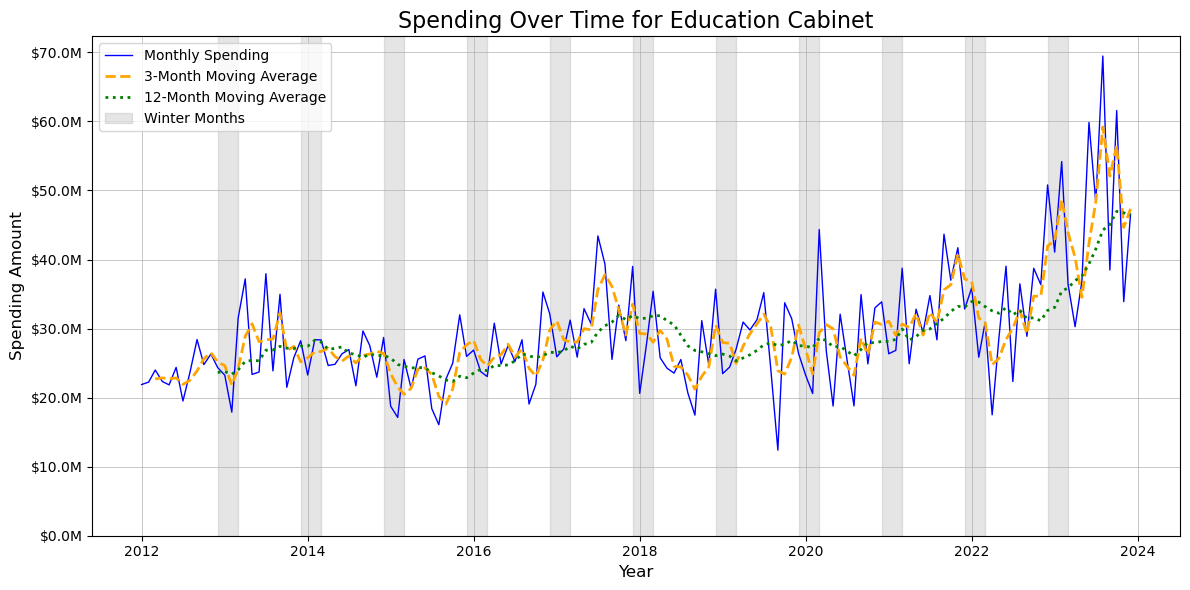

In [83]:
plot_cabinet_spending('Education Cabinet')

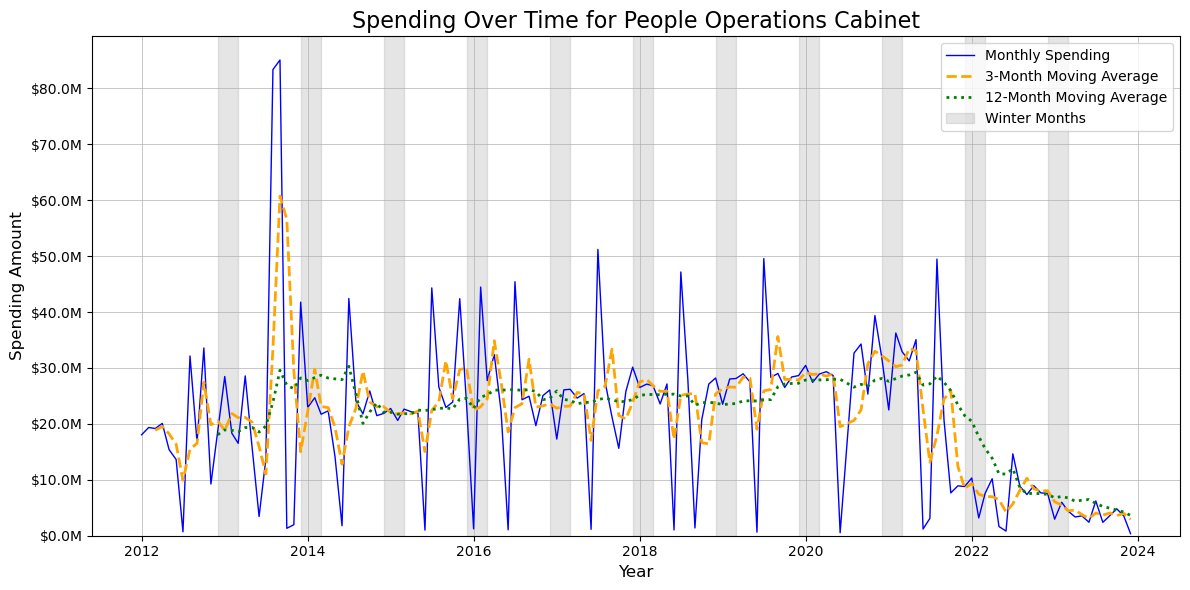

In [84]:
plot_cabinet_spending('People Operations Cabinet')

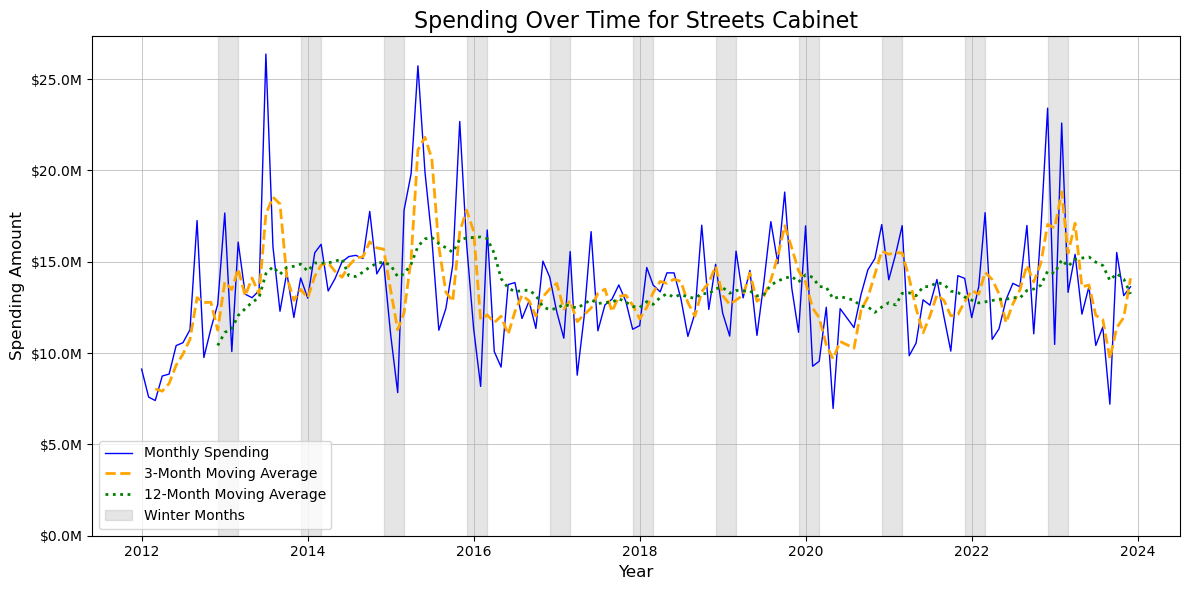

In [85]:
plot_cabinet_spending('Streets Cabinet')

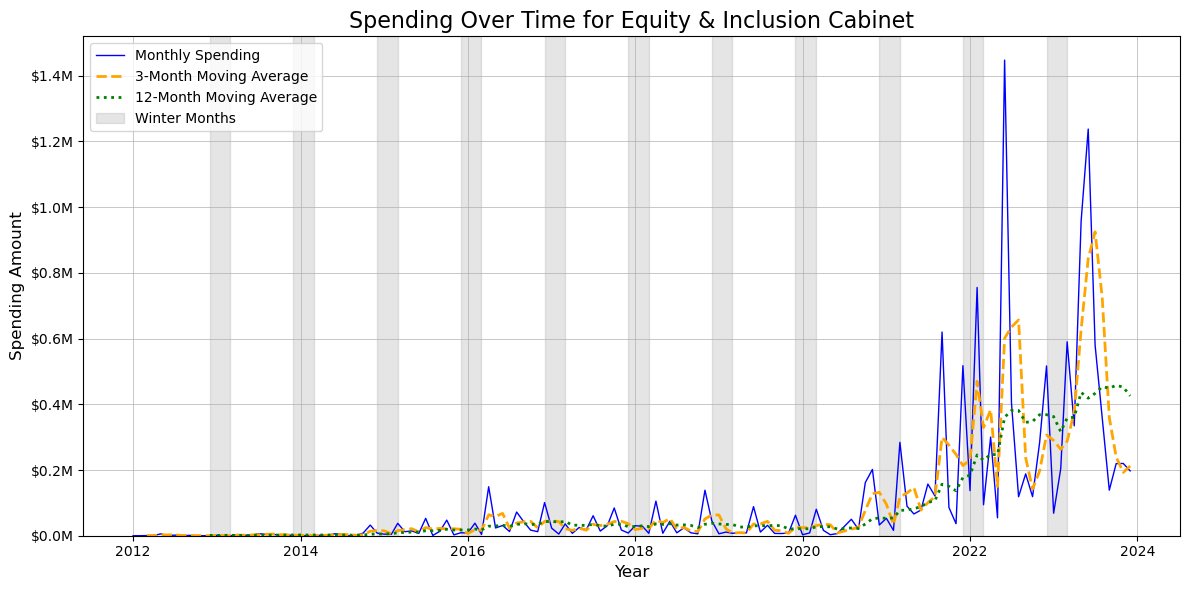

In [86]:
plot_cabinet_spending('Equity & Inclusion Cabinet')

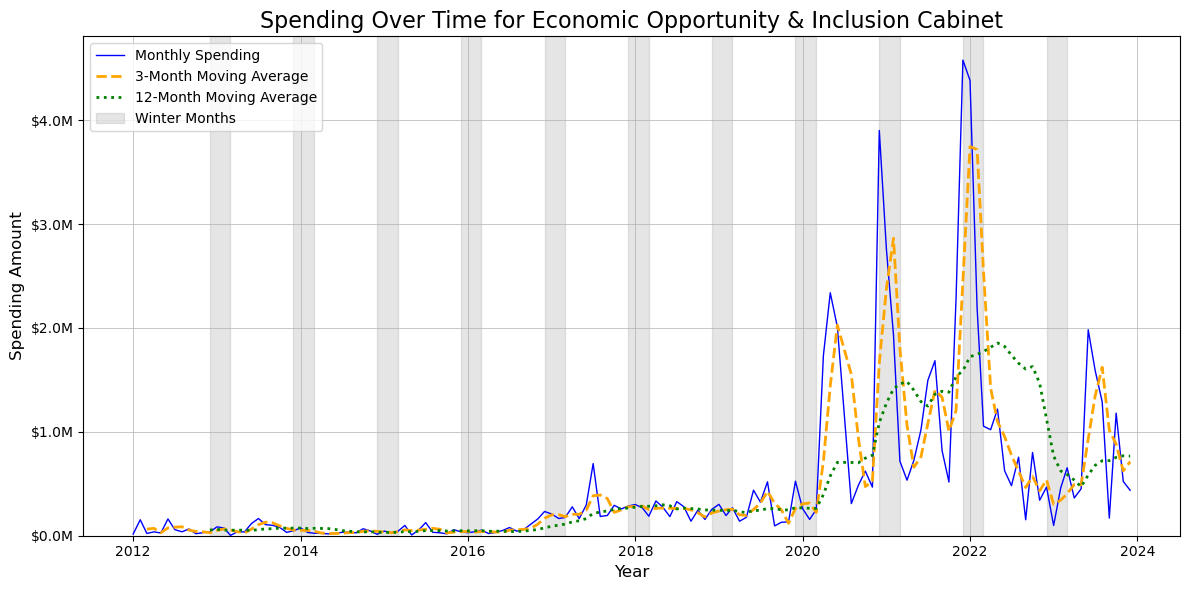

In [87]:
plot_cabinet_spending('Economic Opportunity & Inclusion Cabinet')

In [110]:
df = pd.read_csv('data/boston-utility-data.csv')
df.head(3)

InvoiceID AccountNumber EnergyTypeName InvoiceDate    FromDate      ToDate  \
0    6602853   73004104763    Natural Gas  2015-09-10  2015-08-11  2015-09-10   
1    6589679    9504656628          Steam  2014-01-29  2014-01-02  2014-01-29   
2    6610018   73004109036    Natural Gas  2011-08-31  2011-08-01  2011-08-31   

   UsagePeriodDays  DeliveryCost  SupplyCost  TotalCost  ...    City    Zip  \
0               30           104           0        104  ...  Boston  02136   
1               27          5438           0       5438  ...  Boston  02108   
2               30            32           0         32  ...  Boston  02136   

       StateName Abbreviation    CountryName      SiteName Currency  \
0  Massachusetts           MA  United States  Hyde Park HS      USD   
1  Massachusetts           MA  United States       Unknown      USD   
2  Massachusetts           MA  United States      Chittick      USD   

    CodeDescription DepartmentName        _ingest_datetime  
0  Delivery Invoice            BPS  2024-11-01 14:10:59+00  
1  Delivery Invoice            PMD  2024-11-01 14:10:59+00  
2  Delivery Invoice            BPS  2024-11-01 14:10:59+00  

[3 rows x 24 columns]

In [112]:
df = df.drop(columns=['InvoiceID', 'AccountNumber', 'FromDate', 'ToDate', 'StreetAddress', 'City', 'Zip', 'StateName', 'Abbreviation', 'CountryName', 'SiteName', 'Currency', 'CodeDescription', '_ingest_datetime'])

In [114]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['InvoiceDate'].dt.year >= 2011]
df = df.dropna(subset=['InvoiceDate'])
df = df.dropna(subset=['DepartmentName'])

print("Data range after filtering:")
print(f"Start Date: {df['InvoiceDate'].min()}")
print(f"End Date: {df['InvoiceDate'].max()}")

Data range after filtering:
Start Date: 2011-01-02 00:00:00
End Date: 2024-10-26 00:00:00


In [116]:
print(df['DepartmentName'].unique())
df.info()

['BPS' 'PMD' 'BTD' 'PARKS' 'BFD' 'BCYF' 'PWD' 'DND' 'BPL' 'BPD' 'COB'
 'MOH' 'PARK' 'PARKS ' 'BPHC' ' BPS' ' PARKS' 'UNKNOWN' 'Parks'
 'PROP MGMT' 'A' 'City of Boston ' 'Park' ' PWD' 'Parcels 03711002'
 '?Parks' '?DND' 'PARKK' 'Arts&Culture' 'Arts& Culture' 'ISD' 'Prop Mgmt'
 'SCH' 'áBTD' '\xa0BTD' 'CON' 'COb Parks' 'COB PMD' 'MOH ' 'Parks '
 'BPHC ' 'BPHS' 'BPSC']
<class 'pandas.core.frame.DataFrame'>
Index: 725157 entries, 0 to 734837
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   EnergyTypeName    725157 non-null  object        
 1   InvoiceDate       725157 non-null  datetime64[ns]
 2   UsagePeriodDays   725157 non-null  int64         
 3   DeliveryCost      725157 non-null  float64       
 4   SupplyCost        725157 non-null  float64       
 5   TotalCost         725157 non-null  float64       
 6   TotalConsumption  724477 non-null  float64       
 7   DemandkW          724477 n

In [118]:
department_mapping = {
    'BPS': 'Boston Public Schools',
    ' BPS': 'Boston Public Schools',
    'SCH': 'Boston Public Schools',
    'BPSC': 'Boston Public Schools',

    'PMD': 'Property Management Department',
    'PROP MGMT': 'Property Management Department',
    'Prop Mgmt': 'Property Management Department',
    'COB PMD': 'Property Management Department',

    'BTD': 'Boston Transportation',
    'áBTD': 'Boston Transportation',
    '\xa0BTD': 'Boston Transportation',

    'PARKS': 'Boston Parks and Recreation',
    'PARK': 'Boston Parks and Recreation',
    'PARKS ': 'Boston Parks and Recreation',
    ' PARKS': 'Boston Parks and Recreation',
    'Parks': 'Boston Parks and Recreation',
    'Park': 'Boston Parks and Recreation',
    '?Parks': 'Boston Parks and Recreation',
    'PARKK': 'Boston Parks and Recreation',
    'COb Parks': 'Boston Parks and Recreation',
    'Parks ': 'Boston Parks and Recreation',

    'BFD': 'Boston Fire Department',
    'BCYF': 'Boston Centers for Youth and Families',
    
    'PWD': 'Public Works Department',
    ' PWD': 'Public Works Department',
    
    'DND': 'Department of Neighborhood Development',
    '?DND': 'Department of Neighborhood Development',
    
    'BPL': 'Boston Public Library',
    'BPD': 'Boston Police Department',

    'COB': 'City of Boston',
    'City of Boston ': 'City of Boston',
    
    'MOH': "Mayor's Office of Housing",
    'MOH ': "Mayor's Office of Housing",
    
    'BPHC': 'Boston Public Health Commission',
    'BPHC ': 'Boston Public Health Commission', 
    'BPHS': 'Boston Public Health Commission',

    'Arts&Culture': 'Arts and Culture', 
    'Arts& Culture': 'Arts and Culture',
    
    'ISD': 'Inspectional Services Department',
    'CON': 'Conservation and Recreation'
}

In [120]:
df['DepartmentName'] = df['DepartmentName'].map(department_mapping).fillna('UNKNOWN')
print(df['DepartmentName'].unique())

['Boston Public Schools' 'Property Management Department'
 'Boston Transportation' 'Boston Parks and Recreation'
 'Boston Fire Department' 'Boston Centers for Youth and Families'
 'Public Works Department' 'Department of Neighborhood Development'
 'Boston Public Library' 'Boston Police Department' 'City of Boston'
 "Mayor's Office of Housing" 'Boston Public Health Commission' 'UNKNOWN'
 'Arts and Culture' 'Inspectional Services Department'
 'Conservation and Recreation']


In [122]:
df_grouped = df.groupby([pd.Grouper(key='InvoiceDate', freq='ME'), 'DepartmentName'])['TotalCost'].sum().reset_index()
df_pivot = df_grouped.pivot(index='InvoiceDate', columns='DepartmentName', values='TotalCost')

In [124]:
# 3.1: Inspect Data Types
print("\nData Types in df_grouped:")
print(df_grouped.dtypes)

print("\nData Types in df_pivot:")
print(df_pivot.dtypes)

# Convert 'DepartmentName' to category if not already
if df_grouped['DepartmentName'].dtype != 'category':
    df_grouped['DepartmentName'] = df_grouped['DepartmentName'].astype('category')

# 3.2: Check for Missing Values
print("\nMissing Values in df_grouped:")
print(df_grouped.isnull().sum())

print("\nMissing Values in df_pivot:")
print(df_pivot.isnull().sum())

# 3.3: Check for Duplicate Entries in df_grouped
duplicates = df_grouped.duplicated()
print(f"\nNumber of duplicate rows in df_grouped: {duplicates.sum()}")

if duplicates.any():
    print("\nDuplicate Rows in df_grouped:")
    print(df_grouped[duplicates])

    # Remove duplicate rows
    df_grouped = df_grouped.drop_duplicates()
    print(f"Duplicates removed. New row count: {len(df_grouped)}")

# 3.4: Statistical Summary and Outliers Detection
print("\nStatistical Summary of TotalCost in df_grouped:")
print(df_grouped['TotalCost'].describe())

print("\nStatistical Summary of Departments in df_pivot:")
print(df_pivot.describe())

high_cost = df_grouped[df_grouped['TotalCost'] > 100000]
print(f"\nRows with TotalCost > 100,000:\n{high_cost}")


Data Types in df_grouped:
InvoiceDate       datetime64[ns]
DepartmentName            object
TotalCost                float64
dtype: object

Data Types in df_pivot:
DepartmentName
Arts and Culture                          float64
Boston Centers for Youth and Families     float64
Boston Fire Department                    float64
Boston Parks and Recreation               float64
Boston Police Department                  float64
Boston Public Health Commission           float64
Boston Public Library                     float64
Boston Public Schools                     float64
Boston Transportation                     float64
City of Boston                            float64
Conservation and Recreation               float64
Department of Neighborhood Development    float64
Inspectional Services Department          float64
Mayor's Office of Housing                 float64
Property Management Department            float64
Public Works Department                   float64
UNKNOWN             

In [126]:
def plot_department_total_cost(df_pivot, department_name):
    """
    Plots the total cost over time for a specific department, highlighting winter regions.

    Parameters:
    - df_pivot (pd.DataFrame): Pivoted DataFrame with 'InvoiceDate' as index and departments as columns.
    - department_name (str): The name of the department to plot.

    Returns:
    - None: Displays the plot.
    """
    # Check if the specified department exists
    if department_name not in df_pivot.columns:
        raise ValueError(f"Department '{department_name}' not found in the DataFrame columns.")
    
    # Extract the data for the specified department
    department_data = df_pivot[department_name]
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Identify unique years in the data
    years = department_data.index.year.unique()
    
    # Define and shade winter periods: December to February
    for year in years:
        # Define the start of winter: December 1st of the current year
        start_winter = pd.Timestamp(year=year, month=12, day=1)
        # Define the end of winter: February 28th of the next year
        end_winter = pd.Timestamp(year=year + 1, month=2, day=28)
        
        # Adjust the end_date if it exceeds the maximum date in the data
        if end_winter > department_data.index.max():
            end_winter = department_data.index.max()
        
        # Only shade if the start_date is within the data range
        if start_winter <= department_data.index.max() and end_winter >= department_data.index.min():
            # Adjust start_winter if it starts before the data's minimum date
            if start_winter < department_data.index.min():
                start_winter = department_data.index.min()
            # Adjust end_winter if it ends after the data's maximum date
            if end_winter > department_data.index.max():
                end_winter = department_data.index.max()
            
            # Shade the winter period
            ax.axvspan(start_winter, end_winter, color='lightgrey', alpha=0.5, zorder=0)
    
    # Plot the department's total cost over time
    ax.plot(department_data.index, department_data.values, label=department_name, color='blue', linewidth=2, zorder=1)
    
    # Format the x-axis to show month and year
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Total Cost')
    plt.title(f'Total Cost Over Time for {department_name}')

    winter_patch = Patch(facecolor='lightgrey', alpha=0.5, label='Winter')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(winter_patch)
    labels.append('Winter')
    ax.legend(handles=handles, labels=labels, title='Legend')
    
    
    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()

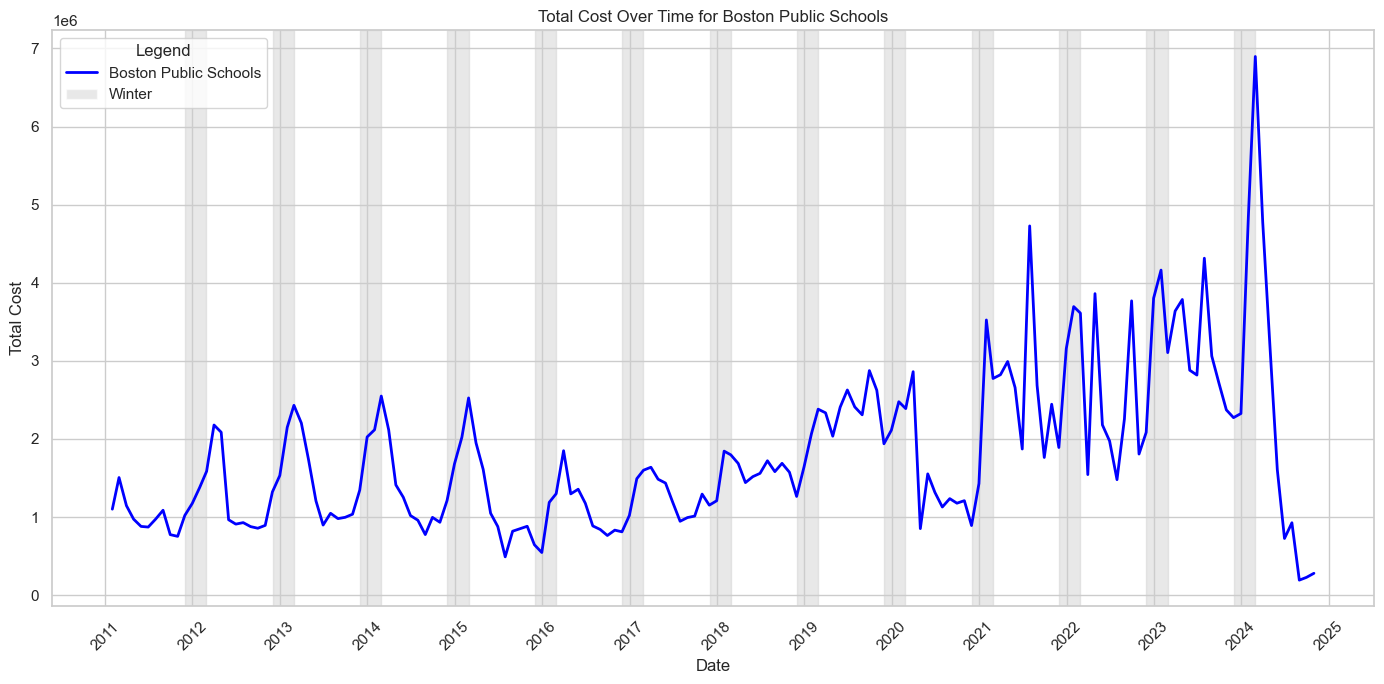

In [128]:
plot_department_total_cost(df_pivot, department_name='Boston Public Schools')

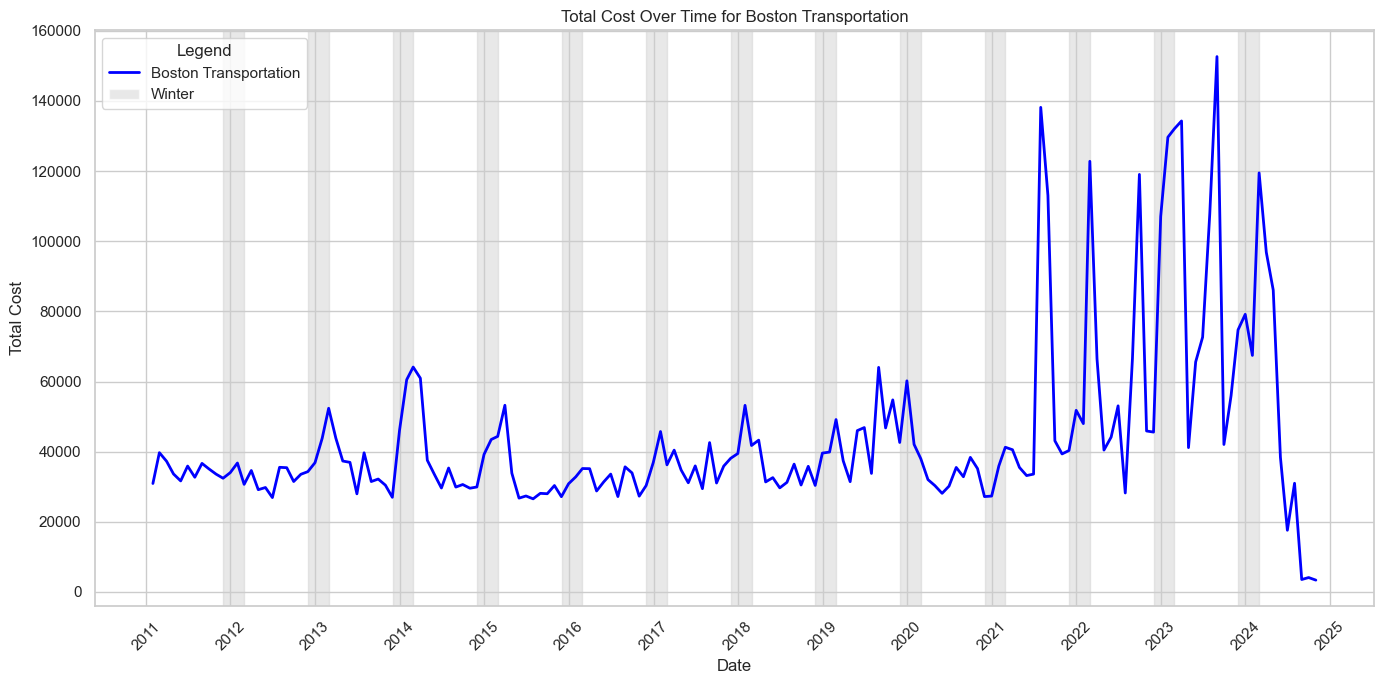

In [130]:
plot_department_total_cost(df_pivot, department_name='Boston Transportation')

In [132]:
def plot_department_energy_pie_chart(df, department_name):
    """
    Plots a pie chart showing the percentage distribution of EnergyTypeName 
    based on the number of observations for a specific DepartmentName.
    Labels and percentages are only displayed for slices >= 1%.
    
    Parameters:
    - df (pd.DataFrame): The raw DataFrame containing at least 'DepartmentName' and 'EnergyTypeName' columns.
    - department_name (str): The name of the department to plot.
    
    Returns:
    - None: Displays the pie chart.
    """
    # ------------------ Data Validation ------------------
    
    # Check if required columns exist
    required_columns = ['DepartmentName', 'EnergyTypeName']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are missing from the DataFrame: {missing_columns}")
    
    # Check if the specified department exists
    if department_name not in df['DepartmentName'].unique():
        raise ValueError(f"Department '{department_name}' not found in the DataFrame.")
    
    # ------------------ Data Aggregation ------------------
    
    dept_data = df[df['DepartmentName'] == department_name]
    
    if dept_data.empty:
        raise ValueError(f"No data available for Department '{department_name}'.")
    
    # Count the number of observations per EnergyTypeName
    energy_distribution = dept_data['EnergyTypeName'].value_counts()
    
    # Handle cases where there are no observations
    if energy_distribution.empty:
        raise ValueError(f"No EnergyTypeName data available for Department '{department_name}'. Cannot plot pie chart.")
    
    # Calculate percentages
    total = energy_distribution.sum()
    percentages = (energy_distribution / total) * 100
    
    # Define colors using a colormap
    colors = plt.cm.Paired(range(len(energy_distribution)))
    
    # Define a function for autopct to conditionally display percentages
    def autopct_func(pct):
        return f'{pct:.1f}%' if pct >= 1 else ''
    
    # Prepare labels: show label only if percentage >=1%
    labels = [label if pct >= 1 else '' for label, pct in zip(energy_distribution.index, percentages)]
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the pie chart
    wedges, texts, autotexts = ax.pie(
        energy_distribution, 
        labels=labels, 
        autopct=autopct_func, 
        startangle=140,
        colors=colors,
        textprops={'fontsize': 12}
    )
    
    # Style the autotexts (percentages)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    
    # Set title
    plt.title(f'Energy Type Distribution for {department_name}', fontsize=16)
    
    # Optional: Add a legend (useful if there are many energy types)
    legend_handles = [Patch(facecolor=colors[i], label=energy) for i, energy in enumerate(energy_distribution.index)]
    ax.legend(handles=legend_handles, title='Energy Types', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to make room for the legend if it's used
    plt.tight_layout()
    
    # Display the plot
    plt.show()


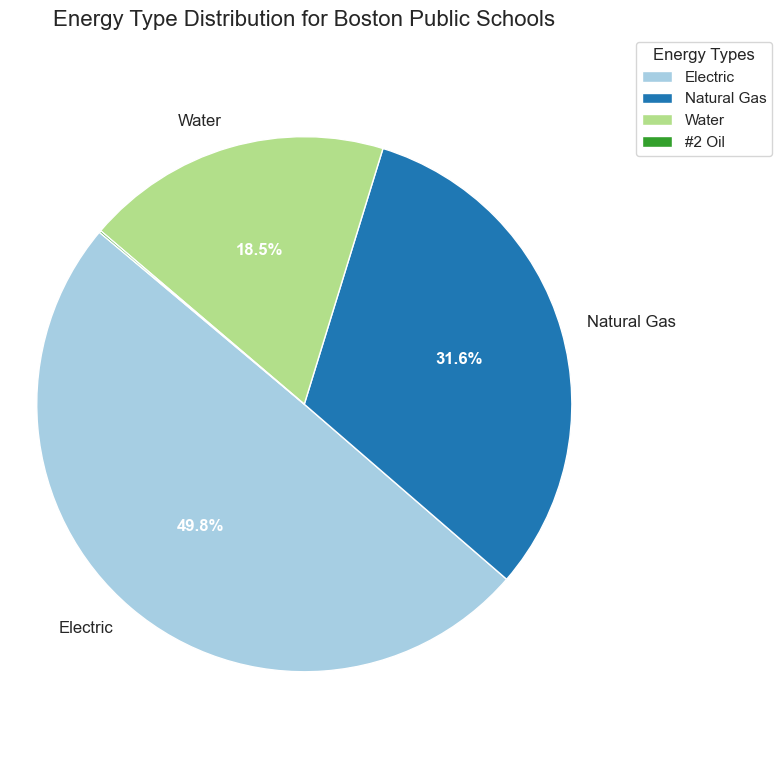

In [134]:
plot_department_energy_pie_chart(df, 'Boston Public Schools')

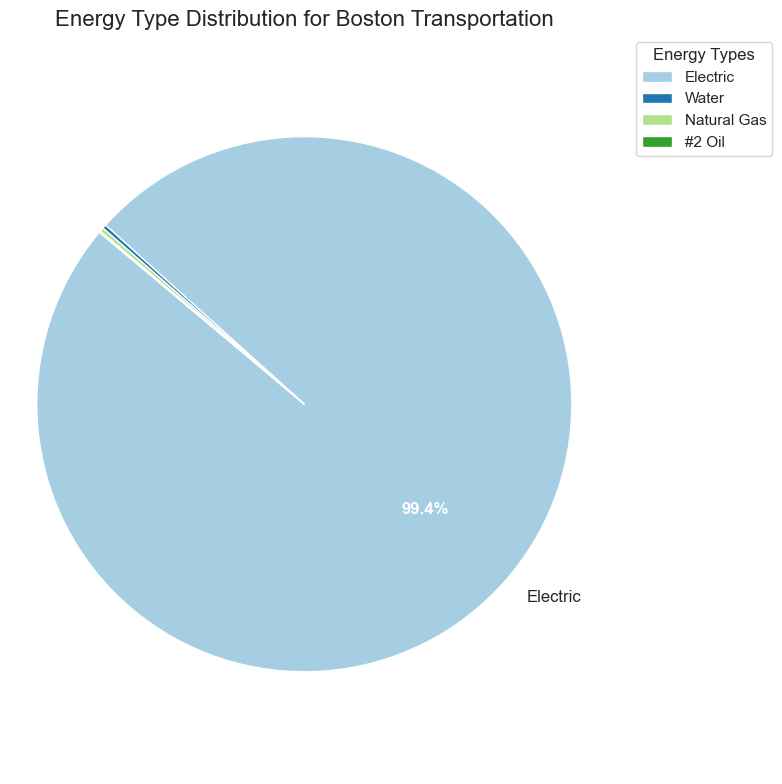

In [136]:
plot_department_energy_pie_chart(df, 'Boston Transportation')

In [138]:
def prepare_percentage_data(df):
    """
    Prepares the data by calculating the percentage distribution of energy type invoices per year.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing at least 'InvoiceDate' and 'EnergyType' columns.
    
    Returns:
    - pivot_df (pd.DataFrame): Pivoted DataFrame with years as index and energy types as columns containing percentage values.
    """
    # Ensure 'InvoiceDate' is in datetime format
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    
    # Extract year from 'InvoiceDate'
    df['Year'] = df['InvoiceDate'].dt.year
    
    # Group by 'Year' and 'EnergyType' and count the number of invoices
    counts = df.groupby(['Year', 'EnergyTypeName']).size().reset_index(name='Count')
    
    # Calculate total invoices per year
    counts['Total'] = counts.groupby('Year')['Count'].transform('sum')
    
    # Calculate percentage
    counts['Percentage'] = (counts['Count'] / counts['Total']) * 100
    
    # Pivot the DataFrame to have years as rows and energy types as columns
    pivot_df = counts.pivot(index='Year', columns='EnergyTypeName', values='Percentage').fillna(0)
    
    # Sort the DataFrame by Year
    pivot_df = pivot_df.sort_index()
    
    return pivot_df

def plot_stacked_bar_chart(pivot_df):
    """
    Plots a stacked bar chart showing the percentage distribution of Energy Types for each year.
    Labels are positioned in the middle of each segment and only displayed if the segment is >=5%.
    
    Parameters:
    - pivot_df (pd.DataFrame): Pivoted DataFrame with years as index and energy types as columns containing percentage values.
    
    Returns:
    - None: Displays the stacked bar chart.
    """
    # Define the plot size
    plt.figure(figsize=(14, 8))
    
    # List of energy types
    energy_types = pivot_df.columns.tolist()
    
    # Colors: Generate a color palette (Set3 has up to 12 distinct colors; adjust if more energy types exist)
    colors = plt.cm.Set3(range(len(energy_types)))
    
    # Initialize the bottom for stacking
    bottom = [0] * len(pivot_df)
    
    # Plot each energy type
    for i, energy in enumerate(energy_types):
        plt.bar(
            pivot_df.index, 
            pivot_df[energy], 
            bottom=bottom, 
            label=energy, 
            color=colors[i]
        )
        
        # Calculate label positions
        for idx, (year, pct) in enumerate(zip(pivot_df.index, pivot_df[energy])):
            if pct >= 5:  # Only label segments with percentage >=5%
                # Calculate the position: bottom + half of the current segment
                label_position = bottom[idx] + pct / 2
                plt.text(
                    year, 
                    label_position, 
                    f'{pct:.1f}%', 
                    ha='center', 
                    va='center',
                    fontsize=10,
                    color='black'
                )
        
        # Update the bottom for the next energy type
        bottom = [bottom[j] + pivot_df[energy].iloc[j] for j in range(len(bottom))]
    
    # Set labels and title
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Percentage of Invoices (%)', fontsize=14)
    plt.title('Year-over-Year Distribution of Energy Type Invoices', fontsize=16)
    
    # Set x-axis ticks to be integer years
    plt.xticks(pivot_df.index, pivot_df.index, fontsize=12)
    
    # Add legend
    plt.legend(title='Energy Type', fontsize=12, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set y-axis limit to 100%
    plt.ylim(0, 100)
    
    # Improve layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

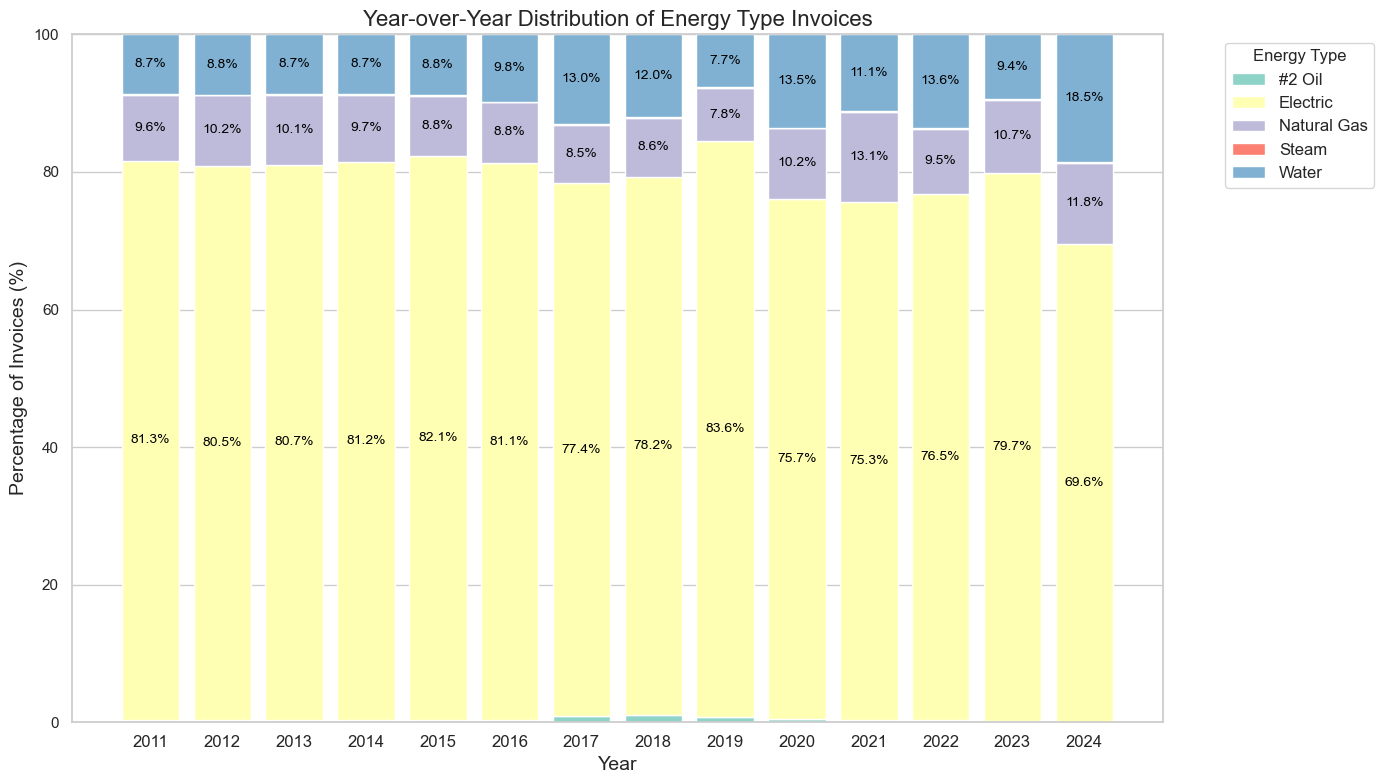

In [140]:
pivot_df = prepare_percentage_data(df)
plot_stacked_bar_chart(pivot_df)

# Load Raw Data

In [142]:
employee_2021 = pd.read_csv('data/employee-earnings-report-2021.csv', encoding='latin1')
employee_2022 = pd.read_csv('data/employee-earnings-report-2022.csv')
employee_2023 = pd.read_csv('data/employee-earnings-report-2023.csv')

In [144]:
employee_2021.rename(columns={"QUINN_EDUCATION_INCENTIVE": "QUINN_EDUCATION"}, inplace=True)
display(employee_2021)

NAME           DEPARTMENT_NAME  \
0            Beckers,Richard  Boston Police Department   
1      McGowan,Jacqueline M.  Boston Police Department   
2             Harris,Shawn N  Boston Police Department   
3          Washington,Walter  Boston Police Department   
4          Mosley Jr.,Curtis  Boston Police Department   
...                      ...                       ...   
22547                    NaN                       NaN   
22548                    NaN                       NaN   
22549                    NaN                       NaN   
22550                    NaN                       NaN   
22551                    NaN                       NaN   

                                TITLE     REGULAR RETRO         OTHER  \
0                      Police Officer         NaN   NaN  1,264,843.63   
1                      Police Officer         NaN   NaN  1,252,990.81   
2      Police Offc Comm Serv Offc 3$8   69,772.10   NaN    212,739.48   
3                      Police Officer  100,963.38   NaN    211,900.28   
4      Police Offc Comm Serv Offc 3$8  109,858.02   NaN    192,097.54   
...                               ...         ...   ...           ...   
22547                             NaN         NaN   NaN           NaN   
22548                             NaN         NaN   NaN           NaN   
22549                             NaN         NaN   NaN           NaN   
22550                             NaN         NaN   NaN           NaN   
22551                             NaN         NaN   NaN           NaN   

        OVERTIME    INJURED     DETAIL QUINN_EDUCATION   TOTAL_GROSS POSTAL  
0            NaN        NaN        NaN             NaN  1,264,843.63  02119  
1            NaN        NaN        NaN             NaN  1,252,990.81  02129  
2      82,300.87  30,939.24  12,144.00       25,178.06    433,073.75  02130  
3      67,849.66        NaN   9,016.00       10,096.55    399,825.87  02368  
4      75,938.65        NaN  19,550.00             NaN    397,444.21  02301  
...          ...        ...        ...             ...           ...    ...  
22547        NaN        NaN        NaN             NaN           NaN    NaN  
22548        NaN        NaN        NaN             NaN           NaN    NaN  
22549        NaN        NaN        NaN             NaN           NaN    NaN  
22550        NaN        NaN        NaN             NaN           NaN    NaN  
22551        NaN        NaN        NaN             NaN           NaN    NaN  

[22552 rows x 12 columns]

In [146]:
employee_2022.rename(columns={"TOTAL_ GROSS": "TOTAL_GROSS"}, inplace=True)
display(employee_2022)

NAME                 DEPARTMENT_NAME  \
0                Gavin,Donna M.        Boston Police Department   
1             Cassellius,Brenda                  Superintendent   
2                  Dempsey,John          Boston Fire Department   
3              Demesmin,Stanley        Boston Police Department   
4                  Smith,Sean P        Boston Police Department   
...                         ...                             ...   
23199  wheeler,Stephen clifford  Boston Cntr - Youth & Families   
23200             Harris,Gloria       BPS Office Of Budget Mgmt   
23201       Jackson,Wanita Tina        Boston Police Department   
23202              Paul,Desmond    BPS Substitute Teachers/Nurs   
23203         Robinson,Marvin L    BPS Substitute Teachers/Nurs   

                         TITLE     REGULAR RETRO         OTHER    OVERTIME  \
0      Police Lieutenant (Det)   53,226.90   NaN  1,045,845.44      463.52   
1               Superintendent  179,109.61   NaN    417,839.83         NaN   
2           Commissioner (BFD)  133,653.78   NaN    312,752.53         NaN   
3      Police Lieutenant (Det)  145,775.26   NaN     13,932.92  196,515.25   
4            Police Lieutenant  142,535.62   NaN     18,827.45  142,692.38   
...                        ...         ...   ...           ...         ...   
23199              Lifeguard I       42.01   NaN           NaN         NaN   
23200                Attendant       24.23   NaN           NaN         NaN   
23201      School Traffic Supv       23.68   NaN           NaN         NaN   
23202    Substitute Teacher HE       21.28   NaN           NaN         NaN   
23203    Substitute Teacher HE       14.06   NaN           NaN         NaN   

      INJURED     DETAIL QUINN_EDUCATION   TOTAL_GROSS POSTAL  
0         NaN        NaN       12,812.39  1,112,348.25  02186  
1         NaN        NaN             NaN    596,949.44  55419  
2         NaN        NaN             NaN    446,406.31  02152  
3         NaN  11,880.00       29,155.26    397,258.69  02052  
4         NaN  46,365.00       35,633.88    386,054.33  02186  
...       ...        ...             ...           ...    ...  
23199     NaN        NaN             NaN         42.01  02129  
23200     NaN        NaN             NaN         24.23  02136  
23201     NaN        NaN             NaN         23.68  02119  
23202     NaN        NaN             NaN         21.28  02119  
23203     NaN        NaN             NaN         14.06  02126  

[23204 rows x 12 columns]

In [148]:
employee_2023.drop(columns=['_id'], inplace=True)
employee_2023.rename(columns={"TOTAL GROSS": "TOTAL_GROSS"}, inplace=True)
display(employee_2023)

NAME               DEPARTMENT_NAME  \
0          Demesmin,Stanley      Boston Police Department   
1             Hosein,Haseeb      Boston Police Department   
2           Conway,Kendra J      Boston Police Department   
3              Smith,Sean P      Boston Police Department   
4          Danilecki,John H      Boston Police Department   
...                     ...                           ...   
25807       Colon,Markenson                Transportation   
25808         Harris,Gloria                        Budget   
25809   Wallace,Emma Fierro  BPS Substitute Teachers/Nurs   
25810       Kramer,Joseph M  BPS Substitute Teachers/Nurs   
25811  Bettencourt,Katarina  BPS Substitute Teachers/Nurs   

                         TITLE  REGULAR  RETRO  OTHER  OVERTIME  INJURED  \
0      Police Lieutenant (Det)   145775    NaN   6053    221579      NaN   
1           Police Captain/DDC   162824    NaN 165670     34154      NaN   
2               Police Officer   359942    NaN  48651       NaN      NaN   
3            Police Lieutenant   142536    NaN  20368    152031      NaN   
4               Police Captain   162327    NaN  24504     96955      NaN   
...                        ...      ...    ...    ...       ...      ...   
25807              Cab Monitor      NaN      2    NaN       NaN      NaN   
25808                Attendant      NaN      1    NaN       NaN      NaN   
25809       Substitute Teacher      NaN      1    NaN       NaN      NaN   
25810       Substitute Teacher      NaN      0    NaN       NaN      NaN   
25811       Substitute Teacher      NaN      0    NaN       NaN      NaN   

       DETAIL  QUINN_EDUCATION  TOTAL_GROSS POSTAL  
0       23862            29155       426425  02052  
1        5472            40706       408826  02186  
2         NaN              NaN       408594  02465  
3       51646            35634       402215  02186  
4       61512            40582       385879  02559  
...       ...              ...          ...    ...  
25807     NaN              NaN            2  02121  
25808     NaN              NaN            1  02136  
25809     NaN              NaN            1  02131  
25810     NaN              NaN            0  01845  
25811     NaN              NaN            0  02135  

[25812 rows x 12 columns]

# Combine and Clean Data

In [150]:
# List of DataFrames to concatenate
employee_2021_2023 = [employee_2021, employee_2022, employee_2023]

# Concatenate DataFrames vertically and reset the index
df = pd.concat(employee_2021_2023, axis=0, ignore_index=True)
df.drop(columns=['NAME', 'POSTAL'], inplace=True)

columns_to_convert = [
    'REGULAR',
    'RETRO',
    'OTHER',
    'OVERTIME',
    'INJURED',
    'DETAIL',
    'QUINN_EDUCATION',
    'TOTAL_GROSS'
]

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[columns_to_convert] = df[columns_to_convert].fillna(0)
df[columns_to_convert] = df[columns_to_convert].clip(lower=0)

df = df[(df['REGULAR'] >= 28000) | (df['TOTAL_GROSS'] >= 28000)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19346 entries, 45756 to 65101
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DEPARTMENT_NAME  19346 non-null  object 
 1   TITLE            19346 non-null  object 
 2   REGULAR          19346 non-null  float64
 3   RETRO            19346 non-null  float64
 4   OTHER            19346 non-null  float64
 5   OVERTIME         19346 non-null  float64
 6   INJURED          19346 non-null  float64
 7   DETAIL           19346 non-null  float64
 8   QUINN_EDUCATION  19346 non-null  float64
 9   TOTAL_GROSS      19346 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.6+ MB


In [152]:
df['DEPARTMENT_NAME'].unique()

array(['Boston Police Department', "Superintendent's Office", 'Strategy',
       'Boston Fire Department', 'Inspectional Services Dept',
       'Public Works Department', 'Holmes Elementary', 'Boston Latin',
       'School Support', 'Facilities Management', 'Boston Public Library',
       'Kennedy Academy Health Careers', 'Family & Community Advancement',
       'Chief Academic Officer', 'Chief of Staff',
       'Dpt of Innovation & Technology', 'Traffic Division', 'Eliot K-8',
       "Mayor's Office", 'East Boston High', 'Taylor Elementary',
       'Parks Department', 'New Mission High', 'Gardner Pilot Academy',
       'Murphy K-8', 'Curley K-8', 'Madison Park Tech Vocational',
       'Human Capital', 'Planning & Design', 'High School Renewal',
       'Quincy Elementary', 'Tynan Elementary', 'Student Support',
       'Treasury-Treasury Division', 'Finance', 'Brighton High',
       'Boston Retirement System', 'Election Division',
       'Chittick Elementary', 'TechBoston Academy',
    

In [154]:
# List of keywords to identify 'Education' departments
education_keywords = [
    'School',
    'K-8',
    'K-12',
    'K0-2',
    'Ed',
    'BPS',
    'Elementary',
    'High',
    'Academy',
    '3-8',
    'College',
    'Education'
    'Student',
    'Learn',
    'Learning',
    'Vocational',
    "Superintendent's Office",
    'Chief Academic Officer',
    'Student Support',
    'Boston Latin',
    'BCLA-McCormack',
    'Quincy Upper',
    'Haley Pilot',
    'BTU Pilot',
    'Horace Mann',
    'EEC',
    'Carter',
    'West Zone ELC',
    'Alighieri Montessori',
    'Charter'
]

# Escape keywords to handle any special regex characters
escaped_keywords = [re.escape(keyword) for keyword in education_keywords]

# Create the regex pattern
pattern = '|'.join(escaped_keywords)

mask = df['DEPARTMENT_NAME'].str.contains(pattern, case=False, regex=True, na=False)
df.loc[mask, 'DEPARTMENT_NAME'] = 'Education'
df['DEPARTMENT_NAME'].unique()

array(['Boston Police Department', 'Education', 'Strategy',
       'Boston Fire Department', 'Inspectional Services Dept',
       'Public Works Department', 'Facilities Management',
       'Boston Public Library', 'Family & Community Advancement',
       'Chief of Staff', 'Dpt of Innovation & Technology',
       'Traffic Division', "Mayor's Office", 'Parks Department',
       'Human Capital', 'Planning & Design', 'Treasury-Treasury Division',
       'Finance', 'Boston Retirement System', 'Election Division',
       'Capital Planning', 'Office of People Operations',
       'Behavioral Health Services', 'Law Department',
       'Health & Human Servs', 'Office of Housing',
       'Planning & Engineering', 'Equity', 'Early Childhood',
       'Office of Streets', 'Operations', 'Emergency Management',
       'Off of Eco Opp & Incl', 'Health Services', 'Labor Relations',
       'Health & Wellness', 'Auditing Department', 'Safety Services',
       'Cemetery Division', 'Environment Department',

# Basic Analysis

In [156]:
# Group by 'DEPARTMENT_NAME'
education_df = df[df['DEPARTMENT_NAME'] == 'Education']# Get descriptive statistics for the specified columns
education_stats = education_df[['REGULAR', 'OVERTIME', 'TOTAL_GROSS']].describe()
print("Descriptive Statistics for Education Department:")
print(education_stats)

Descriptive Statistics for Education Department:
       REGULAR  OVERTIME  TOTAL_GROSS
count     9686      9686         9686
mean     91283        41        99145
std      36632       665        38745
min          0         0        28027
25%      57364         0        62999
50%      96737         0       104735
75%     122705         0       131650
max     303461     42153       382096


In [158]:
police_df = df[df['DEPARTMENT_NAME'] == 'Boston Police Department']# Get descriptive statistics for the specified columns
police_stats = police_df[['REGULAR', 'OVERTIME', 'TOTAL_GROSS']].describe()
print("Descriptive Statistics for Police Department:")
print(police_stats)

Descriptive Statistics for Police Department:
       REGULAR  OVERTIME  TOTAL_GROSS
count     2727      2727         2727
mean     86624     32440       151447
std      35567     30851        61791
min          0         0        28426
25%      69180      6300       112833
50%      92048     26209       149305
75%     106227     49159       185477
max     359942    221579       426425


In [160]:
mayor_df = df[df['DEPARTMENT_NAME'] == "Mayor's Office"]
mayor_stats = mayor_df[['REGULAR', 'OVERTIME', 'TOTAL_GROSS']].describe()
print("Descriptive Statistics for Mayor's Office:")
print(police_stats)

Descriptive Statistics for Mayor's Office:
       REGULAR  OVERTIME  TOTAL_GROSS
count     2727      2727         2727
mean     86624     32440       151447
std      35567     30851        61791
min          0         0        28426
25%      69180      6300       112833
50%      92048     26209       149305
75%     106227     49159       185477
max     359942    221579       426425


In [162]:
fire_df = df[df['DEPARTMENT_NAME'] == "Boston Fire Department"]
fire_stats = fire_df[['REGULAR', 'OVERTIME', 'TOTAL_GROSS']].describe()
print("Descriptive Statistics for Fire Department:")
print(police_stats)

Descriptive Statistics for Fire Department:
       REGULAR  OVERTIME  TOTAL_GROSS
count     2727      2727         2727
mean     86624     32440       151447
std      35567     30851        61791
min          0         0        28426
25%      69180      6300       112833
50%      92048     26209       149305
75%     106227     49159       185477
max     359942    221579       426425


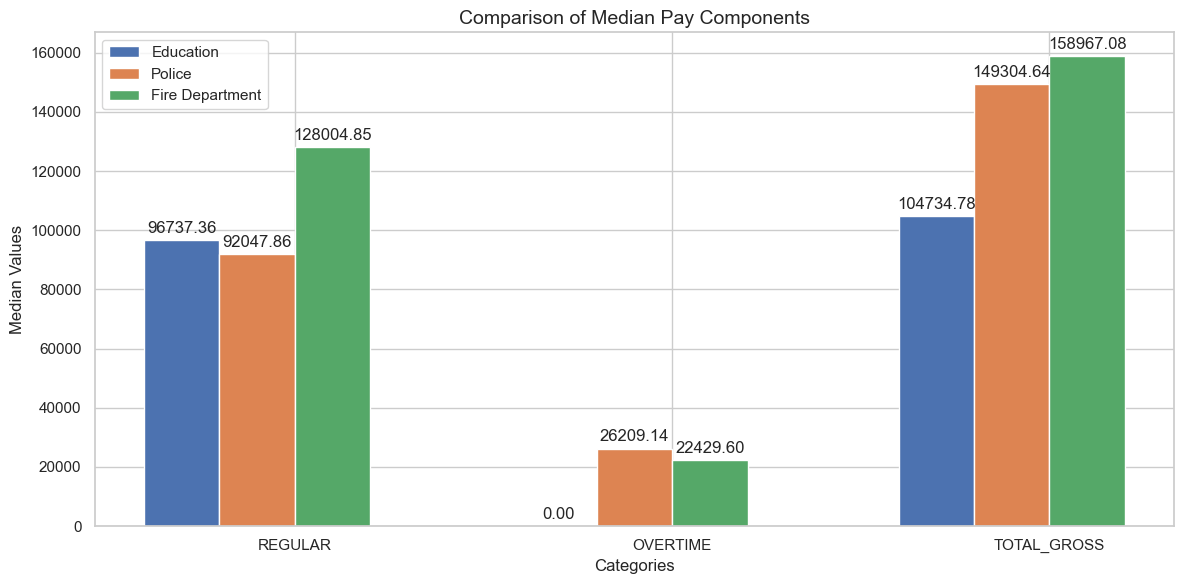

In [164]:
# Extract 'median' (50th percentile) values from the descriptive statistics
education_median = education_stats.loc['50%', ['REGULAR', 'OVERTIME', 'TOTAL_GROSS']]
police_median = police_stats.loc['50%', ['REGULAR', 'OVERTIME', 'TOTAL_GROSS']]
fire_median = fire_stats.loc['50%', ['REGULAR', 'OVERTIME', 'TOTAL_GROSS']]

# Convert to numeric for plotting (if necessary)
education_median = education_median.astype(float)
police_median = police_median.astype(float)
fire_median = fire_median.astype(float)

# Categories for x-axis
categories = education_median.index

# Set up bar positions
x = np.arange(len(categories))  # x locations for the groups
width = 0.2  # Reduced width to accommodate four bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each department
bars1 = ax.bar(x - 1.5 * width, education_median, width, label='Education')
bars2 = ax.bar(x - 0.5 * width, police_median, width, label='Police')
bars3 = ax.bar(x + 0.5 * width, fire_median, width, label='Fire Department')

# Add labels, title, and legend
ax.set_xlabel('Categories', fontsize=12)
ax.set_ylabel('Median Values', fontsize=12)
ax.set_title('Comparison of Median Pay Components', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels to bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text position slightly above bar
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Show the plot
plt.tight_layout()
plt.show()


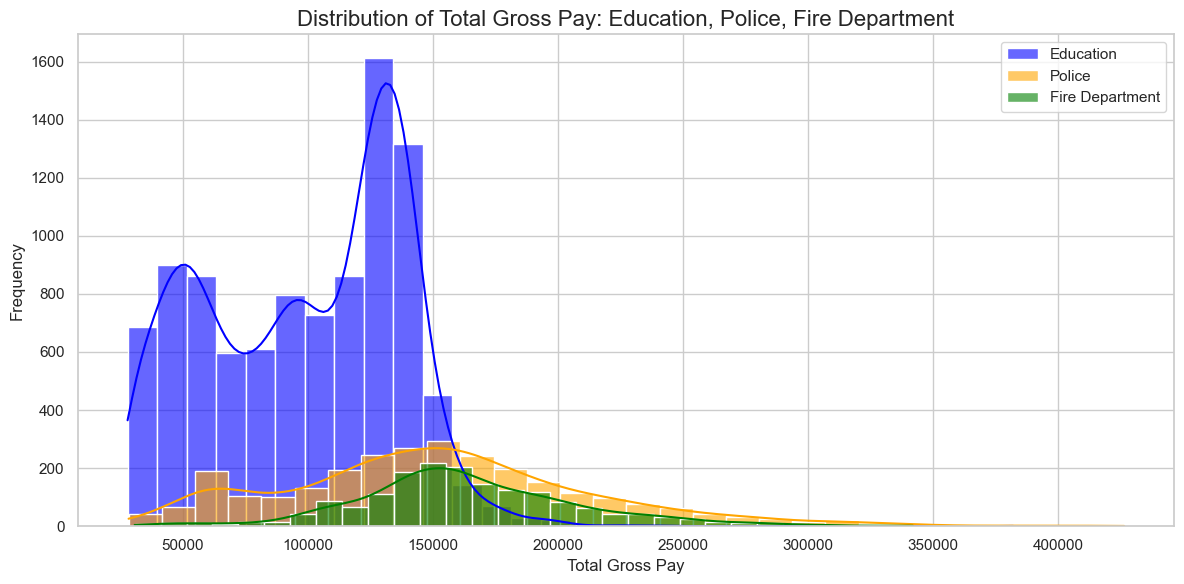

In [166]:
# Filter data for Education, Police, and Fire Department
education_total_gross = education_df['TOTAL_GROSS']
police_total_gross = police_df['TOTAL_GROSS']
fire_total_gross = fire_df['TOTAL_GROSS']

# Plot histograms using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(education_total_gross, bins=30, color='blue', kde=True, label='Education', alpha=0.6)
sns.histplot(police_total_gross, bins=30, color='orange', kde=True, label='Police', alpha=0.6)
sns.histplot(fire_total_gross, bins=30, color='green', kde=True, label='Fire Department', alpha=0.6)

# Add title and labels
plt.title('Distribution of Total Gross Pay: Education, Police, Fire Department', fontsize=16)
plt.xlabel('Total Gross Pay', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [168]:
# Group by 'DEPARTMENT_NAME' and calculate the median regular pay
median_regular_by_department = df.groupby('DEPARTMENT_NAME')['REGULAR'].median()

# Find the department with the highest median regular pay
highest_median_regular_department = median_regular_by_department.idxmax()
highest_median_regular_value = median_regular_by_department.max()

print(f"The department with the highest median regular pay is '{highest_median_regular_department}' with a median pay of {highest_median_regular_value:.2f}.")

The department with the highest median regular pay is 'Office of People Operations' with a median pay of 135790.37.


In [170]:
# Group by 'DEPARTMENT_NAME' and calculate the median overtime pay
median_overtime_by_department = df.groupby('DEPARTMENT_NAME')['OVERTIME'].median()

# Find the department with the highest median overtime pay
highest_median_department = median_overtime_by_department.idxmax()
highest_median_value = median_overtime_by_department.max()

print(f"The department with the highest median overtime pay is '{highest_median_department}' with a median pay of {highest_median_value:.2f}.")

The department with the highest median overtime pay is 'Boston Police Department' with a median pay of 26209.14.


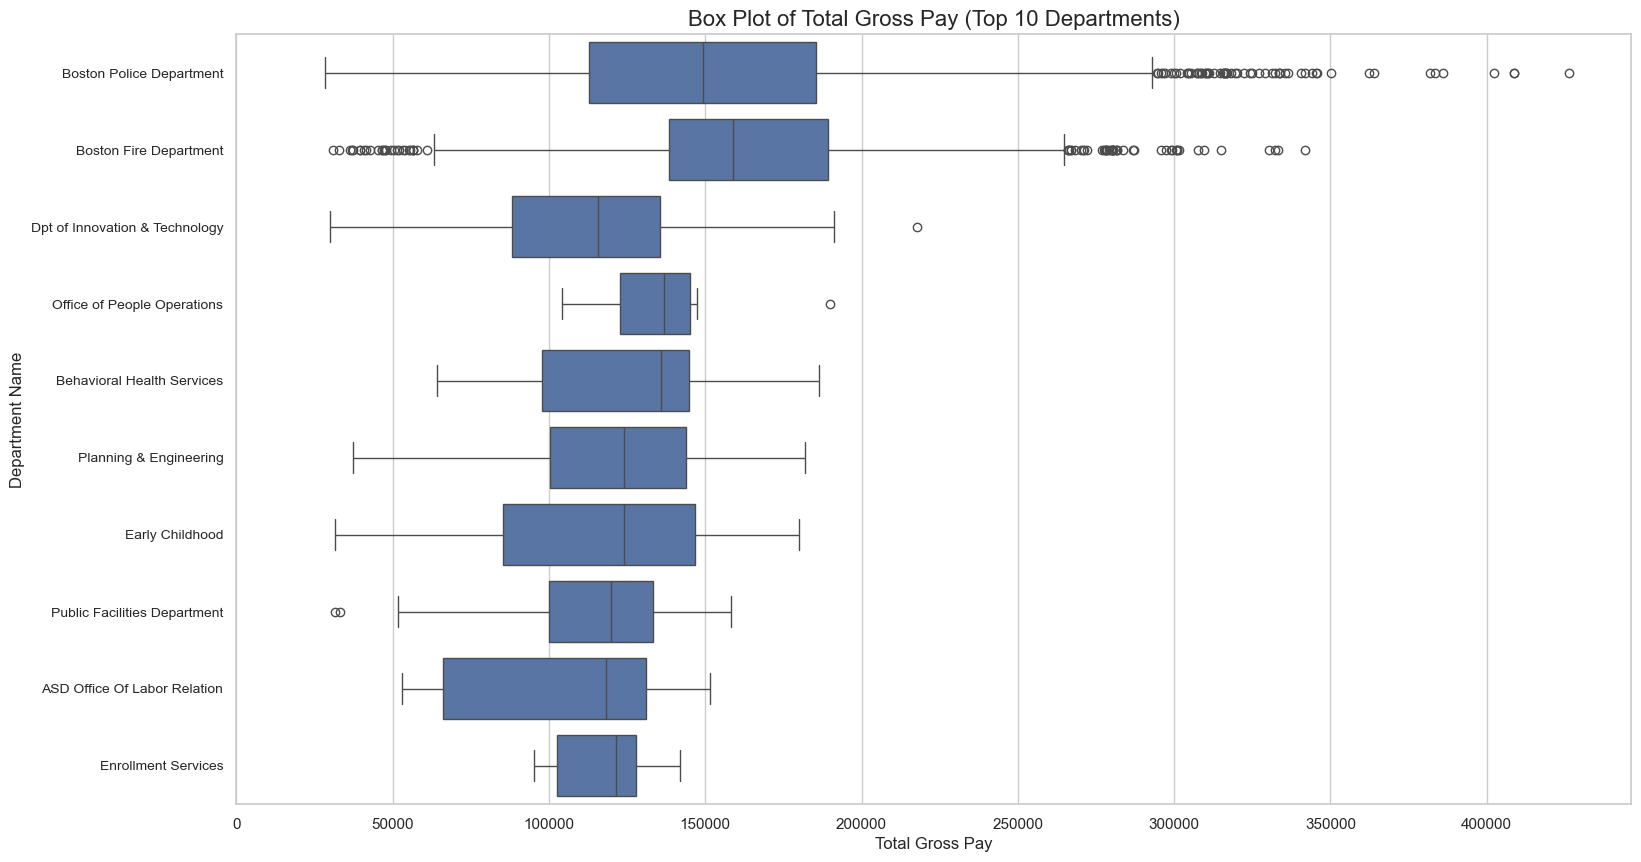

In [172]:
# Select top 15 departments by median TOTAL_GROSS
top_departments = df.groupby('DEPARTMENT_NAME')['TOTAL_GROSS'].median().nlargest(10).index

# Filter the DataFrame
filtered_df = df[df['DEPARTMENT_NAME'].isin(top_departments)]

# Create the box plot
plt.figure(figsize=(18, 10))  # Larger figure size
sns.boxplot(
    data=filtered_df, 
    x='TOTAL_GROSS', 
    y='DEPARTMENT_NAME', 
    orient='h', 
    showfliers=True
)

# Add title and labels
plt.title('Box Plot of Total Gross Pay (Top 10 Departments)', fontsize=16)
plt.xlabel('Total Gross Pay', fontsize=12)
plt.ylabel('Department Name', fontsize=12)

plt.xlim(left=0)

# Adjust tick label font size
plt.tick_params(axis='y', labelsize=10)

# Show the plot
plt.show()

In [174]:
department_counts = filtered_df['DEPARTMENT_NAME'].value_counts()
department_counts

DEPARTMENT_NAME
Boston Police Department          2727
Boston Fire Department            1705
Dpt of Innovation & Technology     135
Public Facilities Department        81
Planning & Engineering              60
Early Childhood                     50
Behavioral Health Services          23
ASD Office Of Labor Relation        11
Enrollment Services                 10
Office of People Operations          6
Name: count, dtype: int64

# Homelessness Correlation

# Using Mayor of Boston's Office of Housing


## Reading the CSV

In [176]:
df_families = pd.read_csv('./data/Boston_Homeless_Census_Families_Combined.csv')
df_subpopulation = pd.read_csv('./data/Boston_Homeless_Subpopulation_Combined.csv')
df_domestic_violence = pd.read_csv('./data/Updated_Domestic_Violence_Combined_Census.csv')
df_individuals=pd.read_csv('./data/Boston_Homeless_Census_Combined.csv')
df_rent_prices=pd.read_csv('./data/Boston_Rent_2016_to_2024.csv')
df_housing_price_index=pd.read_csv('./data/Housing_Price.csv')
print(df_rent_prices.columns)
print(df_rent_prices.head)

Index(['Year', 'Average Rent (USD)'], dtype='object')
<bound method NDFrame.head of    Year  Average Rent (USD)
0  2016                2700
1  2017                2800
2  2018                2900
3  2019                3000
4  2020                3100
5  2021                3200
6  2022                3300
7  2023                3400
8  2024                3500>


## Seeing The Trends In Homelessness

### Individuals

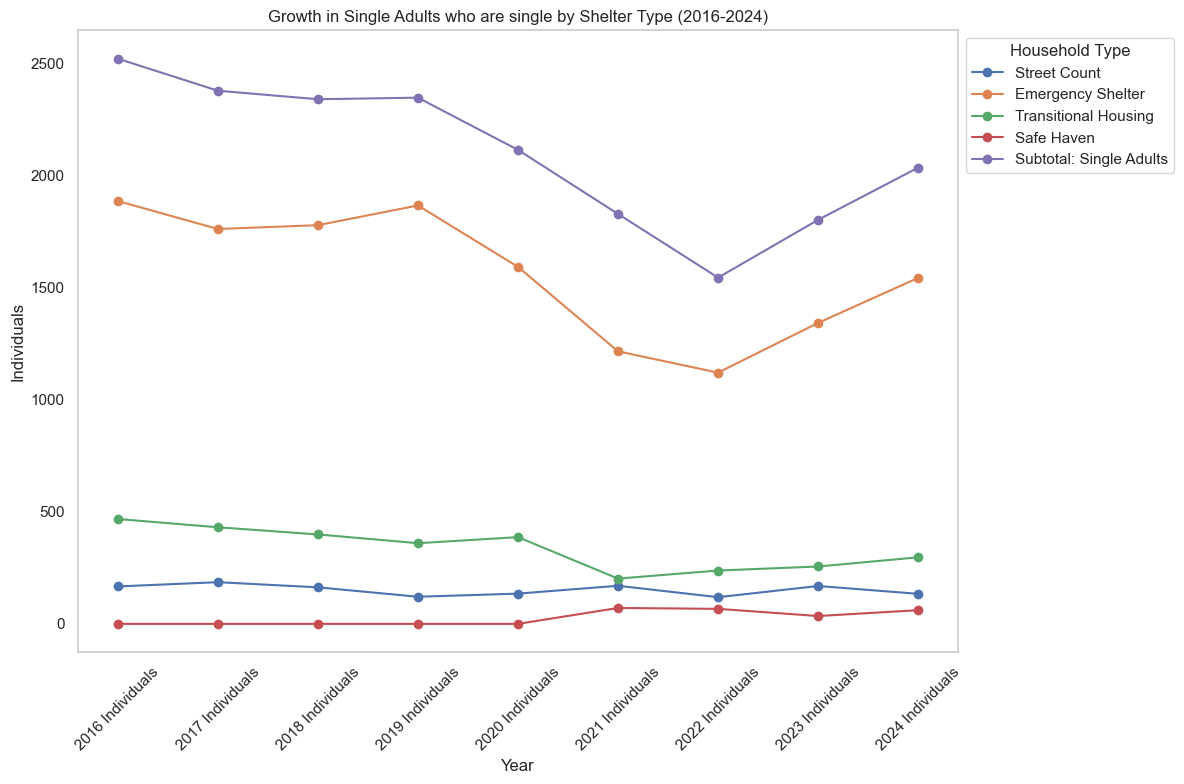

In [178]:
# Transpose the DataFrame
df_growth_transposed = df_individuals.transpose()

# Reset index to make the original index a column
df_growth_transposed.reset_index(inplace=True)

# Assign the first row as the column headers
df_growth_transposed.columns = df_growth_transposed.iloc[0]

# Drop the row that was used as column headers
df_growth_transposed = df_growth_transposed.iloc[1:]

# Set the 'Household Type' as the index
df_growth_transposed.set_index('Household Type', inplace=True)

# Fixing the value for "2021 Individuals"
df_growth_transposed.loc["2021 Individuals", "Subtotal: Single Adults"] = 1829

# Reverse the row order
df_growth_transposed = df_growth_transposed.iloc[::-1]

# Plotting the growth
plt.figure(figsize=(12, 8))
for household_type in df_growth_transposed.columns:
    plt.plot(df_growth_transposed.index, df_growth_transposed[household_type], marker='o', label=household_type)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Individuals")
plt.title("Growth in Single Adults who are single by Shelter Type (2016-2024)")
plt.xticks(rotation=45)
plt.legend(title="Household Type", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Individuals in Families and Families

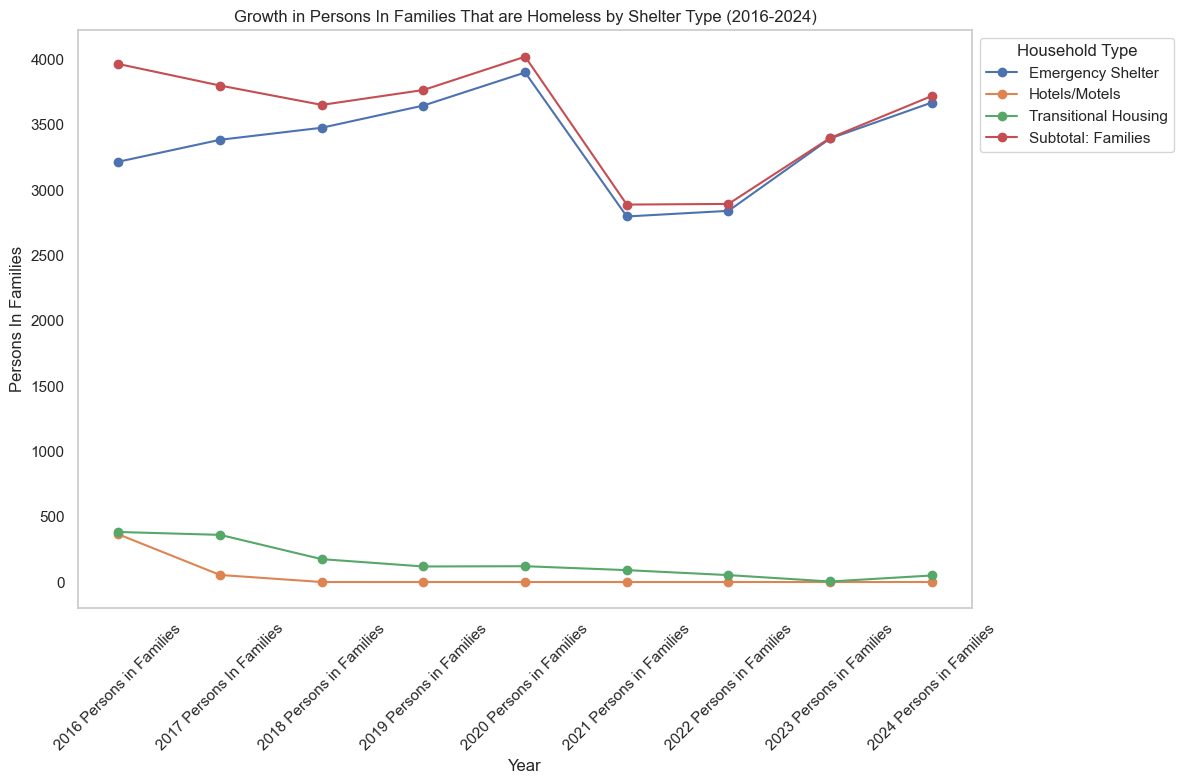

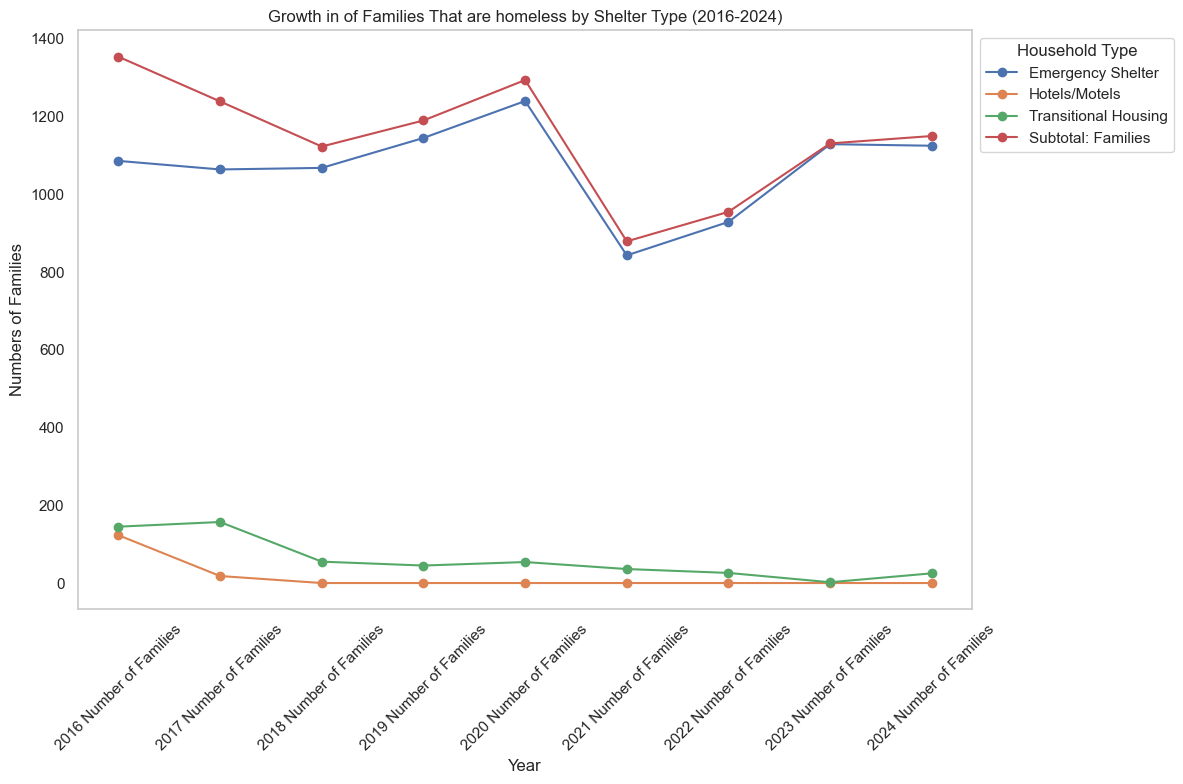

In [180]:
# Identify columns that belong to "Persons" and "Families"
persons_columns = [col for col in df_families.columns if "Persons" in col]
families_columns = [col for col in df_families.columns if "Number" in col]

# Create new DataFrames for each group
df_persons = df_families[['Household Type']+persons_columns]
df_families = df_families[['Household Type']+families_columns]

df_persons_transposed=df_persons.transpose()

# Reset index to make the original index a column
df_persons_transposed.reset_index(inplace=True)

# Assign the first row as the column headers
df_persons_transposed.columns = df_persons_transposed.iloc[0]

# Drop the row that was used as column headers
df_persons_transposed = df_persons_transposed.iloc[1:]

# Set the 'Household Type' as the index
df_persons_transposed.set_index('Household Type', inplace=True)

# Plotting the growth
plt.figure(figsize=(12, 8))
for household_type in df_persons_transposed.columns:
    plt.plot(df_persons_transposed.index, df_persons_transposed[household_type], marker='o', label=household_type)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Persons In Families")
plt.title("Growth in Persons In Families That are Homeless by Shelter Type (2016-2024)")
plt.xticks(rotation=45)
plt.legend(title="Household Type", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

# Transpose df_persons
df_families_transposed=df_families.transpose()

# Reset index to make the original index a column
df_families_transposed.reset_index(inplace=True)

# Assign the first row as the column headers
df_families_transposed.columns = df_families_transposed.iloc[0]

# Drop the row that was used as column headers
df_families_transposed = df_families_transposed.iloc[1:]

# Set the 'Household Type' as the index
df_families_transposed.set_index('Household Type', inplace=True)

# Plotting the growth
plt.figure(figsize=(12, 8))
for household_type in df_families_transposed.columns:
    plt.plot(df_families_transposed.index, df_families_transposed[household_type], marker='o', label=household_type)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Numbers of Families")
plt.title("Growth in of Families That are homeless by Shelter Type (2016-2024)")
plt.xticks(rotation=45)
plt.legend(title="Household Type", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

## Finding Average Size of Homelessness

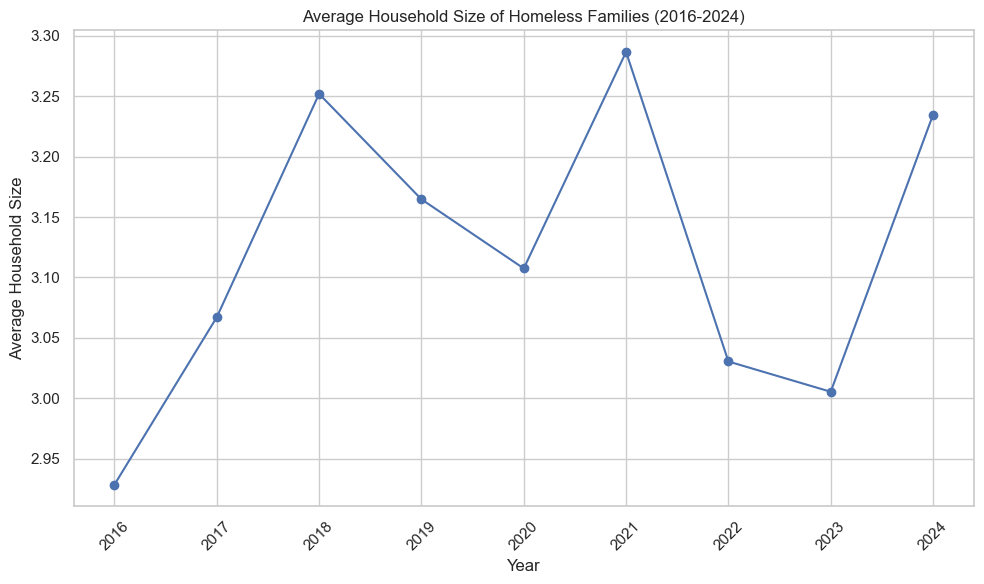

In [182]:
# Convert data to numeric (in case some are strings)
df_family_subtotal = df_families_transposed['Subtotal: Families']
df_person_subtotal = df_persons_transposed['Subtotal: Families']
year=2016
index= 0
average_household_size_homeless=pd.Series()
while(year<2025):
    average_household_size_homeless[f"{year}"]=df_person_subtotal.iloc[index]/df_family_subtotal.iloc[index]
    index+=1
    year+=1
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(average_household_size_homeless.index, average_household_size_homeless.values, marker='o', linestyle='-', color='b')

# Adding labels, title, and grid
plt.xlabel("Year")
plt.ylabel("Average Household Size")
plt.title("Average Household Size of Homeless Families (2016-2024)")
plt.xticks(average_household_size_homeless.index, rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Domestic Violence & The number of persons & families that are homeless

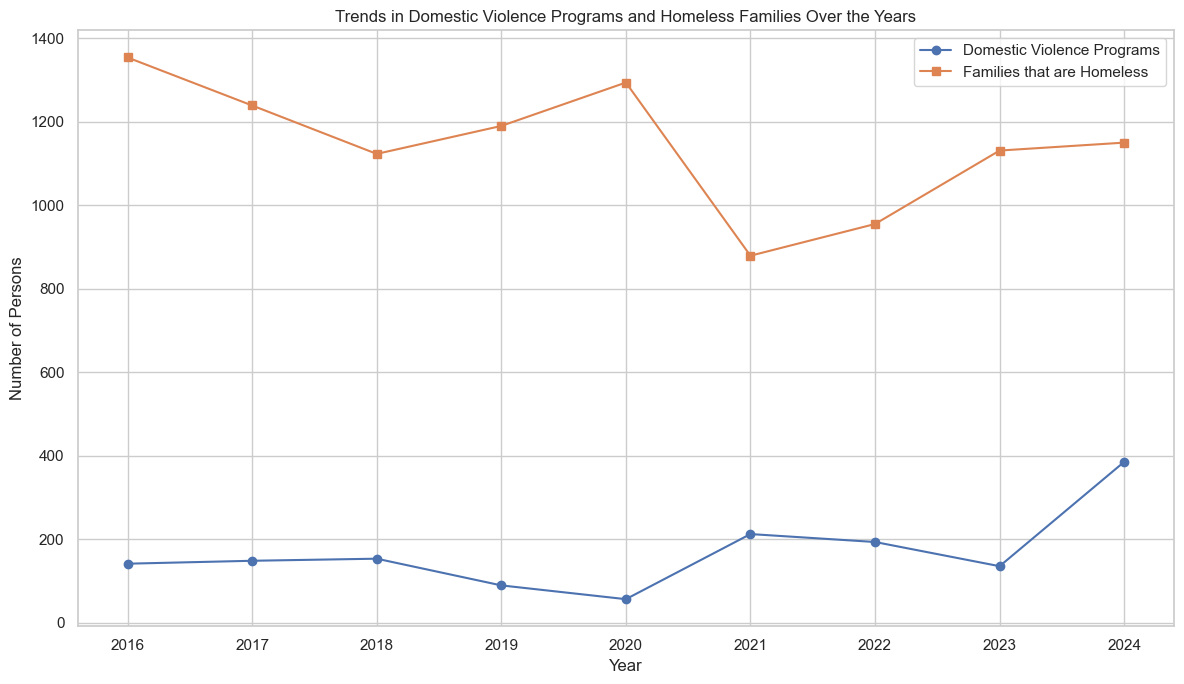

In [184]:
df_subpopulation_transposed = df_subpopulation.transpose()
# Reset index to make the original index a column
df_subpopulation_transposed.reset_index(inplace=True)
# Assign the first row as the column headers
df_subpopulation_transposed.columns = df_subpopulation_transposed.iloc[0]
# Drop the row that was used as column headers
df_subpopulation_transposed = df_subpopulation_transposed.iloc[1:]
df_subpopulation_transposed.set_index('Subpopulation Type', inplace=True)
df_sub_dv=df_subpopulation_transposed['Persons in domestic violence (DV) programs']

domestic_violence_individuals = [col for col in df_domestic_violence.columns if 'Persons' in col]
df_domestic_violence_individuals =df_domestic_violence[['Program Type']+domestic_violence_individuals]

df_domestic_violence_transposed = df_domestic_violence_individuals.transpose()
# Reset index to make the original index a column
df_domestic_violence_transposed.reset_index(inplace=True)
# Assign the first row as the column headers
df_domestic_violence_transposed.columns = df_domestic_violence_transposed.iloc[0]
# Drop the row that was used as column headers
df_domestic_violence_transposed = df_domestic_violence_transposed.iloc[1:]
df_domestic_violence_transposed_subtotal = df_domestic_violence_transposed[['Program Type','Subtotal: Domestic Violence']]

combined = pd.Series()
year= 2021
index = 0
while year !=2025:
    combined[year]=df_sub_dv.iloc[index]
    index+=1
    year+=1
year=2016
index=0
while year!=2021:
    combined[year] = df_domestic_violence_transposed_subtotal.iloc[index,1]
    year+=1
    index+=1
combined.sort_index(inplace=True)
df_families_subtotal = df_families_transposed['Subtotal: Families']
total_families=[]
for x in df_families_transposed.values:
    total_families.append(x[-1])
total_families = np.array(total_families)

data = {"Years":combined.index,"domestic_violence":combined.values, 'Homeless Families': total_families}
combined_df= pd.DataFrame(data)

# Plot the trends
plt.figure(figsize=(12, 7))
plt.plot(combined_df['Years'], combined_df['domestic_violence'], marker='o', label='Domestic Violence Programs')
plt.plot(combined_df['Years'], combined_df['Homeless Families'], marker='s', label='Families that are Homeless')

# Customize the plot
plt.title('Trends in Domestic Violence Programs and Homeless Families Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Persons')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

## Total Homelessness

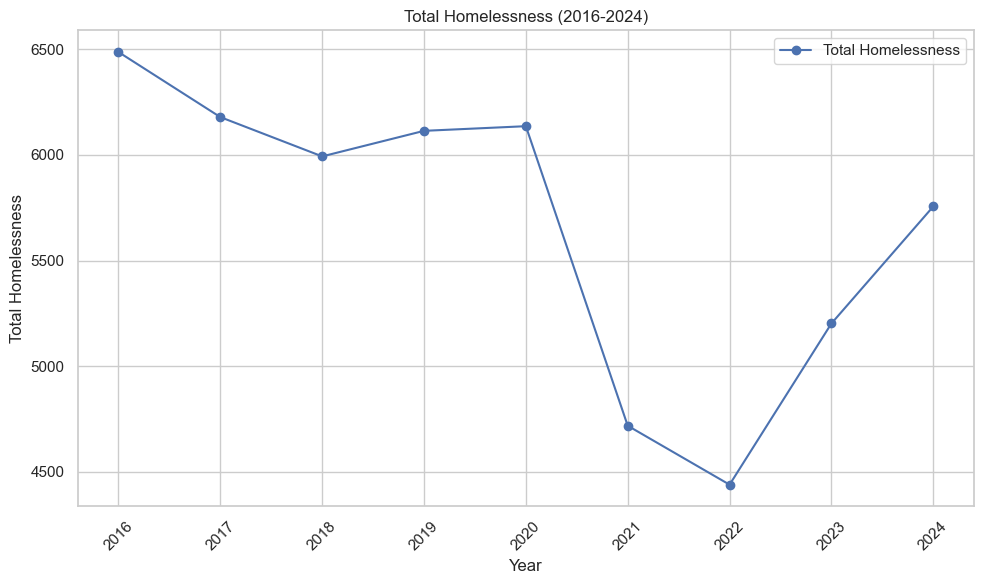

[6487.0, 6179.0, 5993.0, 6114.0, 6136.0, 4718, 4439.0, 5202.0, 5756.0]


In [186]:
combined =[]
for x in range(9):
    # Correctly access the elements with .iloc[row, column]
    value = df_persons_transposed.iloc[x, 3] + df_growth_transposed.iloc[x, 4]
    combined.append(value)
df_total_homelessness = pd.DataFrame({'Year':[2016,2017,2018,2019,2020,2021,2022,2023,2024],'Total':combined})
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_total_homelessness['Year'], df_total_homelessness['Total'], marker='o', label='Total Homelessness')

# Adding labels, title, and grid
plt.xlabel('Year')
plt.ylabel('Total Homelessness')
plt.title('Total Homelessness (2016-2024)')
plt.xticks(df_total_homelessness['Year'], rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
print(combined)

### Housing budget in boston and the number of homeless individuals in Boston

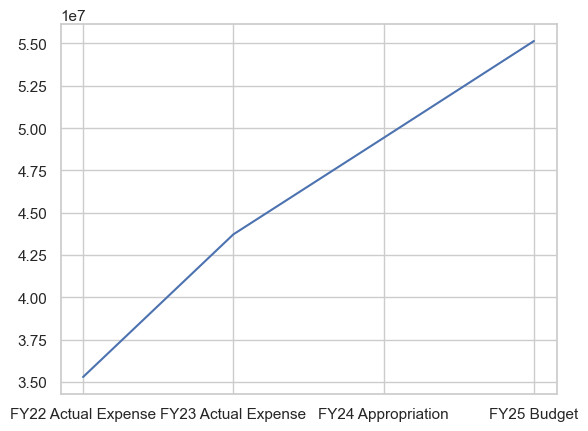

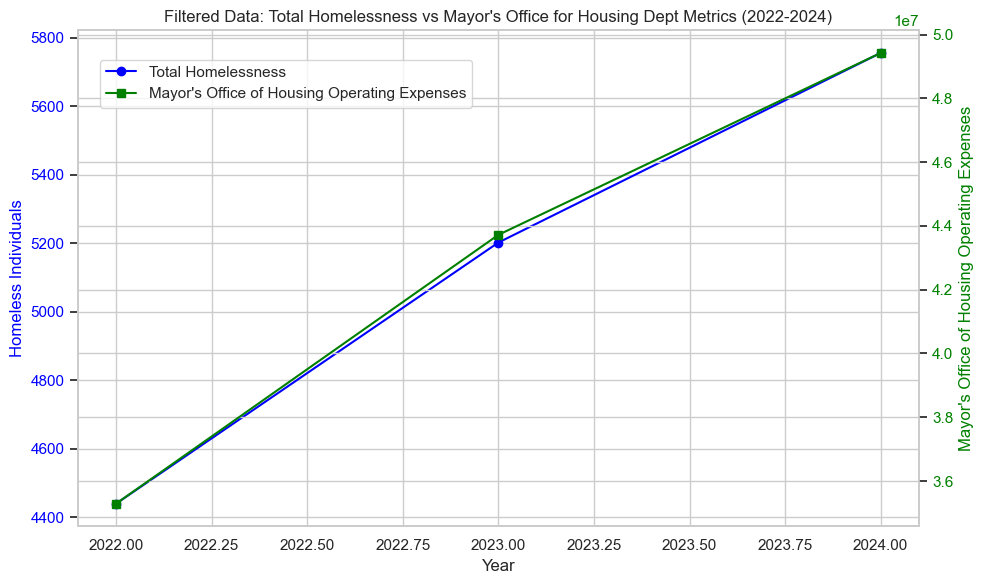

Correlation coefficient: 0.9998094135891039
P-value: 0.012429337602277157


In [188]:
# Filter for the specific department
department_name = "Mayor's Office of Housing"
df_department_filtered = df_aggregated[df_aggregated['Dept'] == department_name]
df_department_filtered_list = df_department_filtered.groupby(by='Fiscal Year').aggregate('sum').Spending.tolist()[:-1]
combined =[]
for x in range(9):
    # Correctly access the elements with .iloc[row, column]
    value = df_persons_transposed.iloc[x, 3] + df_growth_transposed.iloc[x, 4]
    combined.append(value)

df_combined_filtered= pd.DataFrame({'Year':[2022,2023,2024],'Homeless_Individuals':combined[-3:],'Operating_Expenses': df_department_filtered_list})
plt.plot(df_department_filtered.groupby(by='Fiscal Year').aggregate('sum').Spending)
plt.show
# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Total Homelessness on the first y-axis
ax1.plot(df_combined_filtered['Year'], df_combined_filtered['Homeless_Individuals'], marker='o', color='blue', label='Total Homelessness')
ax1.set_xlabel('Year')
ax1.set_ylabel('Homeless Individuals', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Filtered Data: Total Homelessness vs Mayor's Office for Housing Dept Metrics (2022-2024)")
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_combined_filtered['Year'], df_combined_filtered['Operating_Expenses'], marker='s', color='green', label="Mayor's Office of Housing Operating Expenses")
ax2.set_ylabel("Mayor's Office of Housing Operating Expenses", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both y-axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.tight_layout()
plt.show()

correlation_coefficient, p_value = stats.pearsonr(df_combined_filtered['Homeless_Individuals'], df_combined_filtered['Operating_Expenses'])

print("Correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)


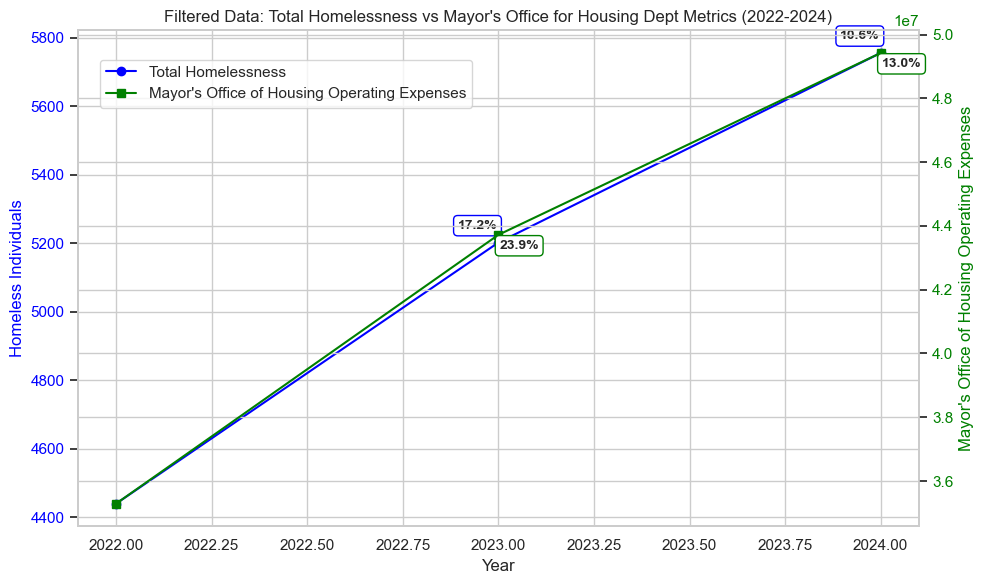

In [190]:
# Calculate percentage growth for Homeless Individuals and Operating Expenses
df_combined_filtered['Homeless_Growth_%'] = df_combined_filtered['Homeless_Individuals'].pct_change() * 100
df_combined_filtered['Operating_Expenses_Growth_%'] = df_combined_filtered['Operating_Expenses'].pct_change() * 100

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Total Homelessness on the first y-axis
ax1.plot(df_combined_filtered['Year'], df_combined_filtered['Homeless_Individuals'], marker='o', color='blue', label='Total Homelessness')
ax1.set_xlabel('Year')
ax1.set_ylabel('Homeless Individuals', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Filtered Data: Total Homelessness vs Mayor's Office for Housing Dept Metrics (2022-2024)")
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_combined_filtered['Year'], df_combined_filtered['Operating_Expenses'], marker='s', color='green', label="Mayor's Office of Housing Operating Expenses")
ax2.set_ylabel("Mayor's Office of Housing Operating Expenses", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both y-axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Annotate percentage growth on the first axis
# Annotate percentage growth on the first axis with improved style
for i, row in df_combined_filtered.iterrows():
    if not pd.isna(row['Homeless_Growth_%']):  # Avoid NaN values
        ax1.annotate(
            f"{row['Homeless_Growth_%']:.1f}%",
            (row['Year'], row['Homeless_Individuals']),
            textcoords="offset points",
            xytext=(-15, 10),
            ha='center',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white')
        )

    if not pd.isna(row['Operating_Expenses_Growth_%']):  # Avoid NaN values
        ax2.annotate(
            f"{row['Operating_Expenses_Growth_%']:.1f}%",
            (row['Year'], row['Operating_Expenses']),
            textcoords="offset points",
            xytext=(15, -10),
            ha='center',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white')
        )


plt.tight_layout()
plt.show()

### Total Homelessness vs All Transactions housing price

/var/folders/ff/22z5c2zx3x75979ph3jgq4400000gn/T/ipykernel_12702/2638120686.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DATE'].dt.year


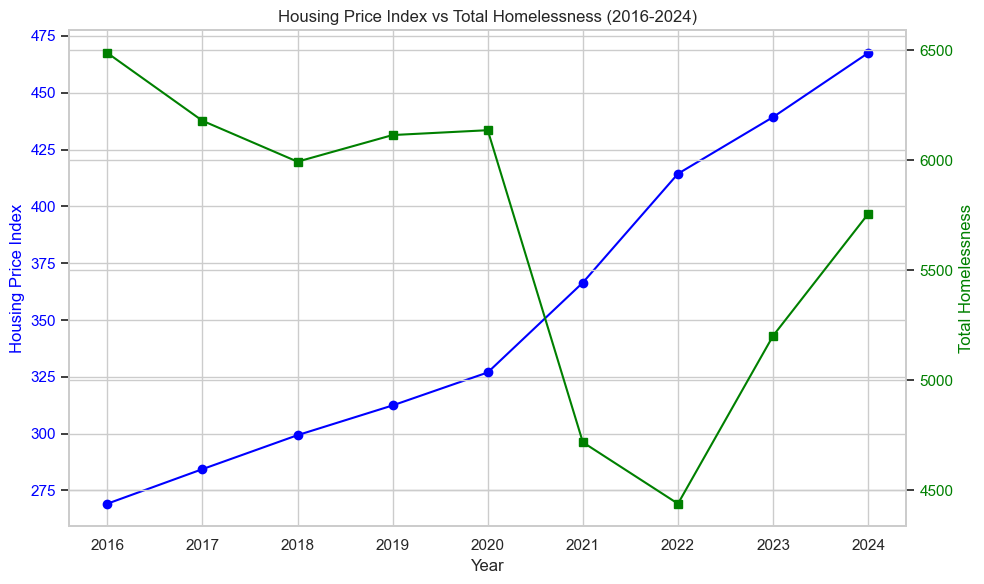

Correlation coefficient: -0.6550539119685093
P-value: 0.05550066761257748


In [192]:
# Convert the 'DATE' column to datetime format for filtering
df_housing_price_index['DATE'] = pd.to_datetime(df_housing_price_index['DATE'])

# Filter the data for the date range 2016-01-01 to 2024-12-31
filtered_data = df_housing_price_index[(df_housing_price_index['DATE'] >= '2016-01-01') & (df_housing_price_index['DATE'] <= '2024-12-31')]

# Convert to a pandas Series, using the 'DATE' as the index
series_2016_2024 = pd.Series(filtered_data['ATNHPIUS14454Q'].values, index=filtered_data['DATE'])

# Display the first few rows of the Series
# Extract the year from the 'DATE' index
filtered_data['Year'] = filtered_data['DATE'].dt.year

# Group by 'Year' and calculate the average price
yearly_average = filtered_data.groupby('Year')['ATNHPIUS14454Q'].mean()
df_total_homelessness_housing_index = pd.DataFrame({'Year':[2016,2017,2018,2019,2020,2021,2022,2023,2024],
                                                    'Housing_Price_Index':yearly_average.values,
                                                    'Total_Homelessness': df_total_homelessness['Total']})
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Housing Price Index on the first y-axis
ax1.plot(df_total_homelessness_housing_index['Year'],
         df_total_homelessness_housing_index['Housing_Price_Index'],
         label='Housing Price Index', marker='o', color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Housing Price Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_total_homelessness_housing_index['Year'],
         df_total_homelessness_housing_index['Total_Homelessness'],
         label='Total Homelessness', marker='s', color='green')
ax2.set_ylabel('Total Homelessness', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('Housing Price Index vs Total Homelessness (2016-2024)')

# Add a grid for better readability
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


correlation_coefficient, p_value = stats.pearsonr(df_total_homelessness_housing_index['Housing_Price_Index'], df_total_homelessness_housing_index['Total_Homelessness'])

print("Correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)

### Total Homelessness vs Growth of Housing Price index

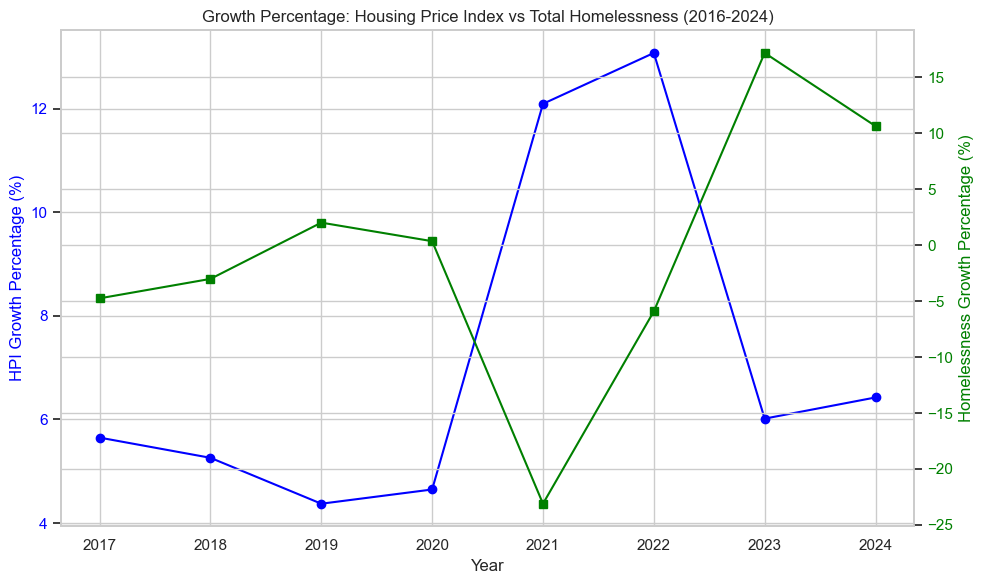

-24.265123240678072


In [194]:
# Calculate growth percentage for Housing Price Index and Total Homelessness
df_total_homelessness_housing_index['HPI_Growth_Percentage'] = df_total_homelessness_housing_index['Housing_Price_Index'].pct_change() * 100
df_total_homelessness_housing_index['Homelessness_Growth_Percentage'] = df_total_homelessness_housing_index['Total_Homelessness'].pct_change() * 100

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Housing Price Index Growth Percentage on the first y-axis
ax1.plot(df_total_homelessness_housing_index['Year'],
         df_total_homelessness_housing_index['HPI_Growth_Percentage'],
         label='HPI Growth Percentage', marker='o', color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('HPI Growth Percentage (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_total_homelessness_housing_index['Year'],
         df_total_homelessness_housing_index['Homelessness_Growth_Percentage'],
         label='Homelessness Growth Percentage', marker='s', color='green')
ax2.set_ylabel('Homelessness Growth Percentage (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('Growth Percentage: Housing Price Index vs Total Homelessness (2016-2024)')

# Add a grid for better readability
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


df_total_homelessness_housing_index.dropna(inplace=True)

cov = np.cov(df_total_homelessness_housing_index['HPI_Growth_Percentage'], df_total_homelessness_housing_index['Homelessness_Growth_Percentage'])

print(cov[0][1])

### Total Homelessness vs Average Rent Size

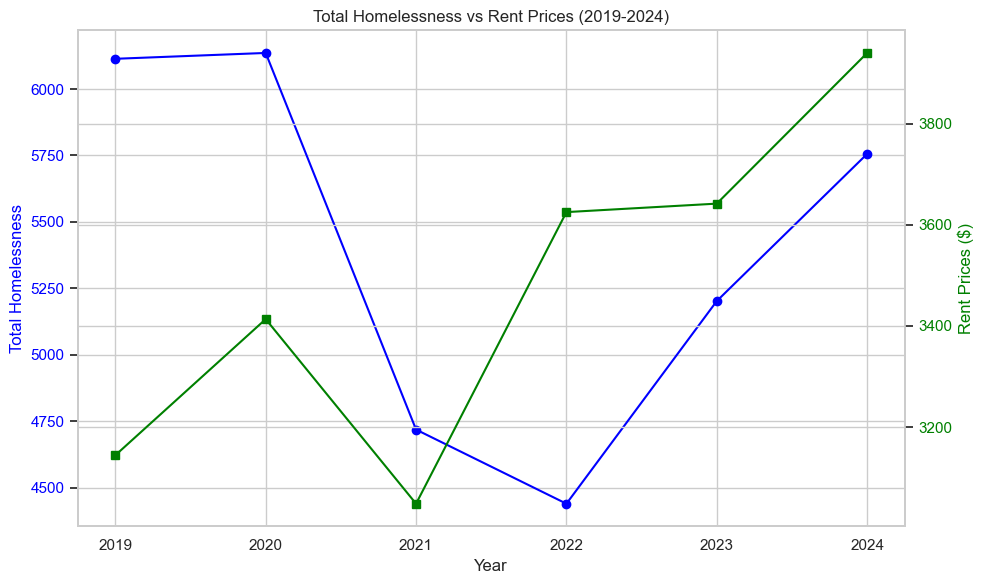

[ 5.21174567e+05 -5.11766667e+02] [  -511.76666667 112107.84166667]


In [196]:
combined =[]
for x in range(9):
    # Correctly access the elements with .iloc[row, column]
    value = df_persons_transposed.iloc[x, 3] + df_growth_transposed.iloc[x, 4]
    combined.append(value)
df_total_homelessness = pd.DataFrame({'Year':[2016,2017,2018,2019,2020,2021,2022,2023,2024],'Total':combined})
df_homelessness=pd.DataFrame({'Year':[2019,2020,2021,2022,2023,2024],'Total Homelessness':combined[-6:],'Rent Prices':[3144.50,3413.50,3048.75,3625,3641.75,3939.50]})
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Total Homelessness on the first y-axis
ax1.plot(df_homelessness['Year'],
         df_homelessness['Total Homelessness'],
         label='Total Homelessness', marker='o', color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Homelessness', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_homelessness['Year'],
         df_homelessness['Rent Prices'],
         label='Rent Prices', marker='s', color='green')
ax2.set_ylabel('Rent Prices ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('Total Homelessness vs Rent Prices (2019-2024)')

# Add a grid for better readability
ax1.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

cov = np.cov(df_homelessness['Total Homelessness'], df_homelessness['Rent Prices'])

print(*cov)

# Using the Data of Department of Fair Housing & Equity

In [200]:
df_operating = pd.read_csv('./data/FY25_Operating.csv')
df_fy25capital = pd.read_csv('./data/FY25_Capital.csv')

housing_data = df_operating[df_operating['Dept'] == "Fair Housing & Equity"]
words = ["housing", "homelessness", "shelter", "home", "housing", "homeless"]
operating_budget_housing = housing_data[housing_data['Program'].str.contains('|'.join(words), case=False, na=False)]
capital_budget_housing = df_fy25capital[df_fy25capital['Project_Name'].str.contains('|'.join(words), case=False, na=False)]

## Fair Housing & Equity Budget

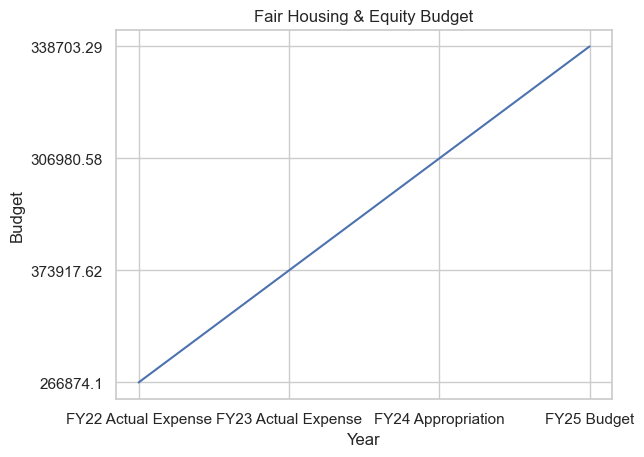

In [202]:
years = [
    "FY22 Actual Expense",
    "FY23 Actual Expense",
    "FY24 Appropriation",
    "FY25 Budget"
]

plt.plot(years, housing_data[years].values[0])
plt.xlabel('Year')
plt.ylabel('Budget')
plt.title('Fair Housing & Equity Budget')
plt.show()

# Filter Rows Related to Homelessness


In [204]:
homelessness_keywords = ["homeless", "shelter", "housing"]
# Filter rows related to homelessness
operating_relevant = operating_budget_housing[
    operating_budget_housing.apply(lambda row: any(keyword in str(row).lower() for keyword in homelessness_keywords), axis=1)
]
capital_relevant = capital_budget_housing[
    capital_budget_housing.apply(lambda row: any(keyword in str(row).lower() for keyword in homelessness_keywords), axis=1)
]

print(capital_relevant.head())

     _id                       Department  \
78    80        Mayor's Office of Housing   
84    86  Parks and Recreation Department   
177  179   Property Management Department   
264  266          Public Works Department   

                                     Project_Name  \
78                       BHA Housing Improvements   
84                                 Animal Shelter   
177          Animal Shelter HVAC - 26 Mahler Road   
264  Whittier Street Housing Development Roadways   

                                         Scope_Of_Work  \
78   Upgrade elderly/disabled public housing units ...   
84   Develop a building program and assess siting o...   
177  Design and implement HVAC and building repairs...   
264  Reconstruct roads and sidewalks in the Whittie...   

                    PM_Department  Project_Status Neighborhood  \
78       Boston Housing Authority  Annual Program     Citywide   
84   Public Facilities Department       In Design      Roxbury   
177  Public Facilit

# Fair Housing Comission Spending by Category

/var/folders/ff/22z5c2zx3x75979ph3jgq4400000gn/T/ipykernel_12702/2474288837.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fair_housing_data[col] = pd.to_numeric(fair_housing_data[col], errors='coerce')


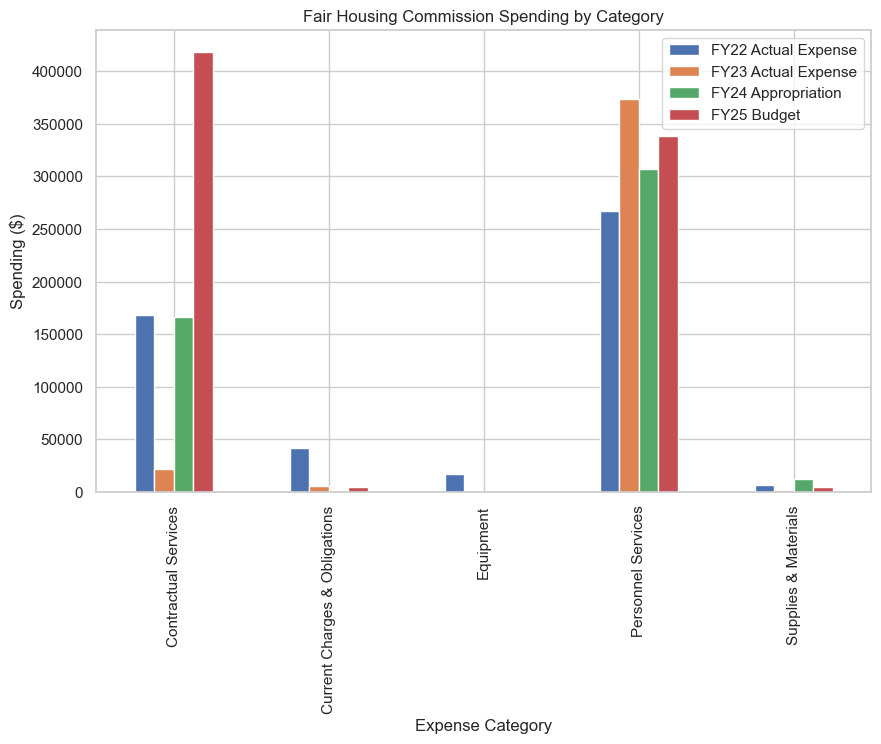

In [208]:
operating_budget_housing = pd.read_csv("./data/FY25_Operating.csv")
fair_housing_data = operating_budget_housing[
    operating_budget_housing["Program"].str.contains("Fair Housing", case=False, na=False)
]

for col in ["FY22 Actual Expense", "FY23 Actual Expense", "FY24 Appropriation", "FY25 Budget"]:
    fair_housing_data[col] = pd.to_numeric(fair_housing_data[col], errors='coerce')

spending_by_category = fair_housing_data.groupby("Expense Category")[
    ["FY22 Actual Expense", "FY23 Actual Expense", "FY24 Appropriation", "FY25 Budget"]
].sum()

spending_by_category.plot(kind="bar", figsize=(10, 6))
plt.title("Fair Housing Commission Spending by Category")
plt.ylabel("Spending ($)")
plt.xlabel("Expense Category")
plt.show()

## Fair Housing Commision Total Spending Over the Year

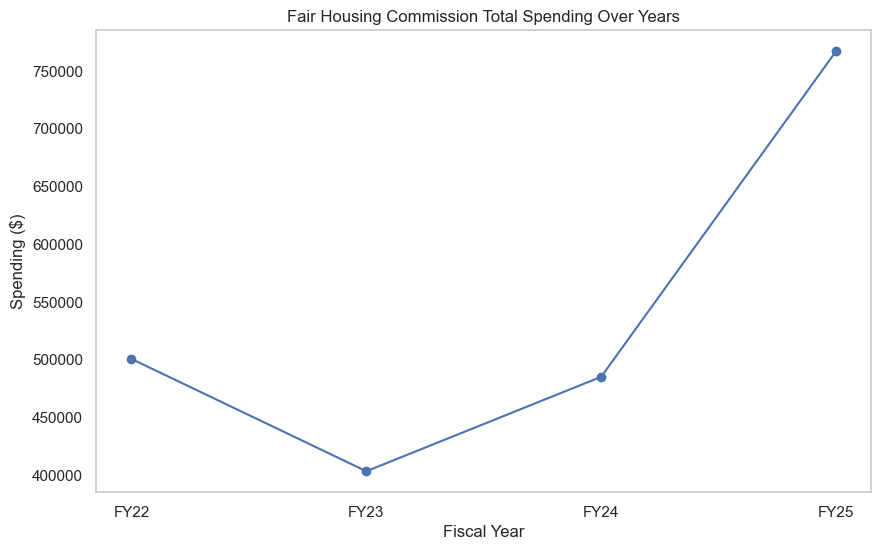

In [210]:
total_spending_by_year = fair_housing_data[
    ["FY22 Actual Expense", "FY23 Actual Expense", "FY24 Appropriation", "FY25 Budget"]
].sum()

total_spending_by_year.index = ["FY22", "FY23", "FY24", "FY25"]

total_spending_by_year.plot(kind="line", marker="o", figsize=(10, 6))
plt.title("Fair Housing Commission Total Spending Over Years")
plt.ylabel("Spending ($)")
plt.xlabel("Fiscal Year")
plt.grid()
plt.show()
